# The analysis of the Home Credit Group dataset (I part)

## Introduction

The project uses the dataset of the Home Credit Group (https://www.homecredit.net/). The Home Credit is an international consumer finance provider operates in 9 countries and focuses on installment lending primarily to people with little or no credit history.

The dataset which is downloaded from the Kaggle repository (https://www.kaggle.com/competitions/home-credit-default-risk/data) includes these files: 

1) two files with data for all loan applications, broken into two files for Train (with TARGET) and Test (without TARGET); one row represents one loan in our data sample (application_train.csv, application_test.csv);

2) a file containing data on all client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample); for every loan in the sample, there are as many rows as number of credits the client had in Credit Bureau before the application date (bureau.csv);

3) a file with data on monthly balances of previous credits in Credit Bureau; the table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows (bureau_balance.csv);

4) a file with data on monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit; the table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in the sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months) rows (POS_CASH_balance.csv);

5) a file containing data on monthly balance snapshots of previous credit cards that the applicant has with Home Credit; this table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in the sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months) rows (credit_card_balance.csv); 

6) a file with data on previous applications for Home Credit loans of clients who have loans in our sample; there is one row for each previous application related to loans in our data sample (previous_application.csv); 

7) a file containing data on the repayment history for the previously disbursed credits in Home Credit related to the loans in the sample; there is a) one row for every payment that was made plus b) one row each for missed payment; one row is equivalent to one payment of one installment or one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample (installments_payments.csv). 

The relationships between datasets can be seen in this image:

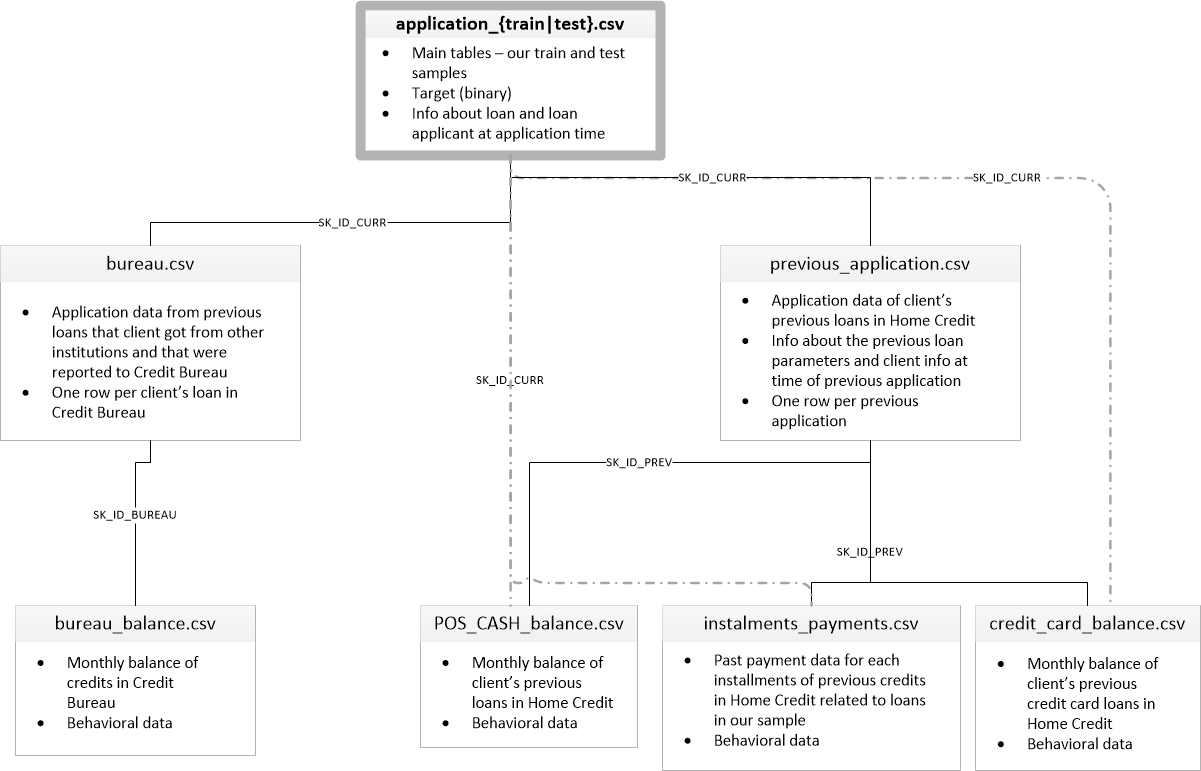

The purposes of the project:
 - to iteratively build and implement a plan for a large dataset based on business objectives;
 - to create a number of different models in order to develop a robust and diversified offering of a product of the risk evaluation as a service for retail banks.

Requirements:
- Create a plan for your investigation, analysis, and POC building. This should include your assumptions, overall objectives, and objectives for each step in your plan. You are not expected to have a plan for the whole project but instead have a clear understanding of what you'll try to achieve in the next step and build the plan one step at a time.
- Perform exploratory data analysis. This should include creating statistical summaries and charts, testing for anomalies, checking for correlations and other relations between variables, and other EDA elements.
- Perform statistical inference. This should include defining the target population, forming multiple statistical hypotheses and constructing confidence intervals, setting the significance levels, conducting z or t-tests for these hypotheses.
- Use machine learning models to predict the target variables based on your proposed plan. You should use hyperparameter tuning, model ensembling, the analysis of model selection, and other methods. The decision of where to use and not to use these techniques is up to you; however, they should be aligned with your team's objectives.
- Deploy these machine learning models to Google Cloud Platform. You are free to choose any deployment option you wish as long as it can be called an HTTP request.

Objectives:

- Practice translating business requirements into data science tasks.
- Practice performing EDA.
- Practice applying statistical inference procedures.
- Practice using machine learning to solve business problems.
- Practice deploying multiple machine learning models.



### Plan of the analysis

The analysis consists of two major parts: 
1. the exploratory data analysis which includes:
- importing and examining the datasets, 
- examining variables of the each dataset, 
- preprocessing variables (doing dimension reduction with principal component analysis, transforming variables, constructing new variables, etc.),
- merging preprocessed variables from various dataframes into one dataframe,
- examining relationships between variables (calculating correlation coeffficients, doing statistical tests),
- checking for missing values, outliers, and duplicates,
2. the machine learning which includes:
- building machine learning modelling pipelines and functions,
- running functions on different combinations of features, parameters and classifiers, 
- recursivelly selecting features by shap values, 
- randomly selecting features, 
- doing hyperparameter tuning with the Bayesian optimization,
- testing the best performing model on the test data, 
- creating and running a deep learning model with the tensorflow library,
- creating an API which will be deployed to the Google Cloud Platform.

The exploratory analysis and machine learning parts are presented in two separate Jupyter notebooks.

### Hypotheses

Those clients will likely experience loan payment difficulties:

- who have worse loan payment history;
- who take loans of larger ammount;
- who have less qualified jobs or are unemployed;
- who have lower levels of education;
- who live in rented houses; etc.

These and other hypotheses will be tested in the course of the exploratory data analysis.

#### Importing libraries

The main libraries which will be used for the manipulation with data are pandas and numpy. Matplotlib, seaborn and yellowbrick will be used for data visualization. Scipy, Statsmodels, Researchpy, Math, Random will be used for conducting statistical tests, calculating confidence intervals. Sklearn modules will be used for spliting data into training and testing samples, building and testing machine learning models. Optuna will be used for the Bayesian optimization. Tensorflow will be used for the deep learning modelling. 

In [367]:
import numpy as np 
import pandas as pd
import sqlite3
import duckdb
import random
import math

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

from scipy import stats
from scipy.stats import chi2_contingency, norm

import researchpy as rp

from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import optuna

import sklearn
import sklearn.ensemble
import sklearn.model_selection
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder, FunctionTransformer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline as Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, \
cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, f1_score, precision_score, \
recall_score, confusion_matrix as cfm, make_scorer, classification_report, mean_absolute_error,\
mean_squared_error,mean_squared_log_error,r2_score, roc_auc_score, average_precision_score, log_loss

from probatus.feature_elimination import EarlyStoppingShapRFECV
from sklearn.datasets import make_classification

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif , mutual_info_classif
from sklearn.feature_selection import RFE, RFECV

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier
import xgboost as xg

from imblearn.pipeline import make_pipeline, Pipeline as imbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

from category_encoders.woe import WOEEncoder

from yellowbrick.classifier import confusion_matrix as ycfm, ClassificationReport
from yellowbrick.classifier import ConfusionMatrix

import joblib
import shap
import time

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from homecredit_utils import *


## Exploratory analysis

#### Importing the datasets

The Home Credit datasets are imported and saved into pandas dataframes.

In [368]:
aptest = pd.read_csv("data/application_test.csv")


In [369]:
aptrain = pd.read_csv("data/application_train.csv")


In [370]:
bureau = pd.read_csv("data/bureau.csv")

In [371]:
bbalance = pd.read_csv("data/bureau_balance.csv")

In [372]:
ccbalance = pd.read_csv("data/credit_card_balance.csv")

In [373]:
instpayments = pd.read_csv("data/installments_payments.csv")

In [374]:
pcbalance = pd.read_csv("data/POS_CASH_balance.csv")

In [375]:
prevapplication = pd.read_csv("data/previous_application.csv")

In [376]:
sampsubmission = pd.read_csv("data/sample_submission.csv")

The general information on the dataframes and numerical variables of the dataframes was obtained by looping info(), head() functions on the elements of the list of dataframes.

In [377]:
df_list = [aptrain,
           aptest,
           bureau, 
           bbalance, 
           pcbalance, 
           bbalance, 
           ccbalance, 
           instpayments, 
           prevapplication,
          sampsubmission]

In [378]:
for df in df_list:
    print(f'DATASET: {[name for name in globals() if globals()[name] is df][0]}')
    print('')
    df.info()
    print('')

DATASET: aptrain

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB

DATASET: aptest

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 45.0+ MB

DATASET: bureau

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CRED

In [379]:

for df in df_list:
    print(f'DATASET: {[name for name in globals() if globals()[name] is df][0]}')
    print('')
    print(df.head(5))
    print('')

DATASET: aptrain

   SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...             

#### Numerical variables

Statistics on numerical variables in all data sets will be presented by looping the describe() function on the elements of the list of dataframes. However, there is a need to separate pure numerical variables from binary categorical variables which have the numeric form (values 0 and 1). For the purpose of such separation the functions 'binary_numeric_or_zeros" and "get_binary_numeric_or_zeros" are created, which extract features which have 2 or less unique values (and avoids errors if there are no such features in a dataframe).

In [380]:
def binary_numeric_or_zeros(data):
    unique_values = data.unique()
    return len(unique_values) <= 2


In [381]:
def get_binary_numeric_or_zeros(data):
    data_describe = data.describe()
    data_num =  data.loc[:,data_describe.columns]
    data_bin_num = data.loc[:, data.apply(binary_numeric_or_zeros)]
    if len(data_bin_num.columns) != 0:
        return data_bin_num
    else:
        pass


The function describe() is run on the datasets, and the outputs of numerical variables are printed with exception of the binary numeric variables.

In [382]:
for df in df_list[:-1]:
    print(f'DATASET: {[name for name in globals() if globals()[name] is df][0]}')
    print('')
    df_bin_num = get_binary_numeric_or_zeros(df)
    if type(df_bin_num) is None.__class__:
        print(df.describe())
        print('')
    else:
        print(df.drop(get_binary_numeric_or_zeros(df).columns, axis=1).describe())
        print('')

DATASET: aptrain

          SK_ID_CURR   CNT_CHILDREN  AMT_INCOME_TOTAL    AMT_CREDIT  \
count  307511.000000  307511.000000      3.075110e+05  3.075110e+05   
mean   278180.518577       0.417052      1.687979e+05  5.990260e+05   
std    102790.175348       0.722121      2.371231e+05  4.024908e+05   
min    100002.000000       0.000000      2.565000e+04  4.500000e+04   
25%    189145.500000       0.000000      1.125000e+05  2.700000e+05   
50%    278202.000000       0.000000      1.471500e+05  5.135310e+05   
75%    367142.500000       1.000000      2.025000e+05  8.086500e+05   
max    456255.000000      19.000000      1.170000e+08  4.050000e+06   

         AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  \
count  307499.000000     3.072330e+05               307511.000000   
mean    27108.573909     5.383962e+05                    0.020868   
std     14493.737315     3.694465e+05                    0.013831   
min      1615.500000     4.050000e+04                    0.000290 

         SK_ID_CURR  SK_ID_BUREAU   DAYS_CREDIT  CREDIT_DAY_OVERDUE  \
count  1.716428e+06  1.716428e+06  1.716428e+06        1.716428e+06   
mean   2.782149e+05  5.924434e+06 -1.142108e+03        8.181666e-01   
std    1.029386e+05  5.322657e+05  7.951649e+02        3.654443e+01   
min    1.000010e+05  5.000000e+06 -2.922000e+03        0.000000e+00   
25%    1.888668e+05  5.463954e+06 -1.666000e+03        0.000000e+00   
50%    2.780550e+05  5.926304e+06 -9.870000e+02        0.000000e+00   
75%    3.674260e+05  6.385681e+06 -4.740000e+02        0.000000e+00   
max    4.562550e+05  6.843457e+06  0.000000e+00        2.792000e+03   

       DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  AMT_CREDIT_MAX_OVERDUE  \
count         1.610875e+06       1.082775e+06            5.919400e+05   
mean          5.105174e+02      -1.017437e+03            3.825418e+03   
std           4.994220e+03       7.140106e+02            2.060316e+05   
min          -4.206000e+04      -4.202300e+04            0.000000e+0

         SK_ID_PREV    SK_ID_CURR  NUM_INSTALMENT_VERSION  \
count  1.360540e+07  1.360540e+07            1.360540e+07   
mean   1.903365e+06  2.784449e+05            8.566373e-01   
std    5.362029e+05  1.027183e+05            1.035216e+00   
min    1.000001e+06  1.000010e+05            0.000000e+00   
25%    1.434191e+06  1.896390e+05            0.000000e+00   
50%    1.896520e+06  2.786850e+05            1.000000e+00   
75%    2.369094e+06  3.675300e+05            1.000000e+00   
max    2.843499e+06  4.562550e+05            1.780000e+02   

       NUM_INSTALMENT_NUMBER  DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  \
count           1.360540e+07     1.360540e+07        1.360250e+07   
mean            1.887090e+01    -1.042270e+03       -1.051114e+03   
std             2.666407e+01     8.009463e+02        8.005859e+02   
min             1.000000e+00    -2.922000e+03       -4.921000e+03   
25%             4.000000e+00    -1.654000e+03       -1.662000e+03   
50%             8.000000e+00    -8.1

Distributions of numerical variables in all dataframes are plotted with histograms (binary numeric variables are excluded; id variables were not excluded from the plots, though they should also not to be treated as numerical variables). Plots are saved to png files for the deeper examination.

DATASET: aptrain



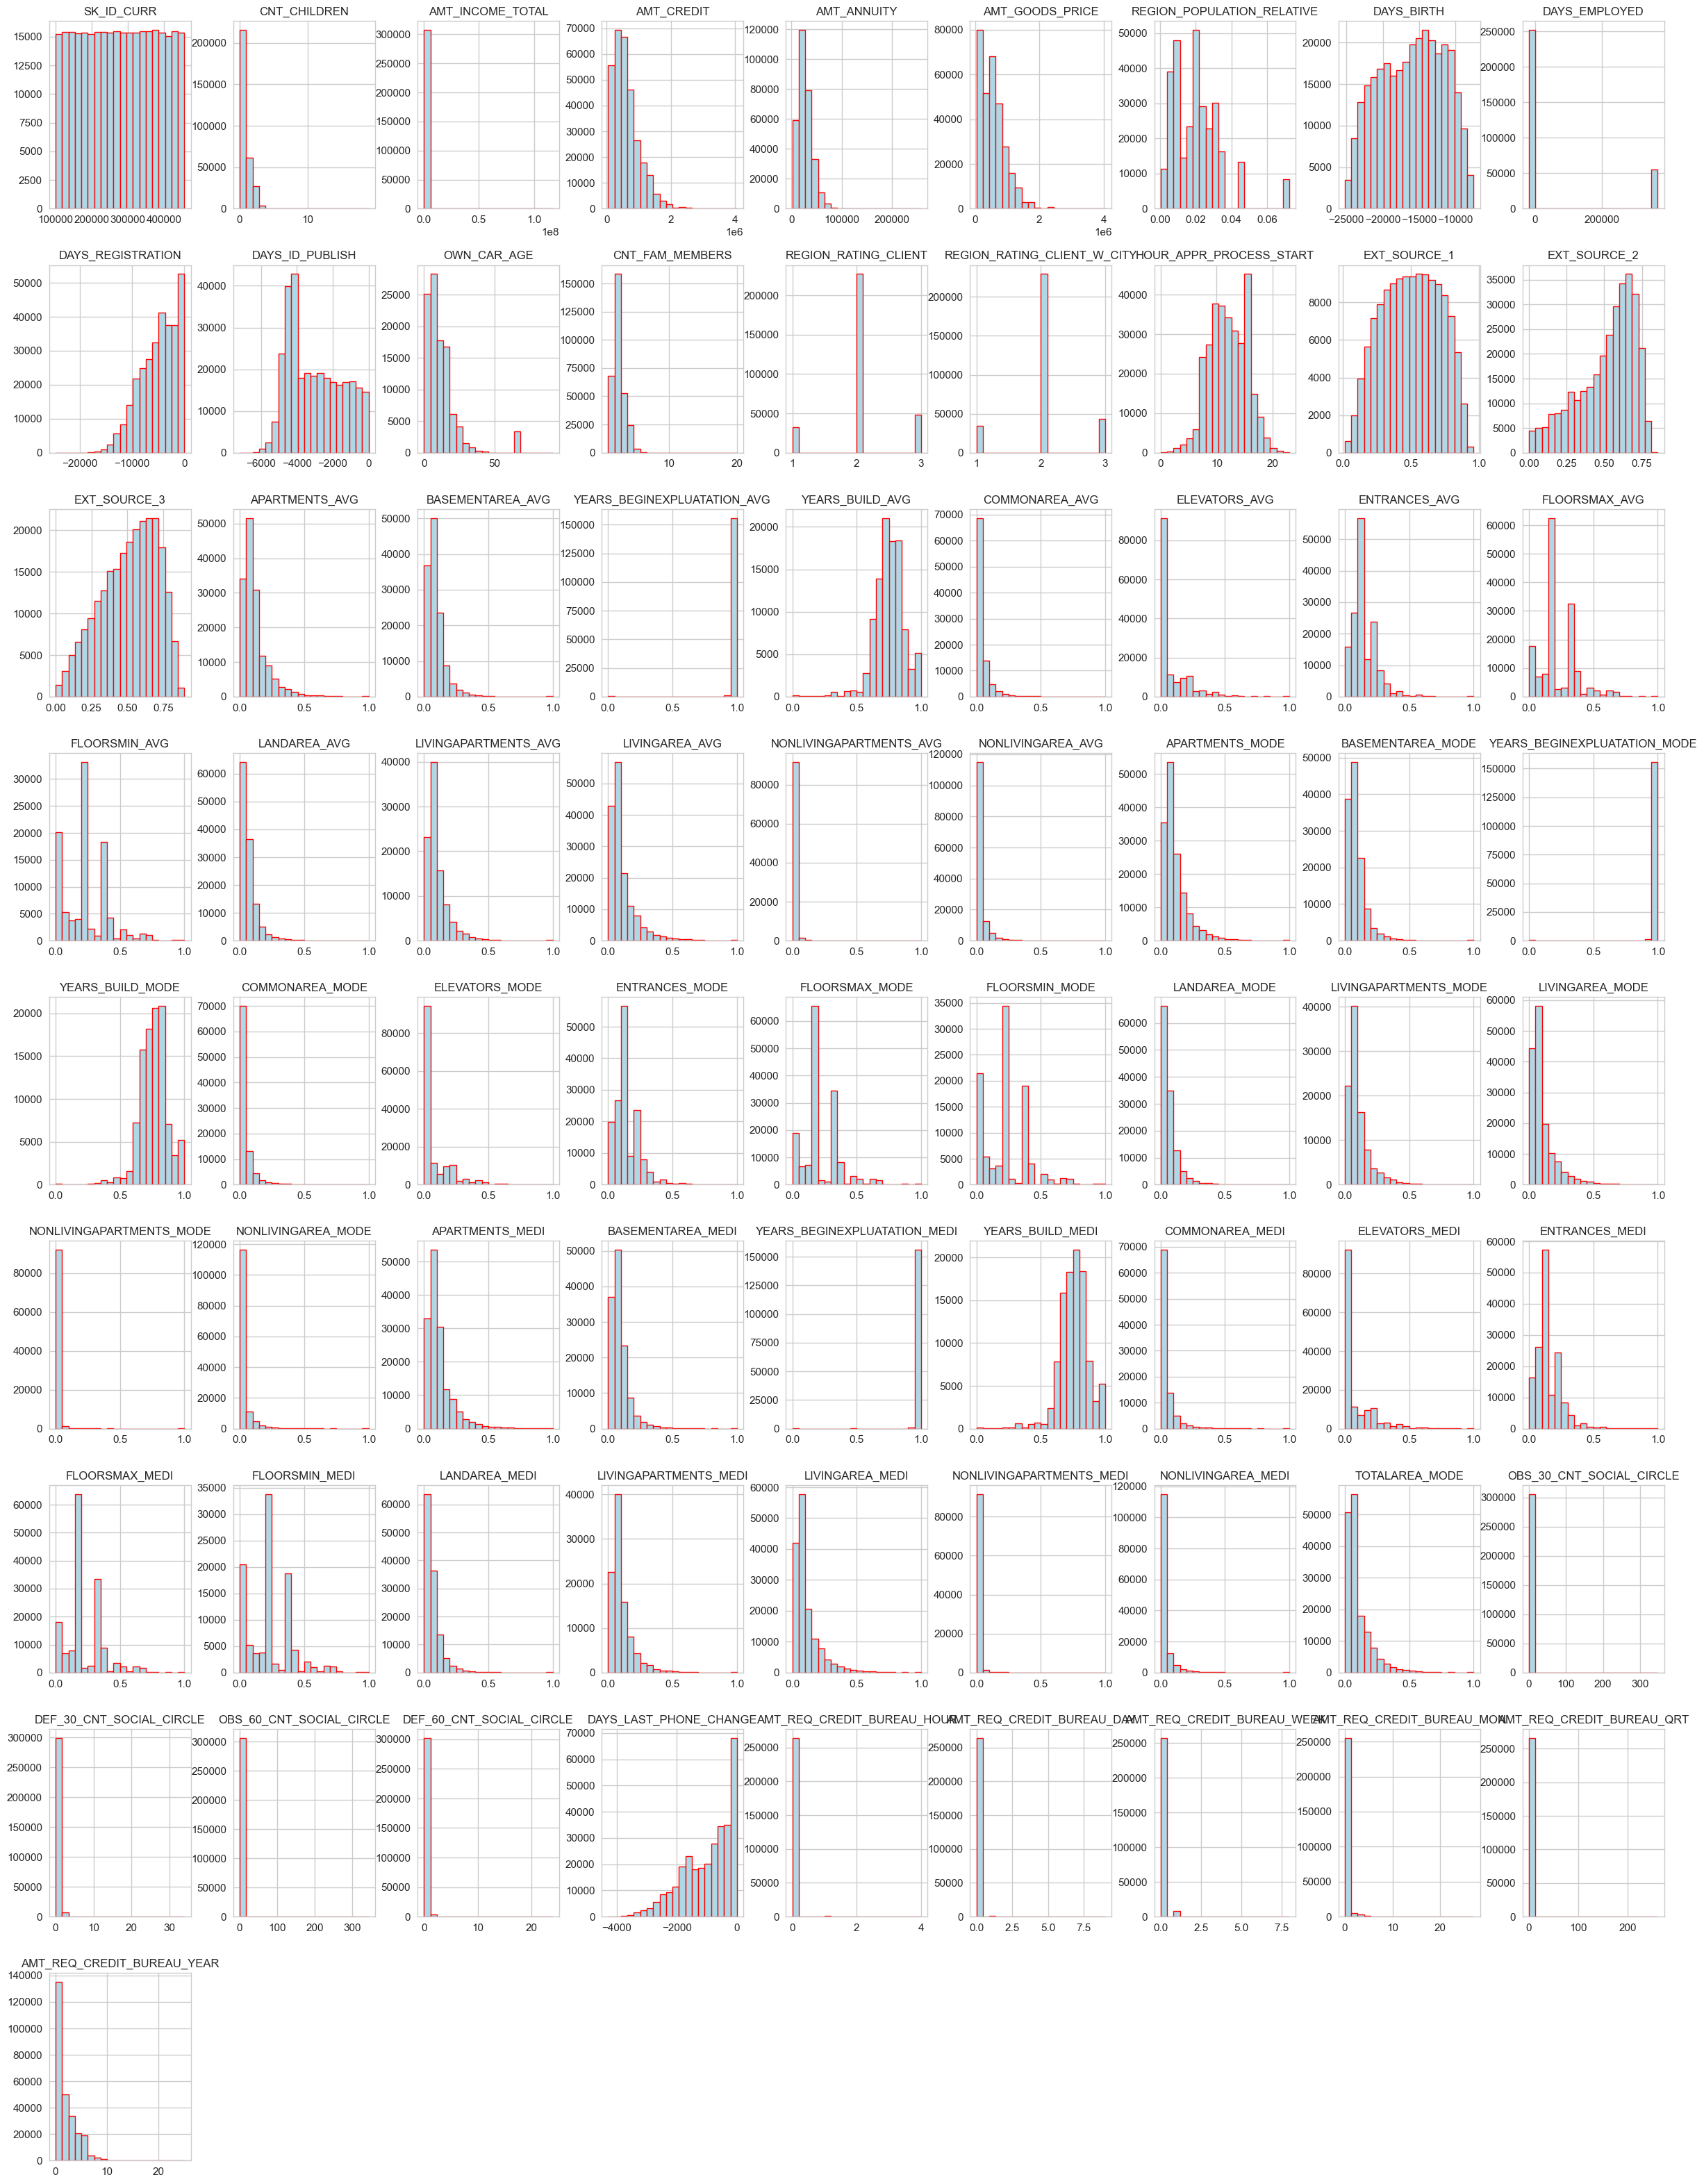


DATASET: aptest



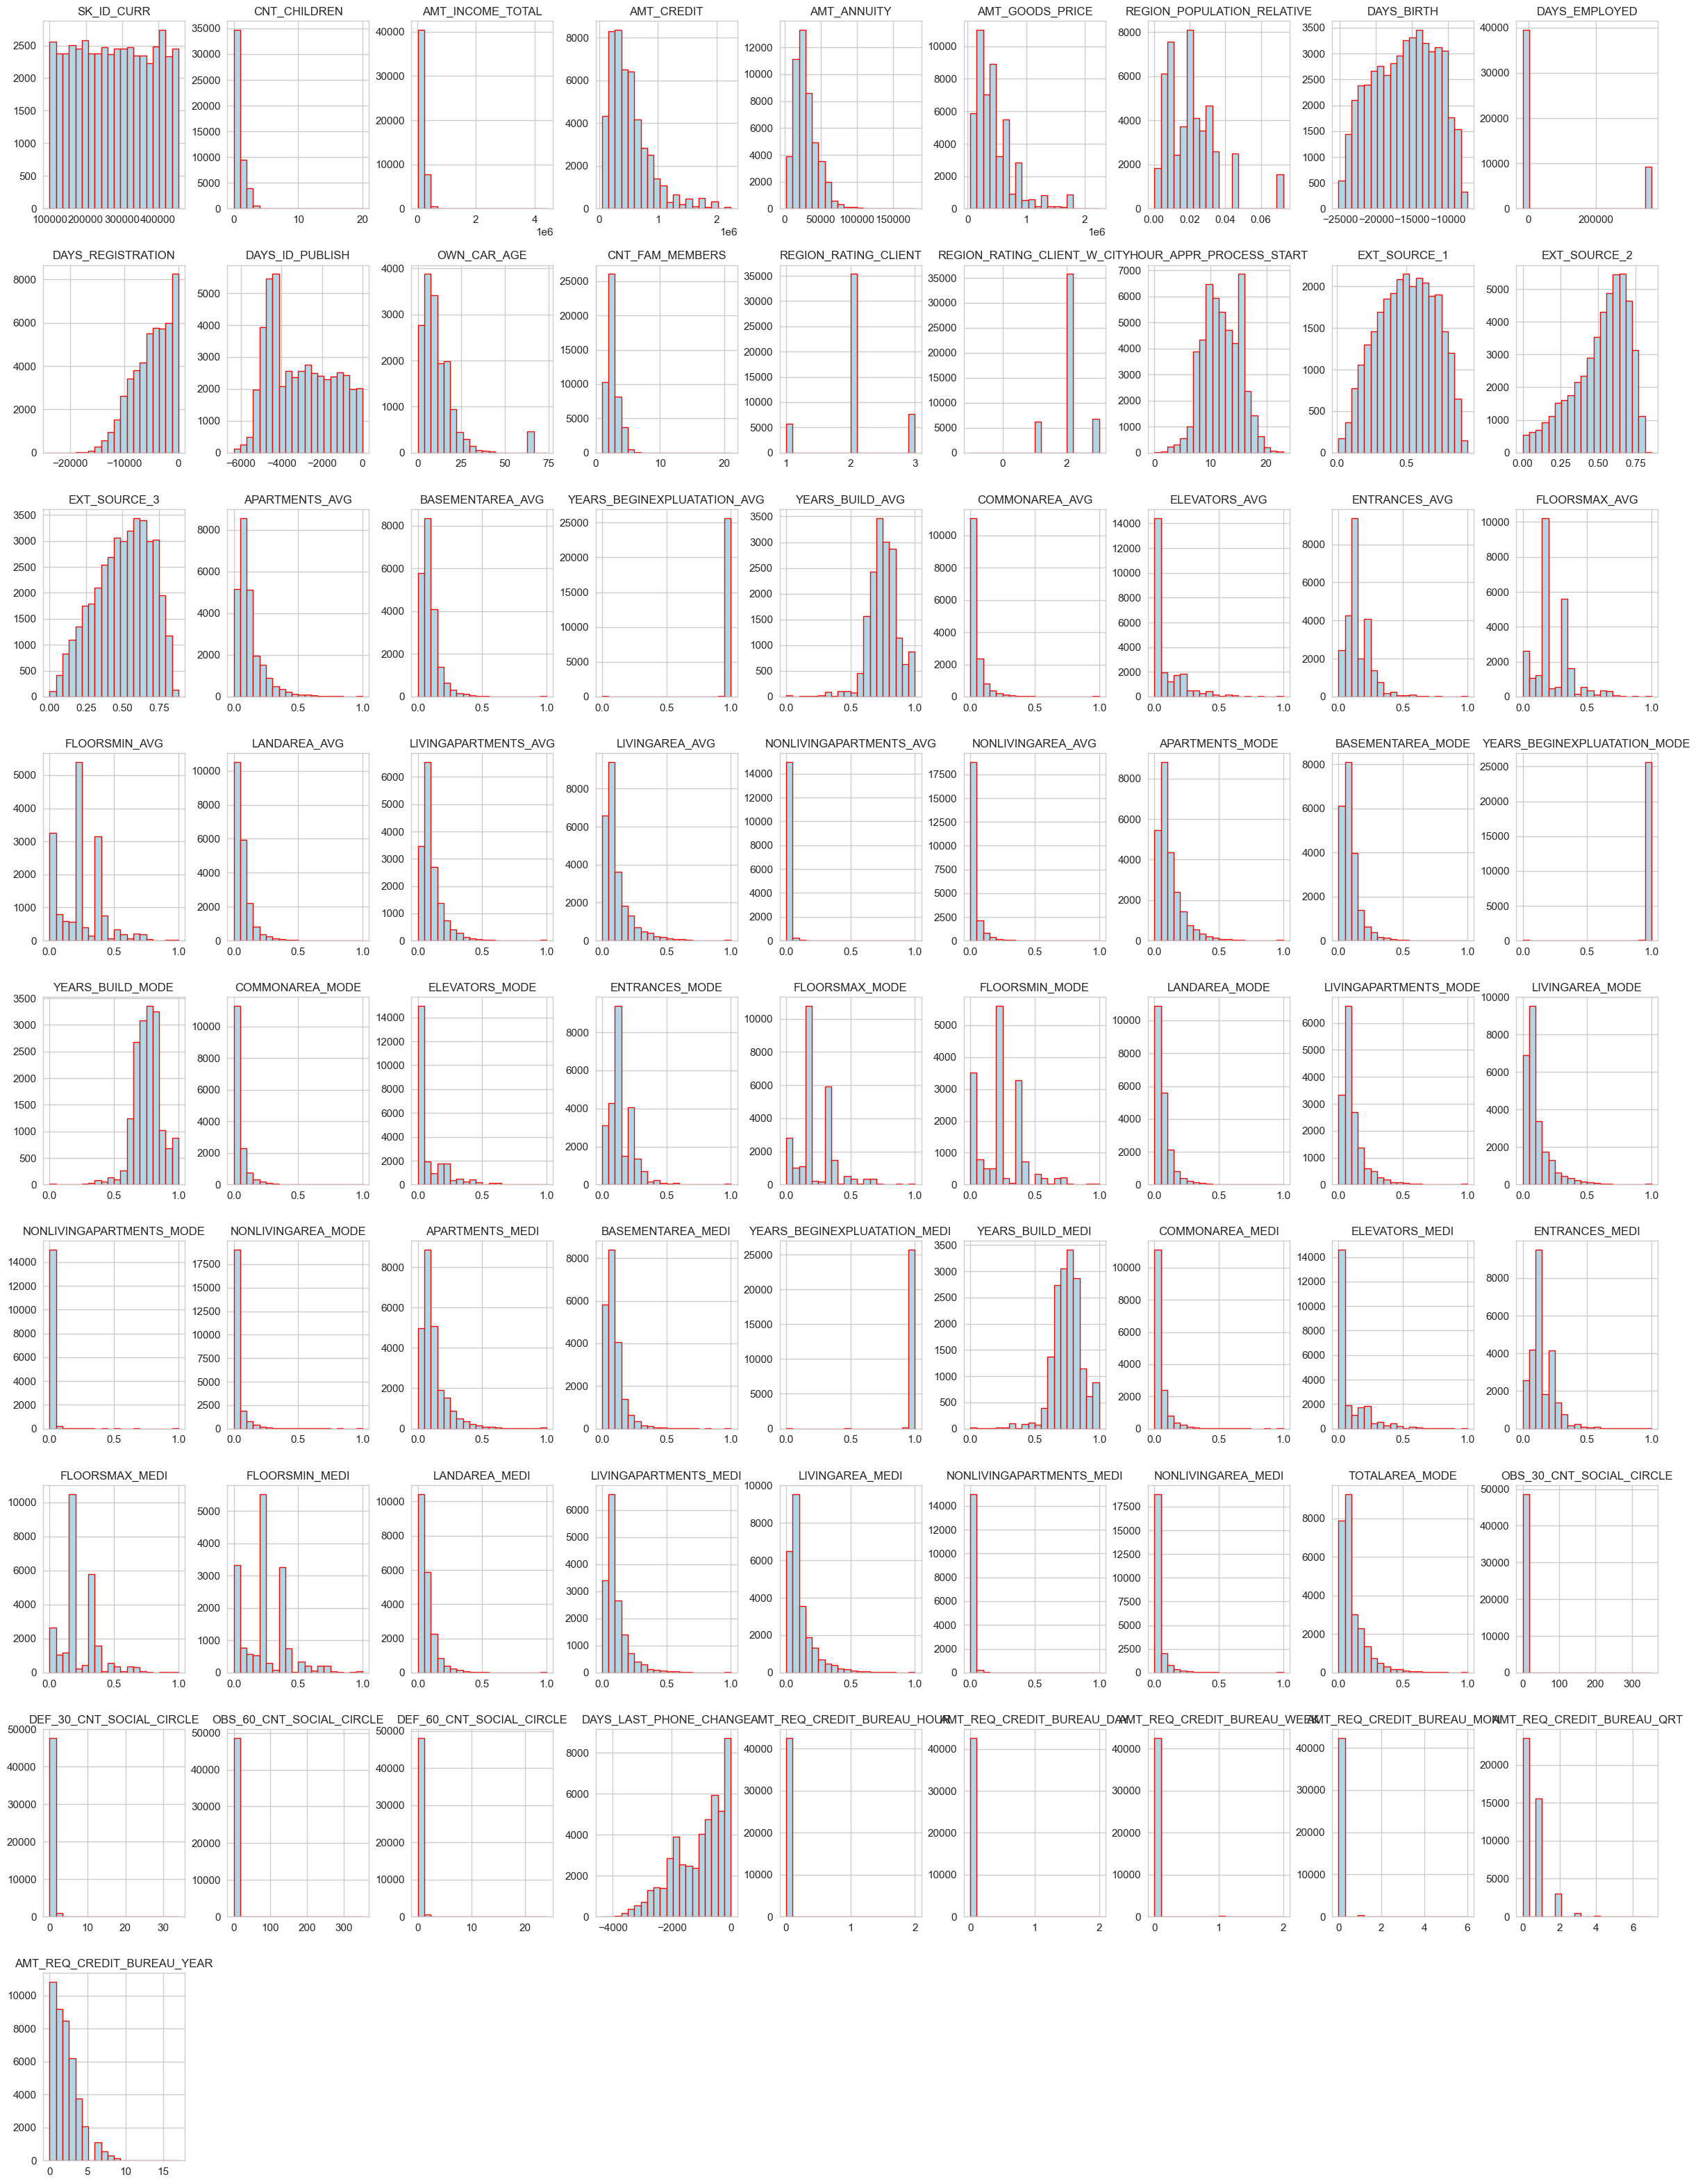


DATASET: bureau



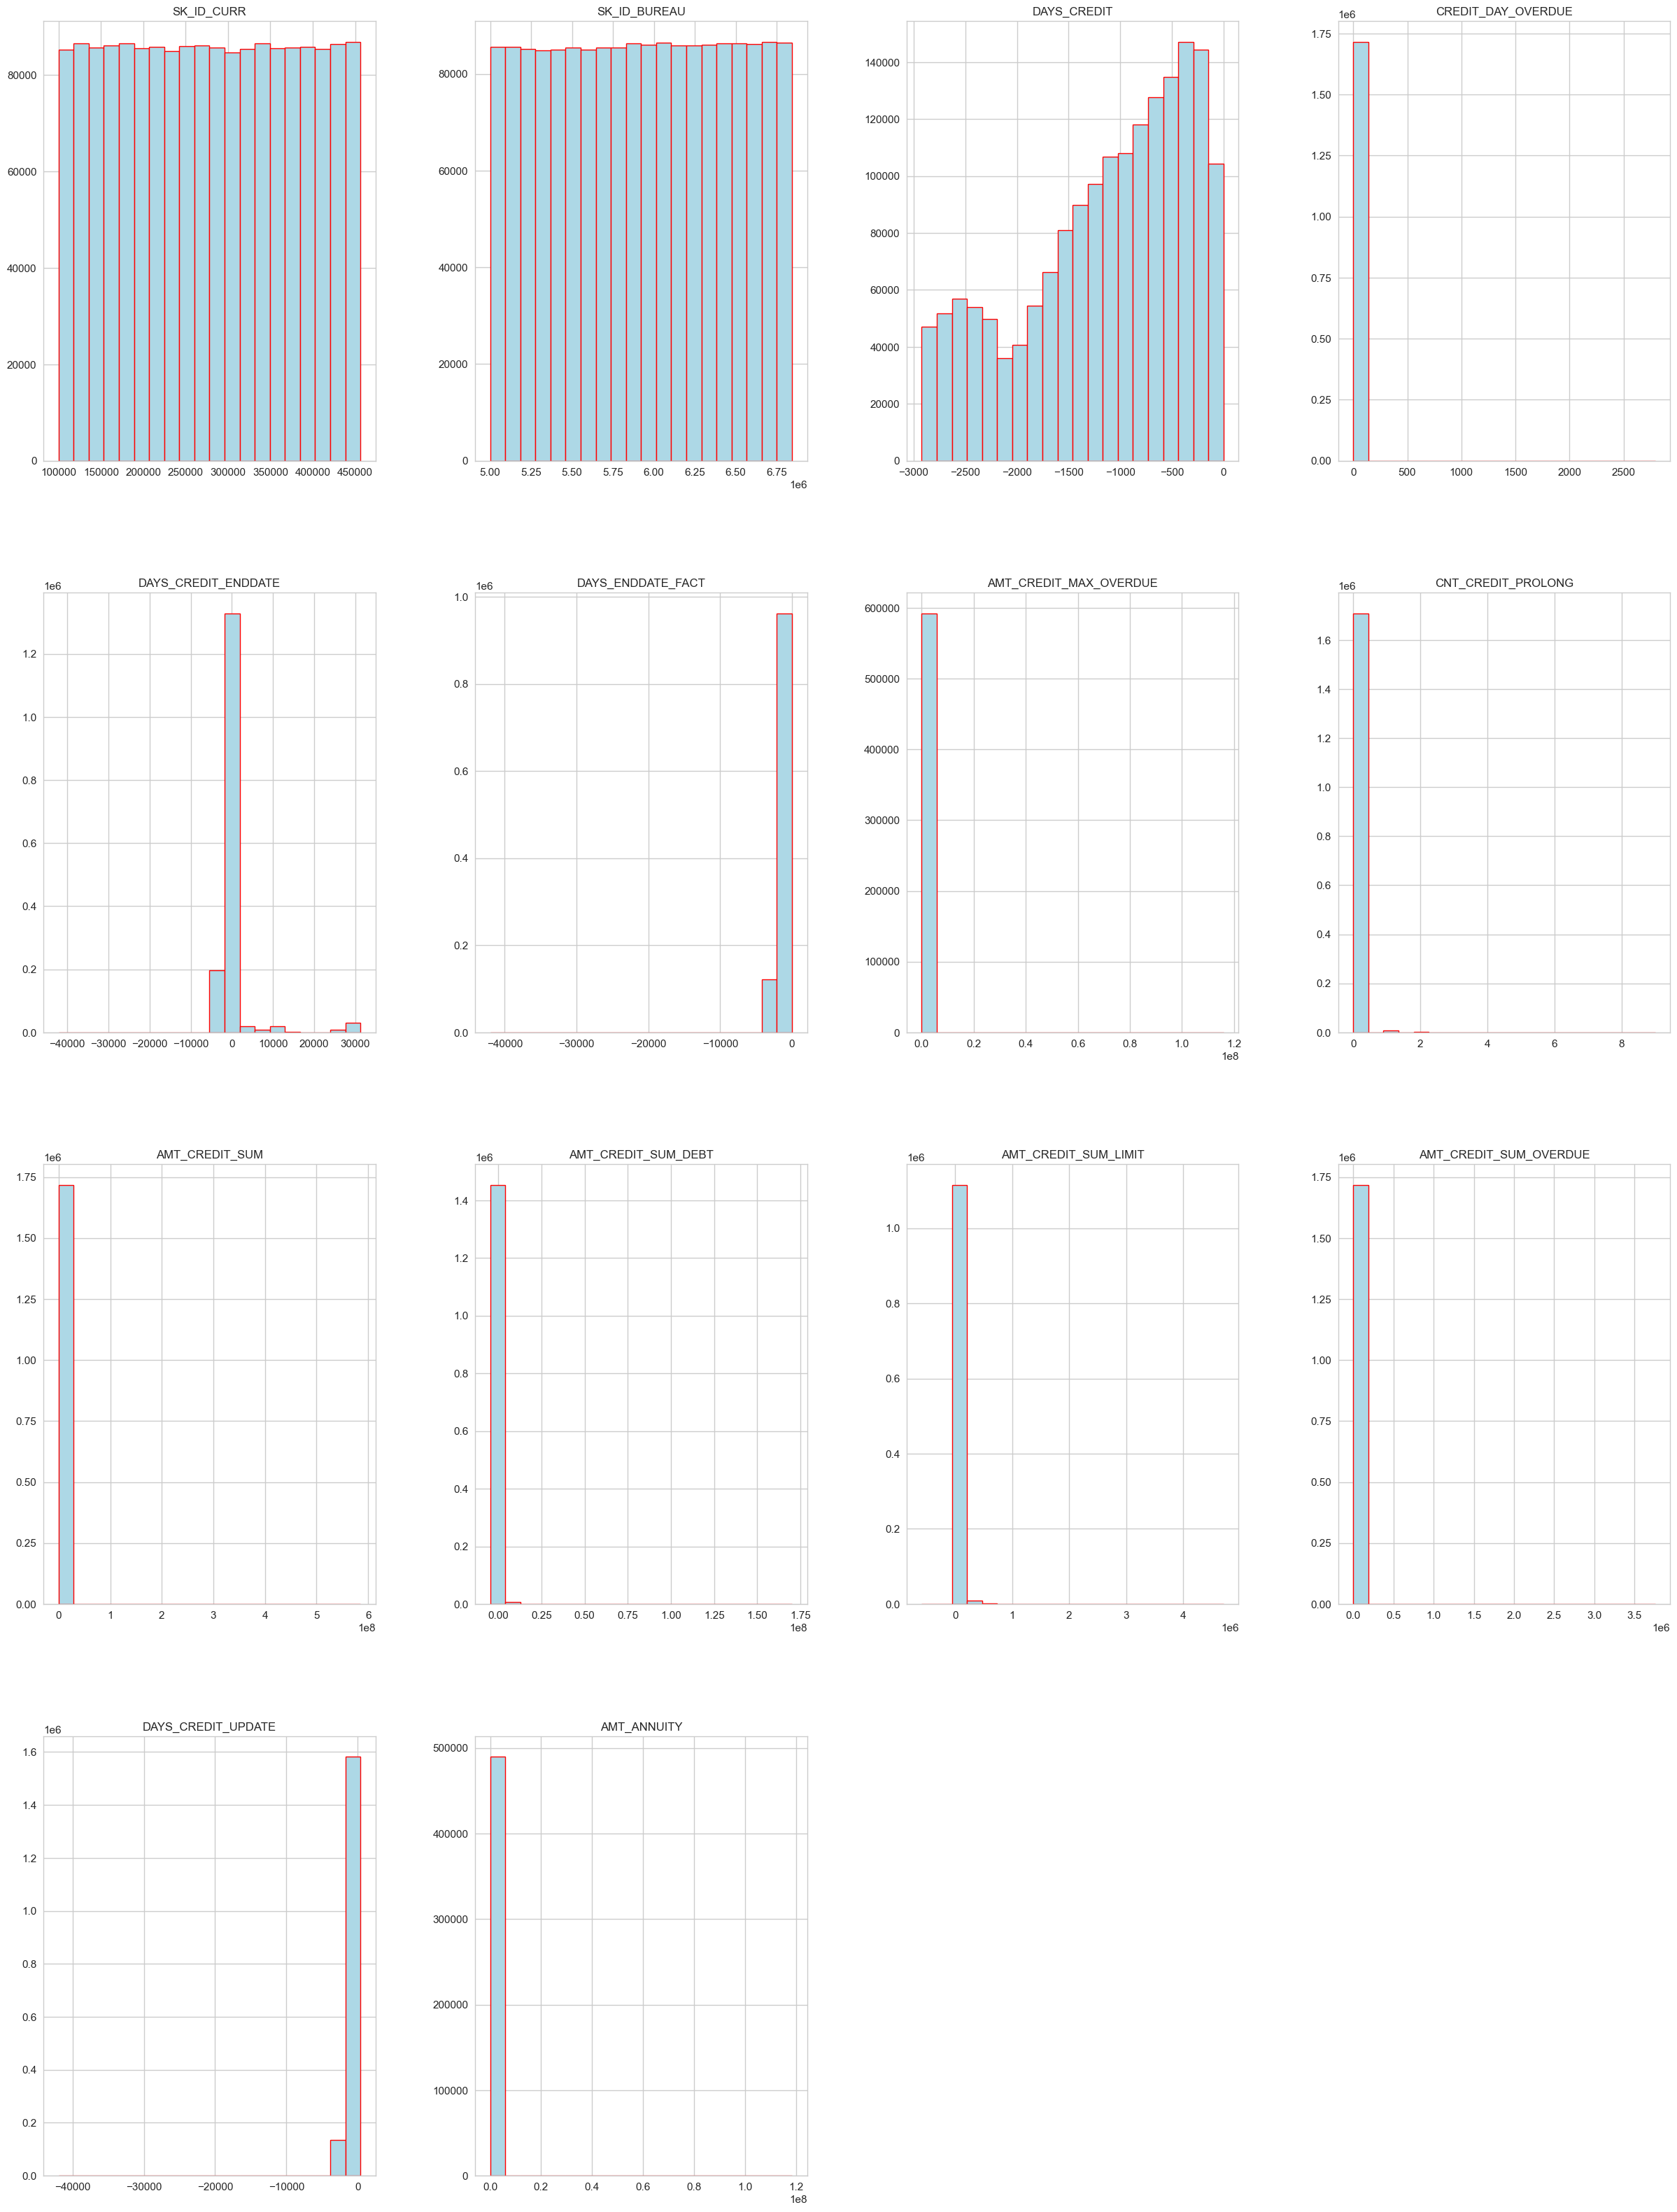


DATASET: bbalance



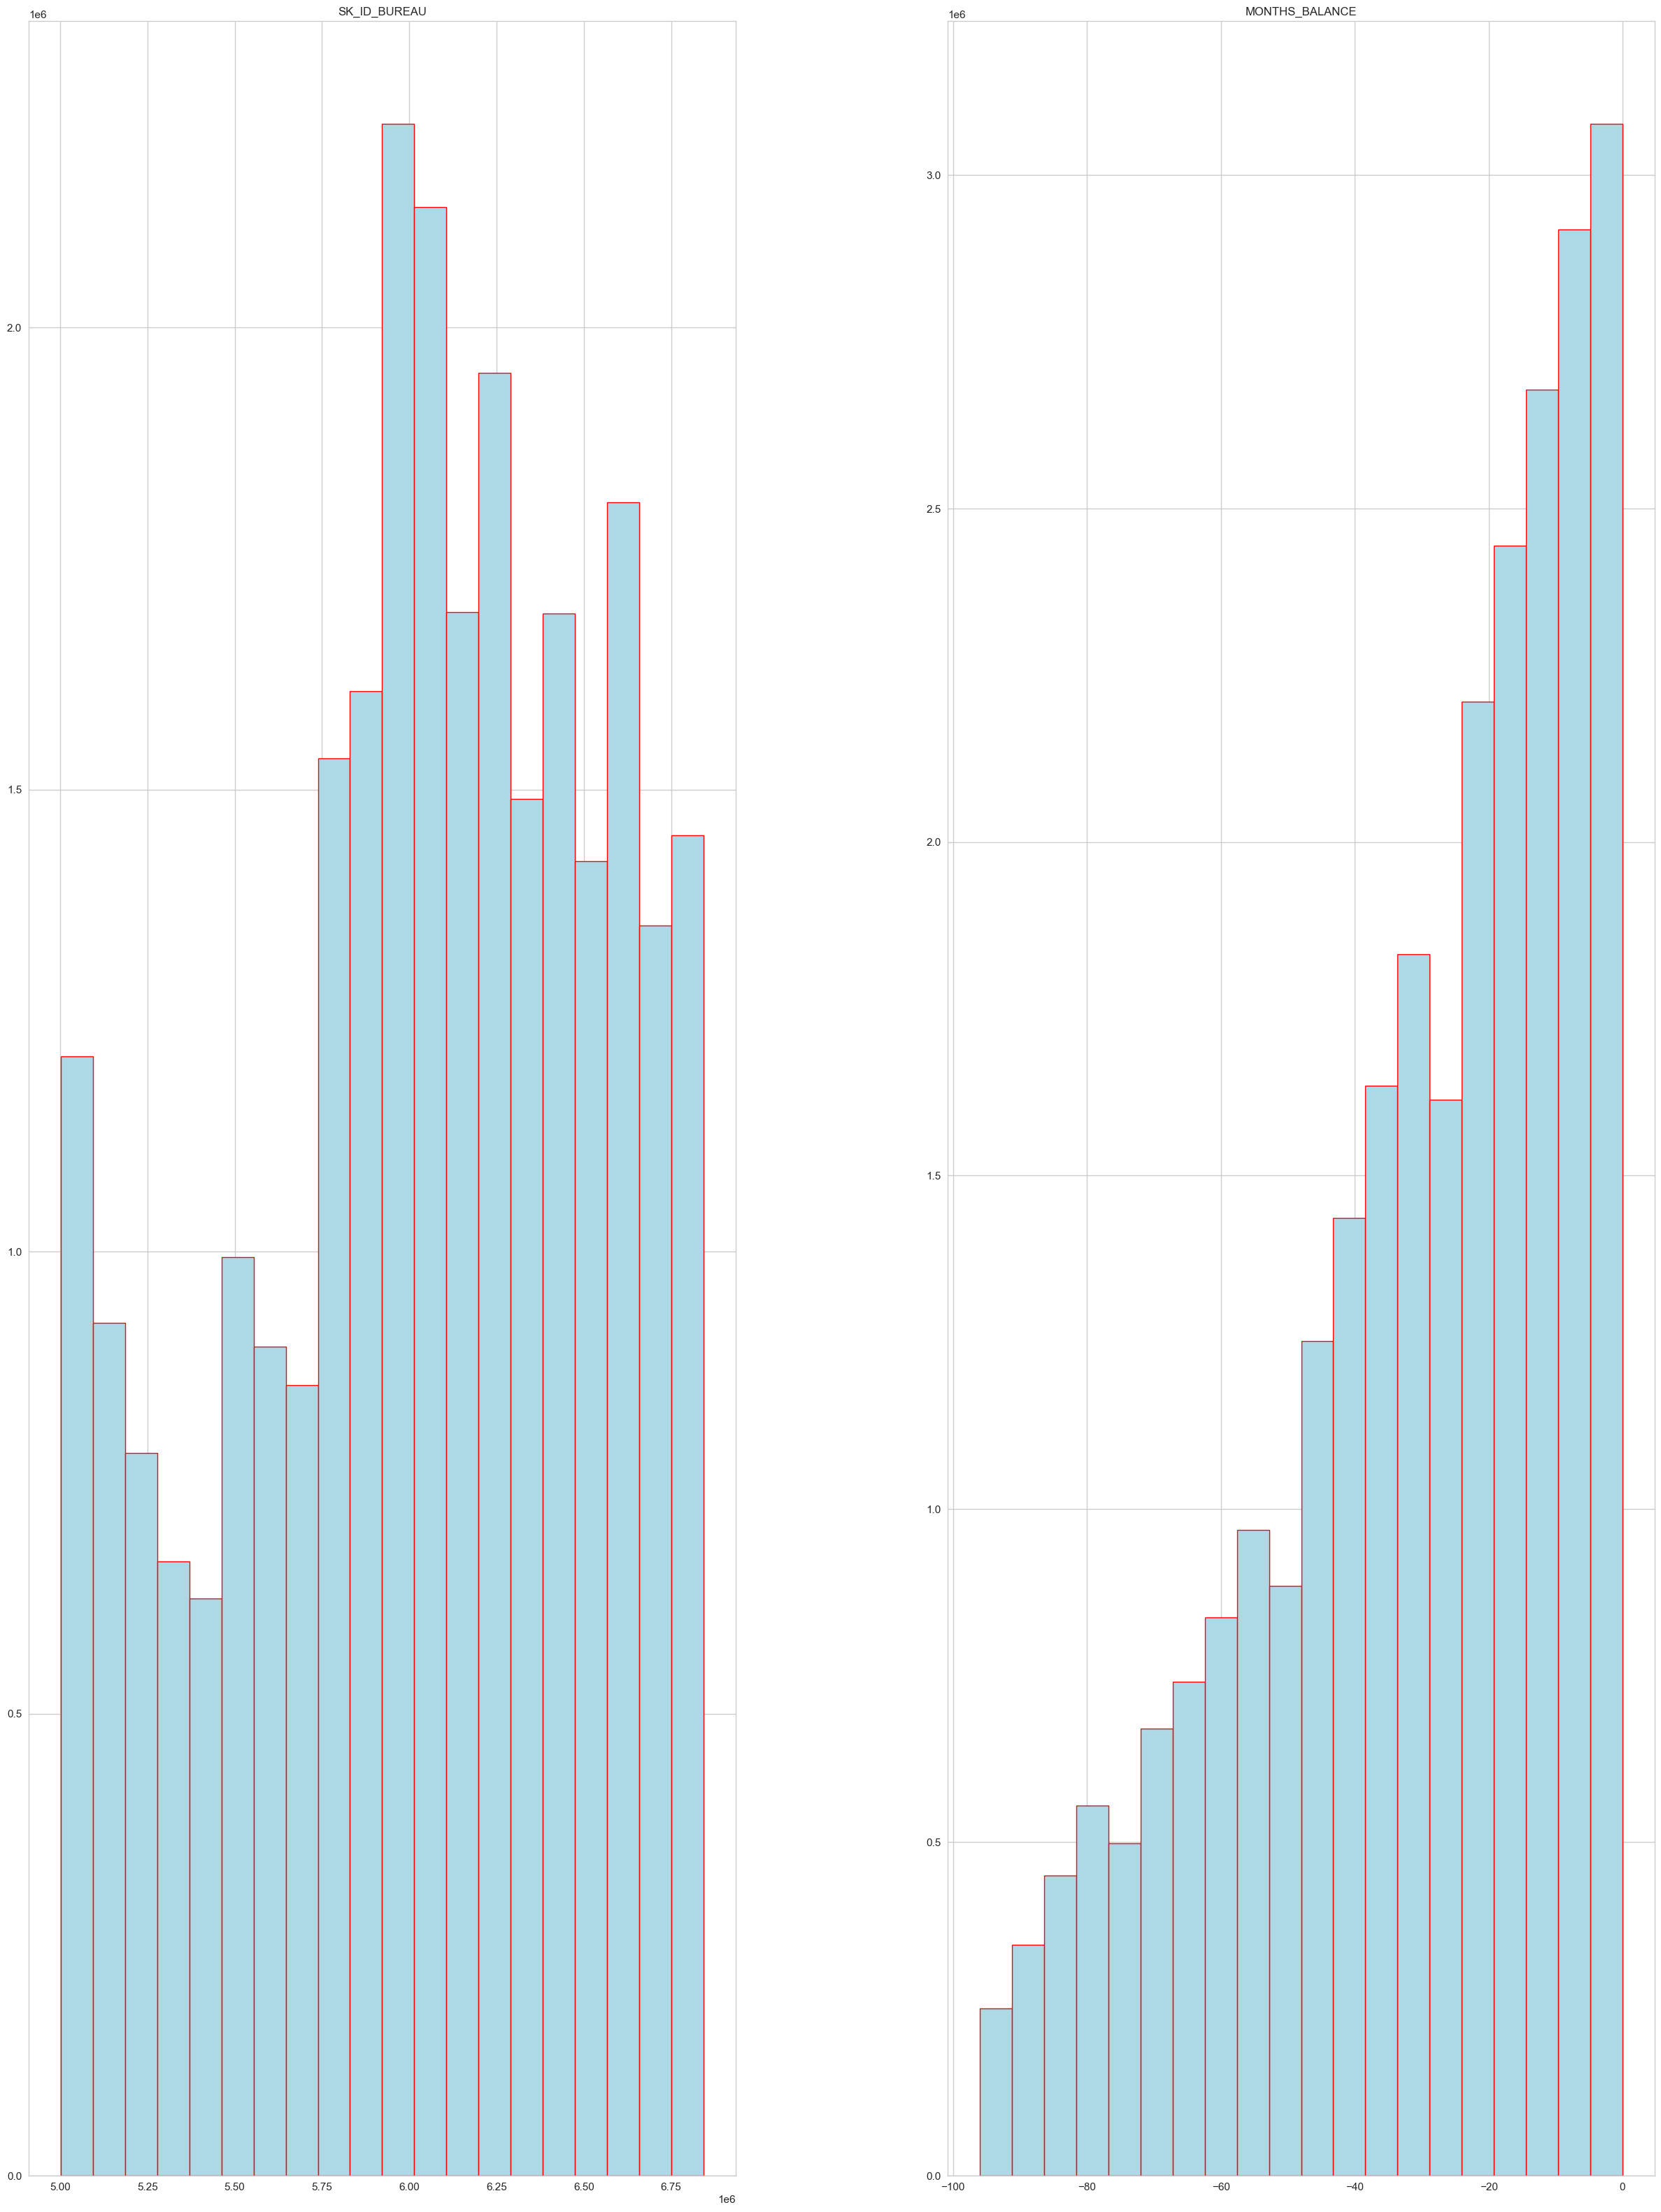


DATASET: pcbalance



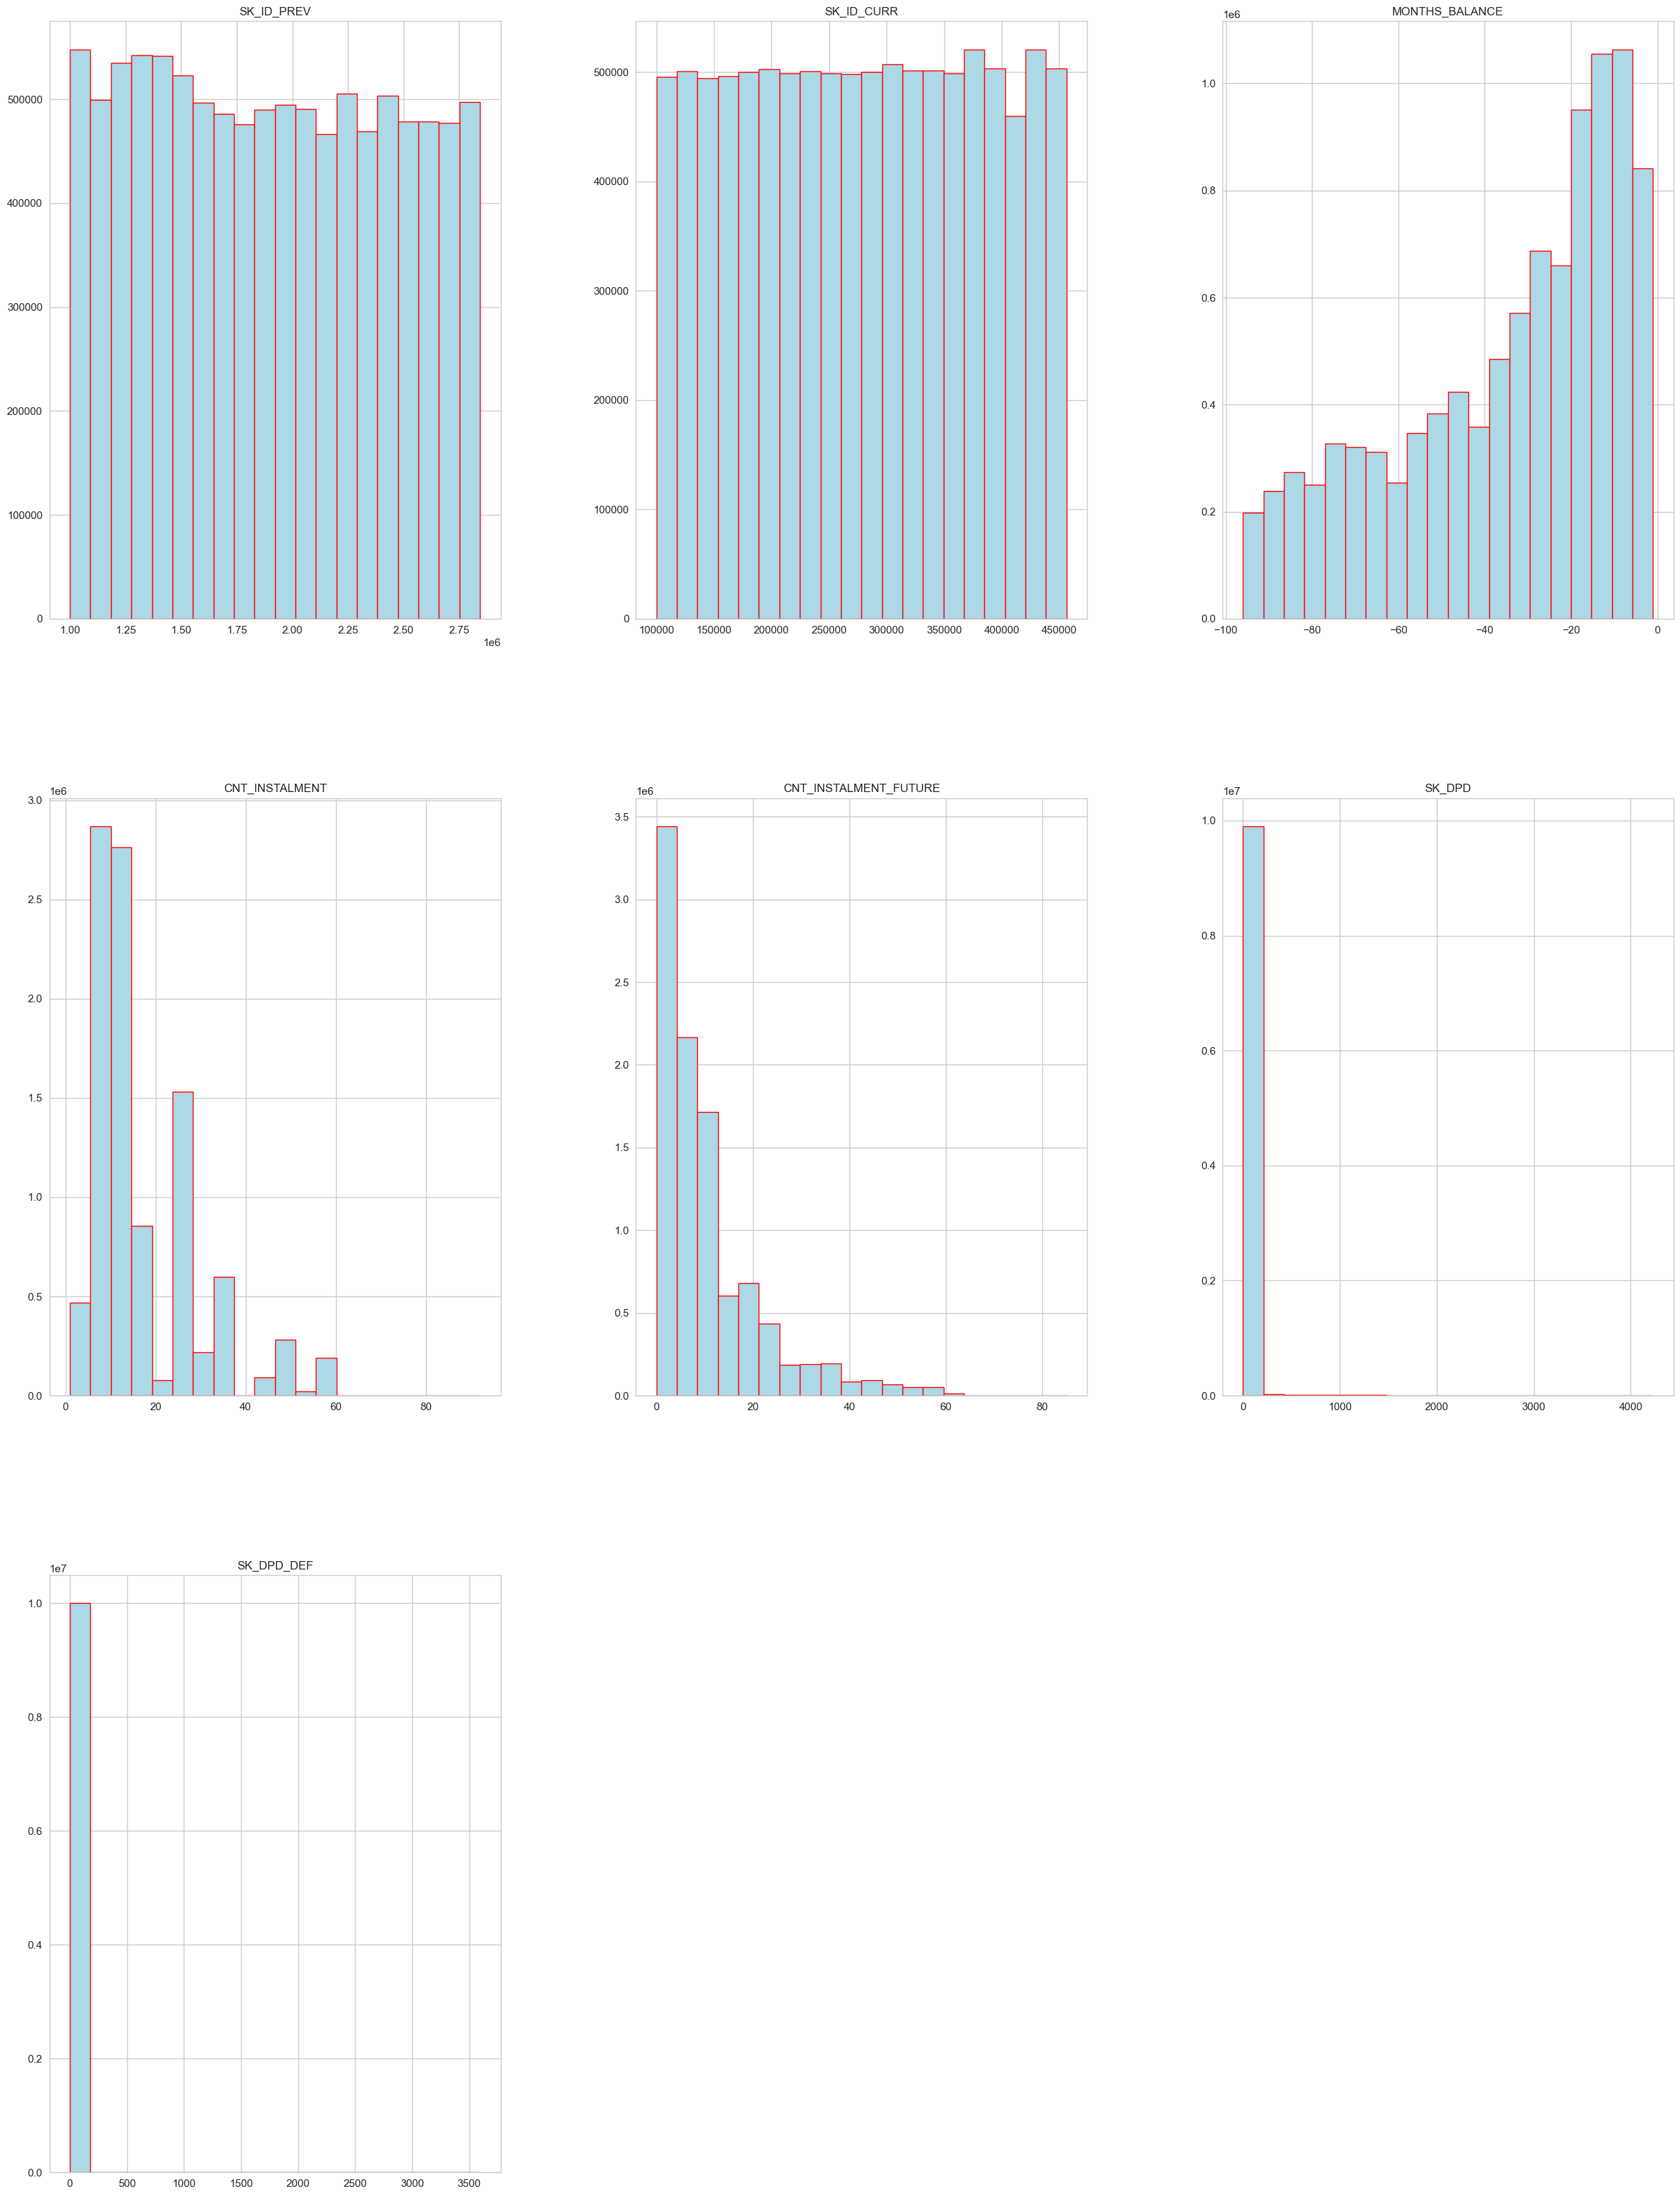


DATASET: bbalance



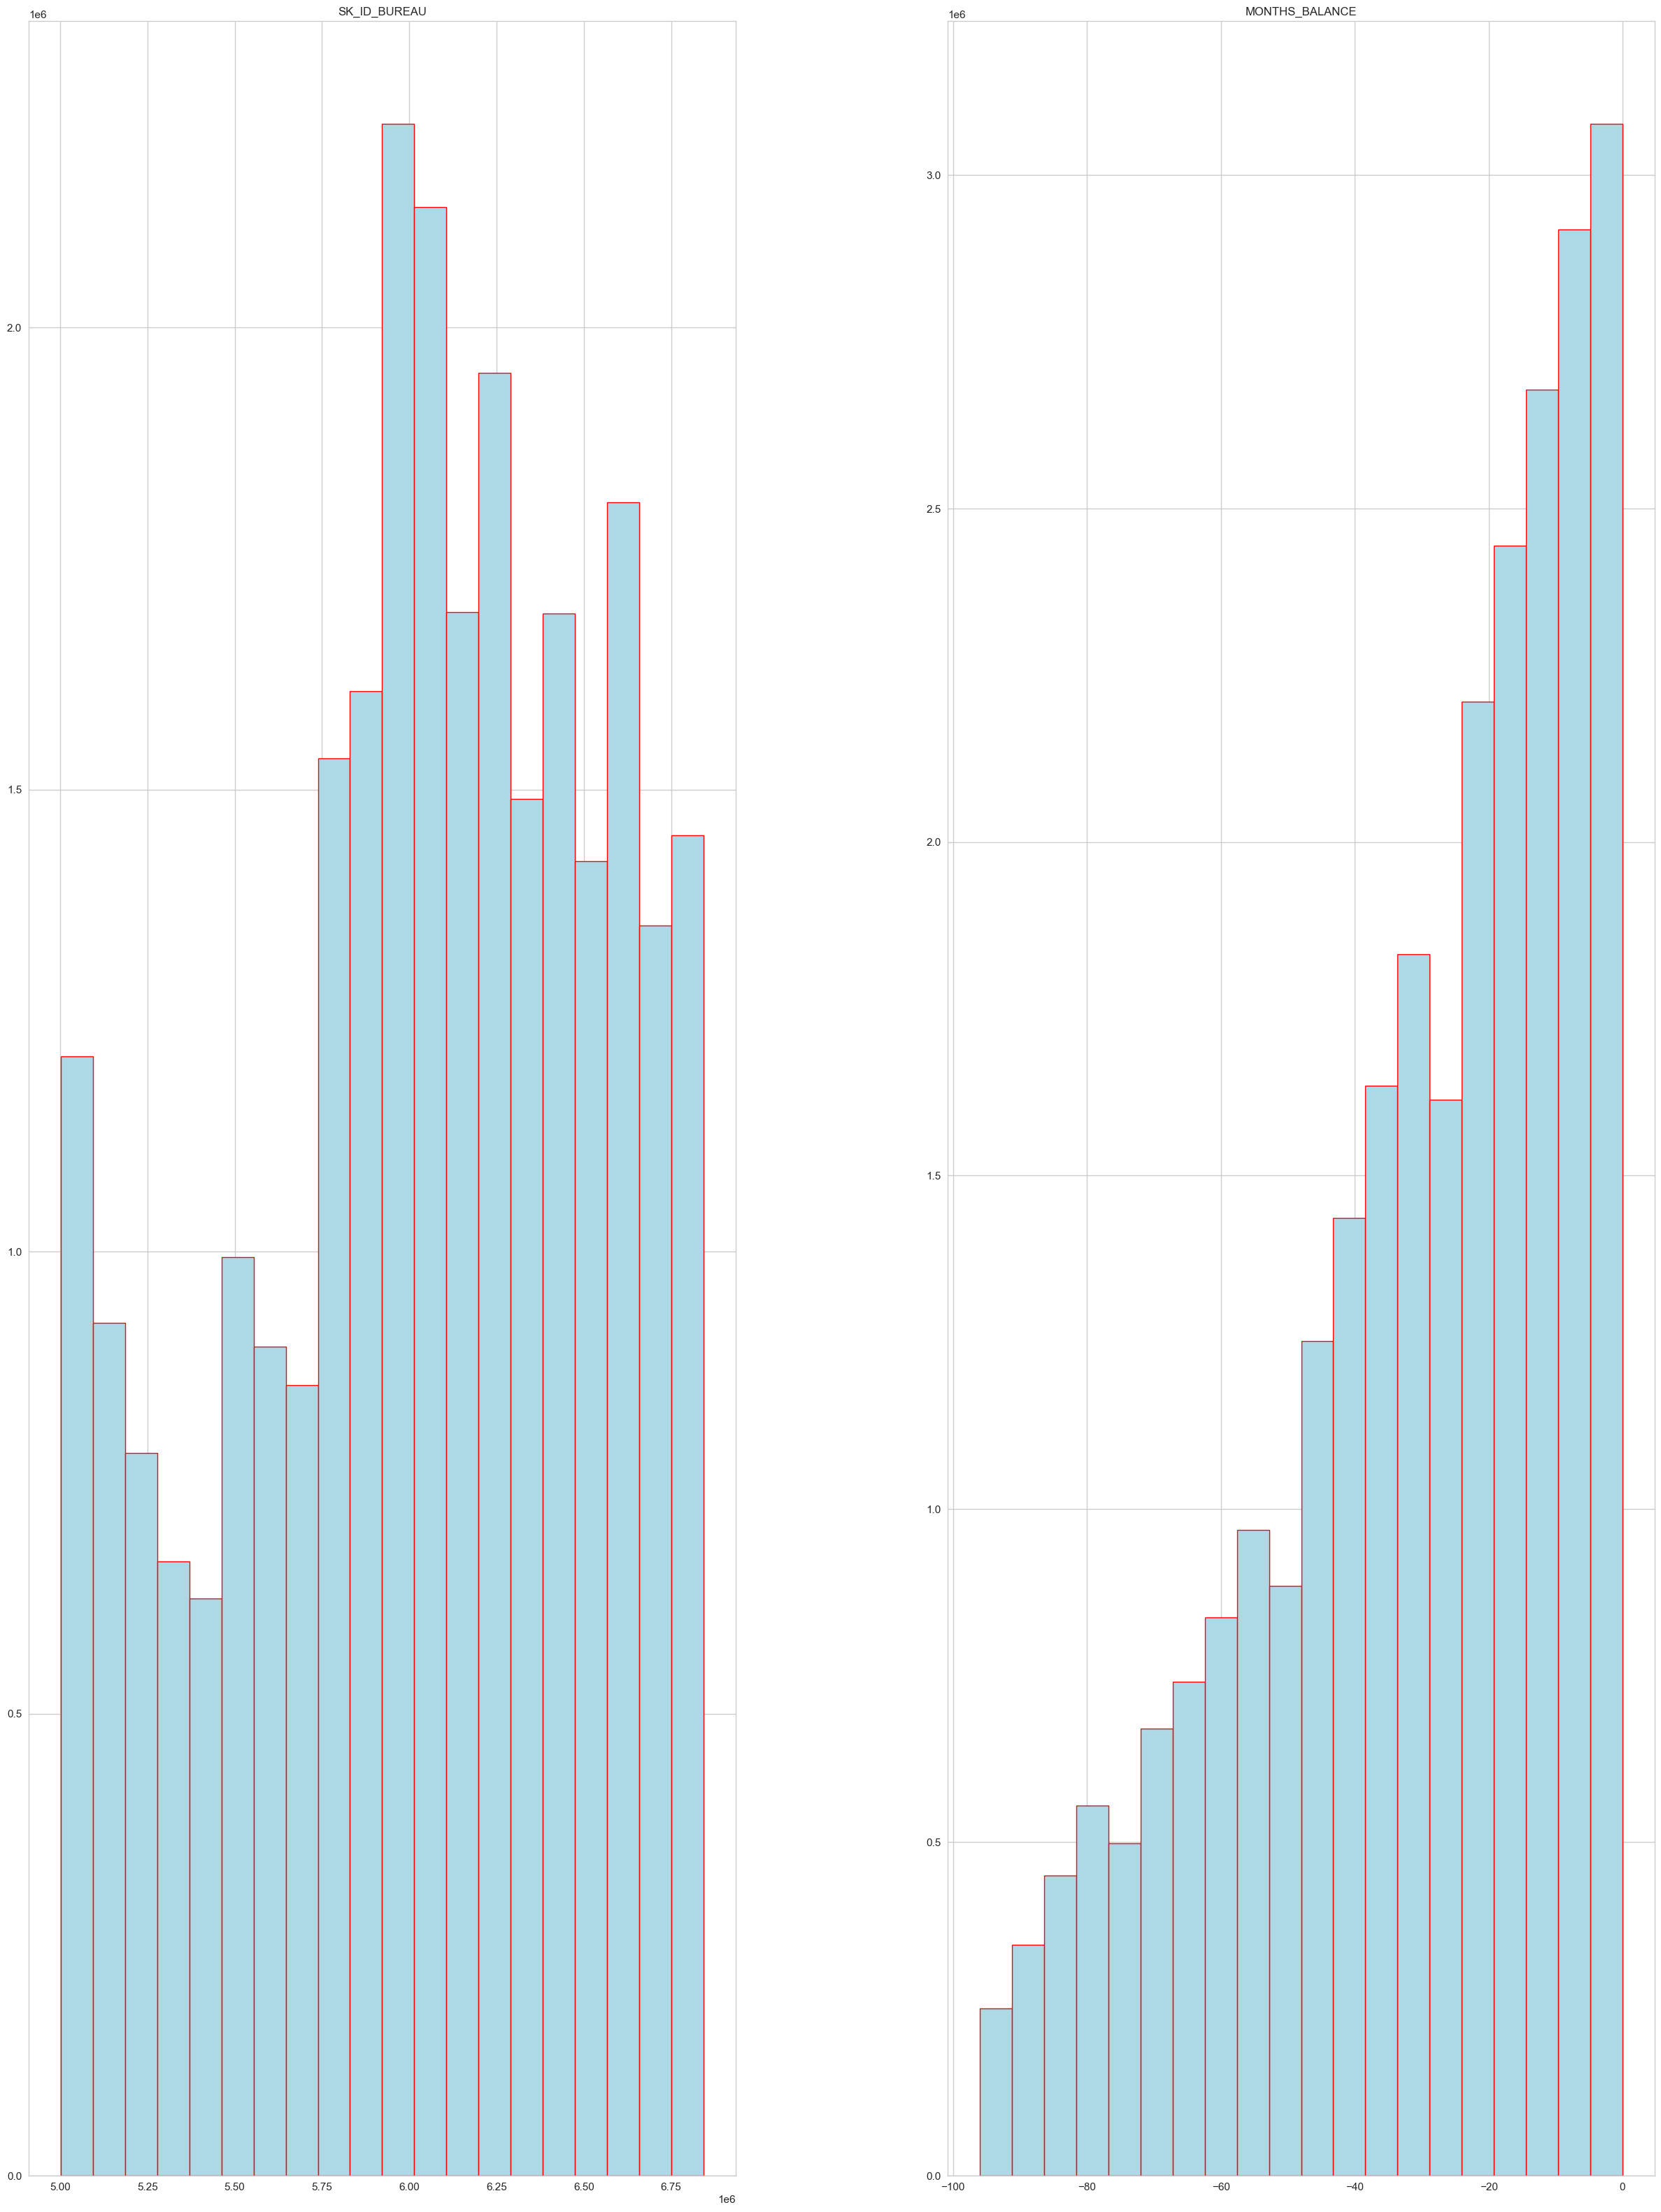


DATASET: ccbalance



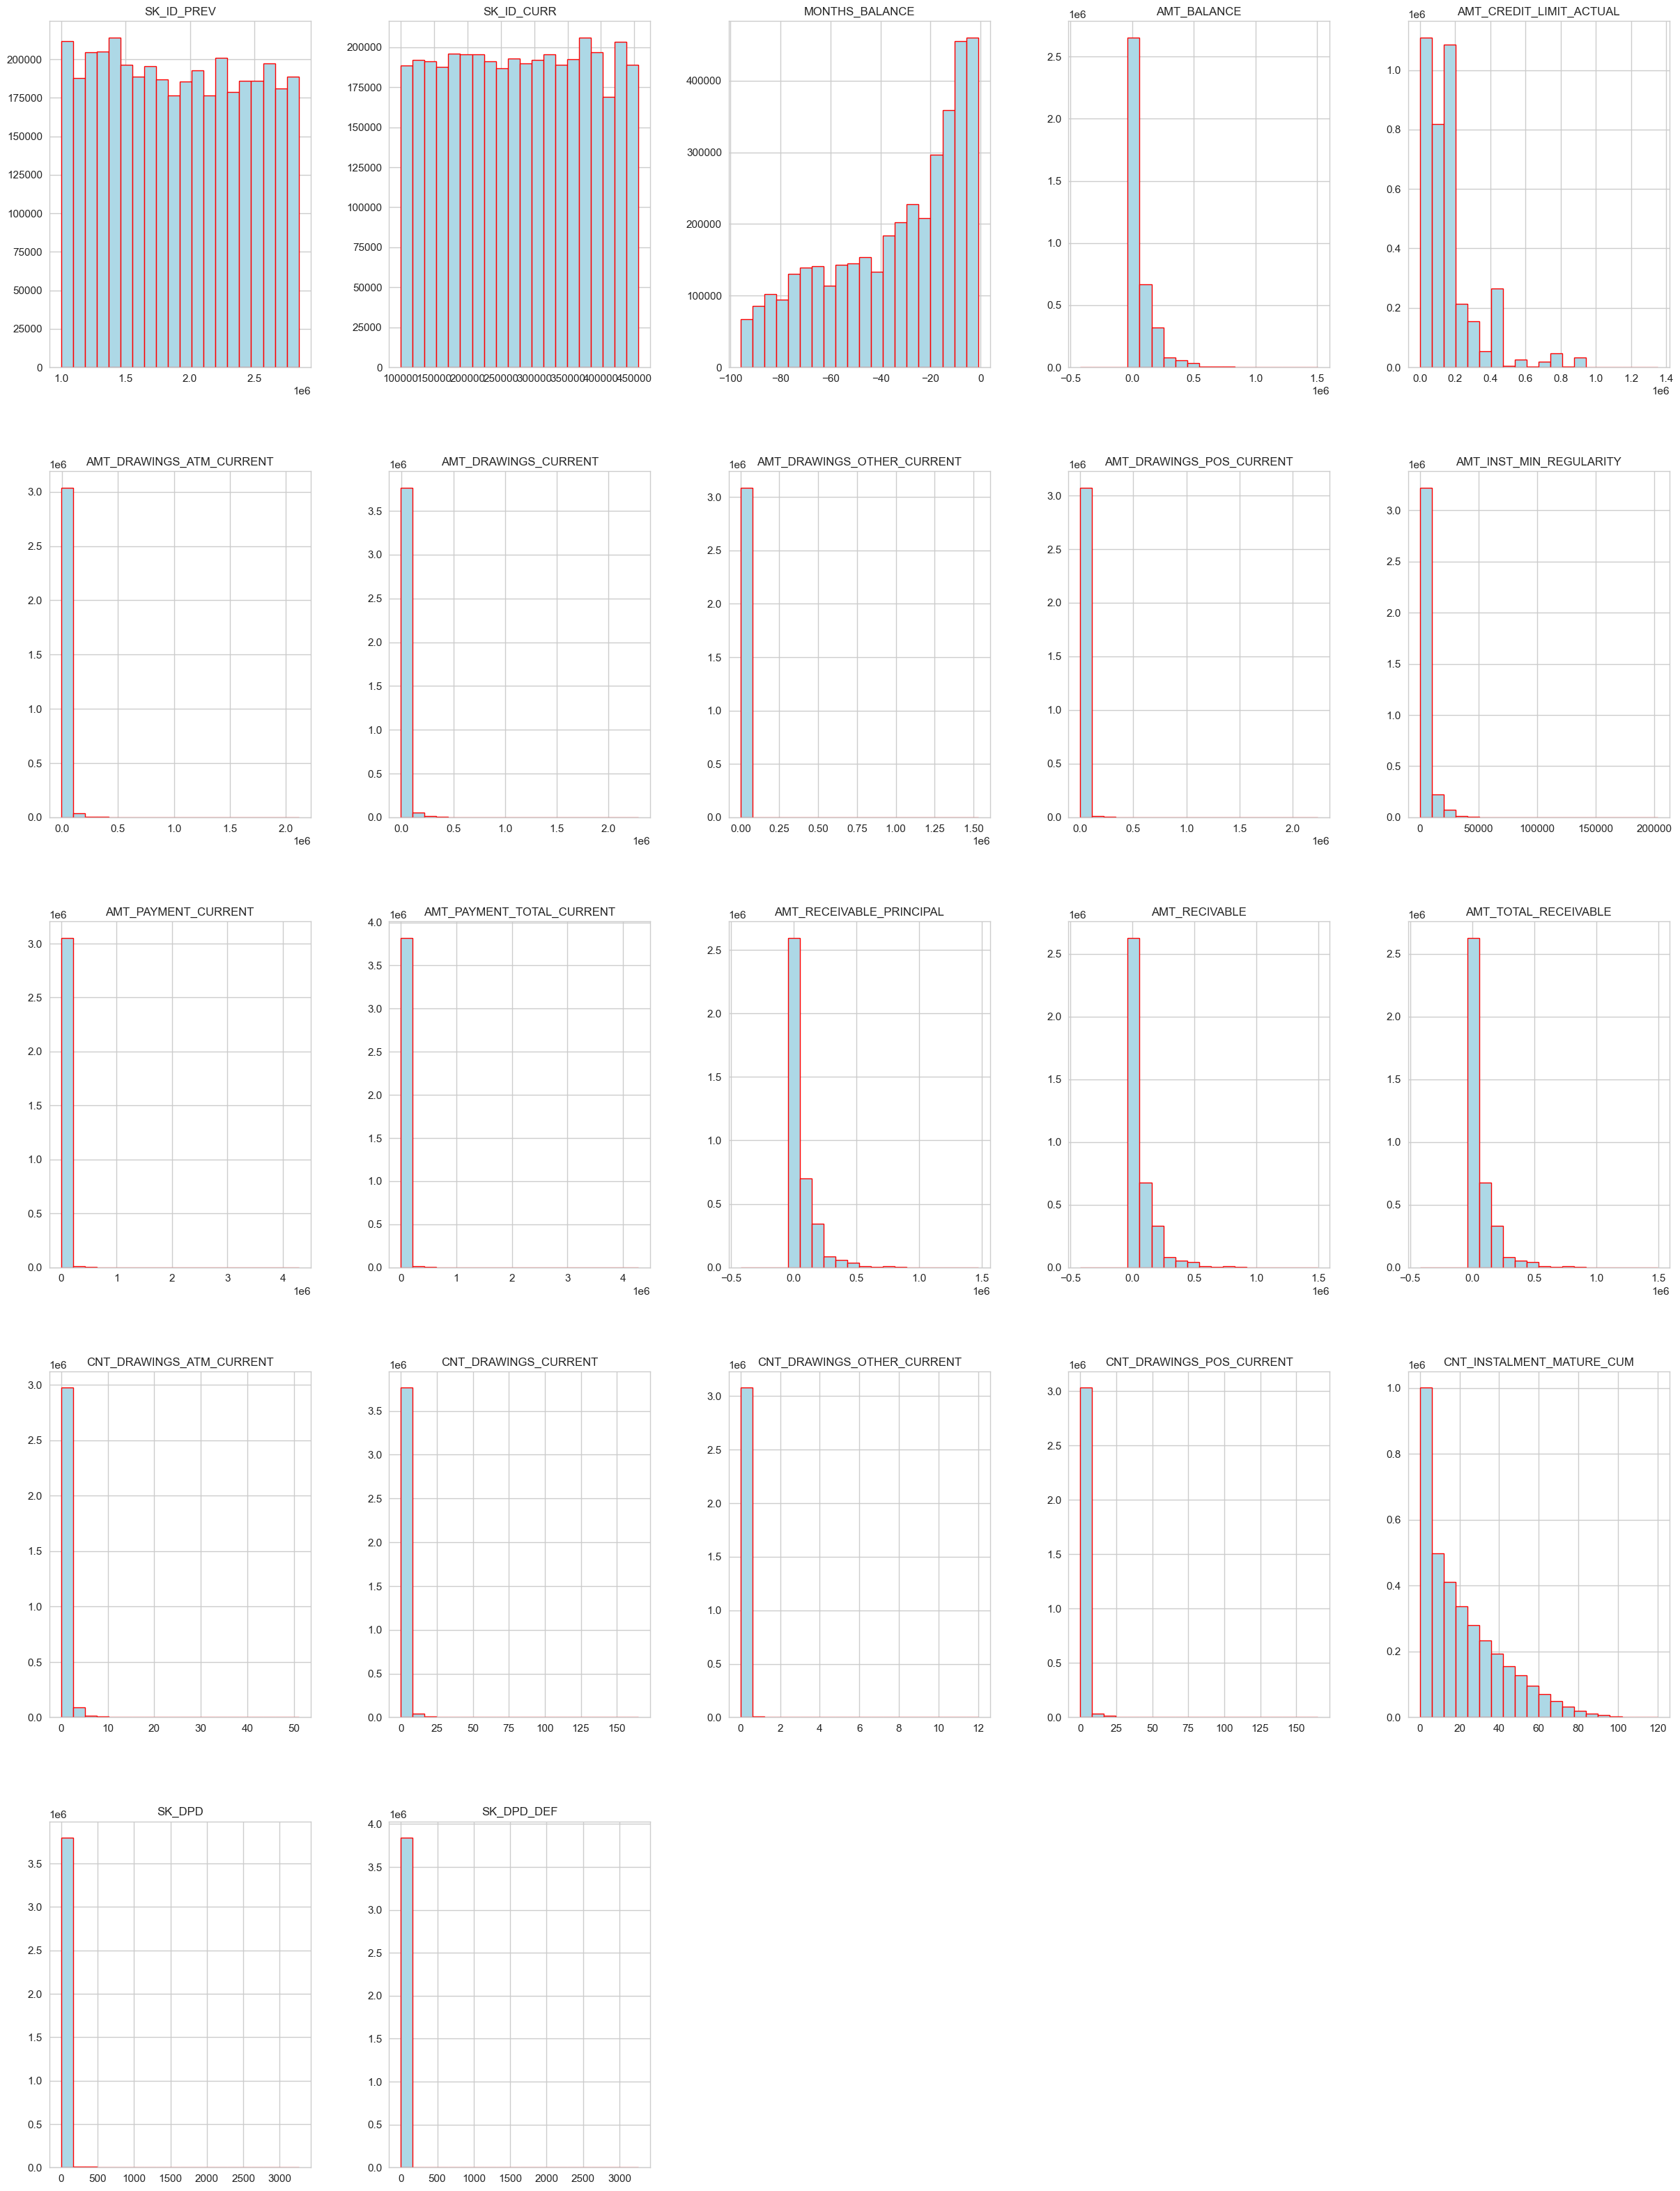


DATASET: instpayments



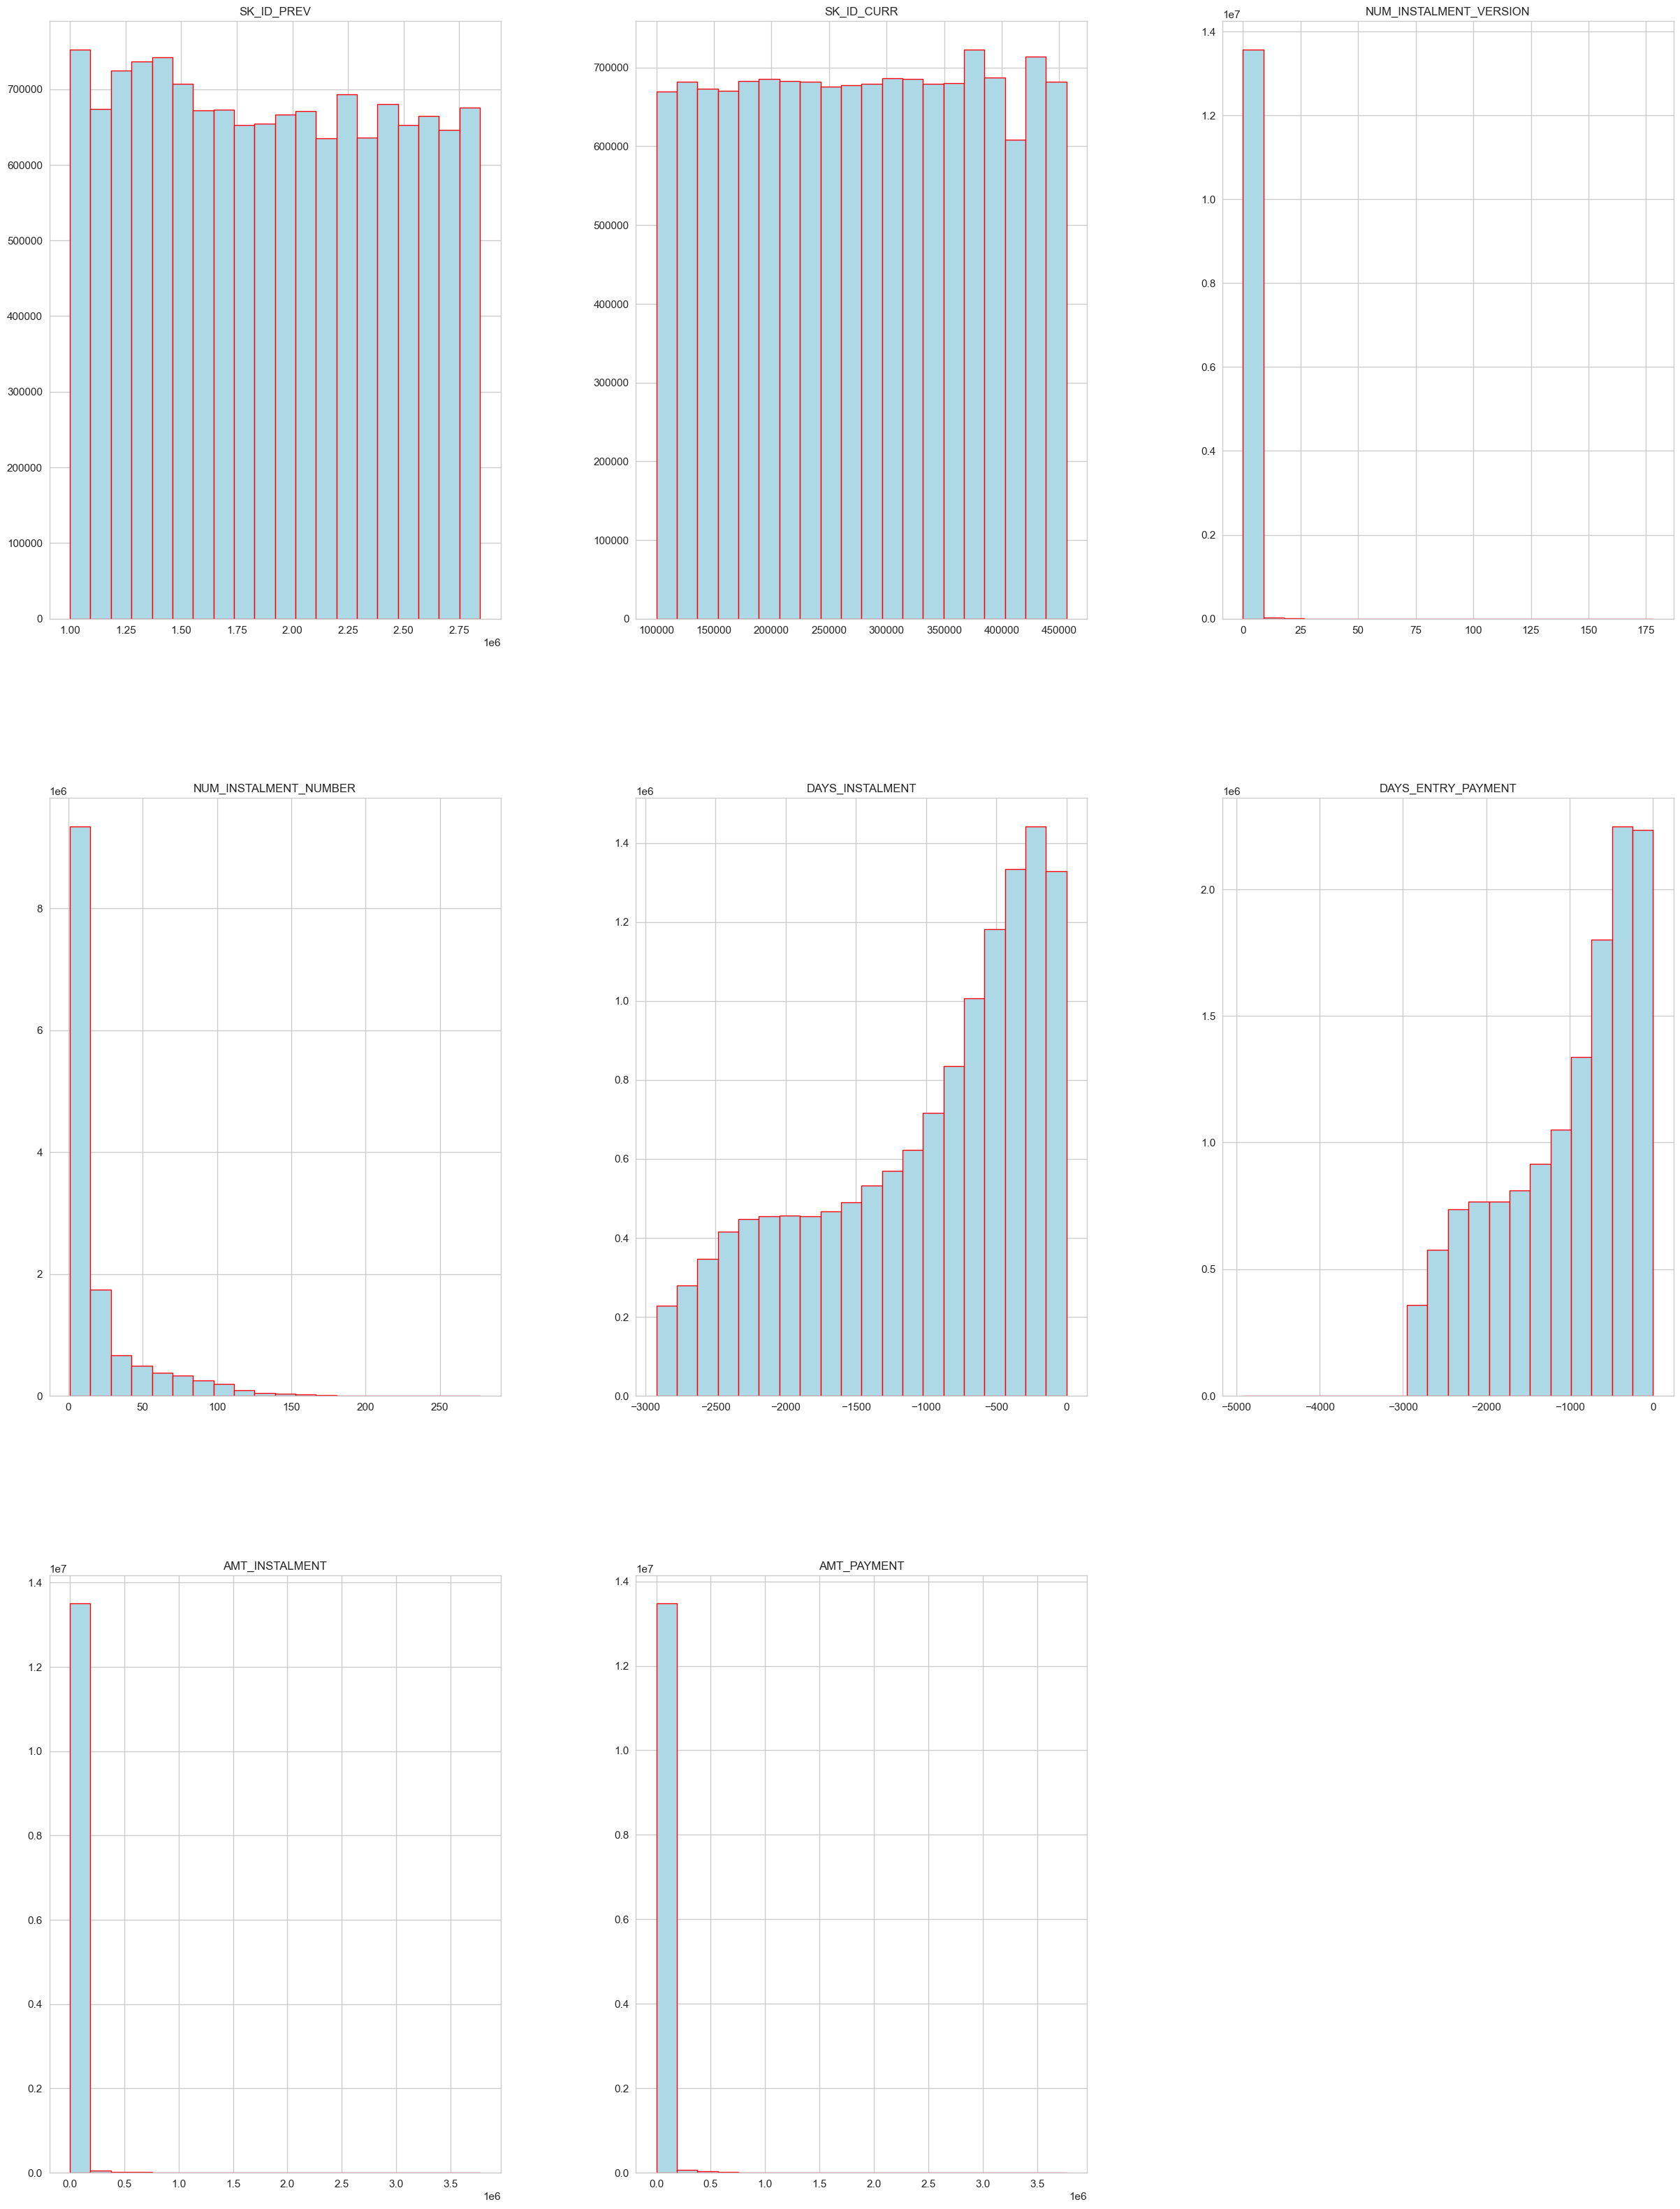


DATASET: prevapplication



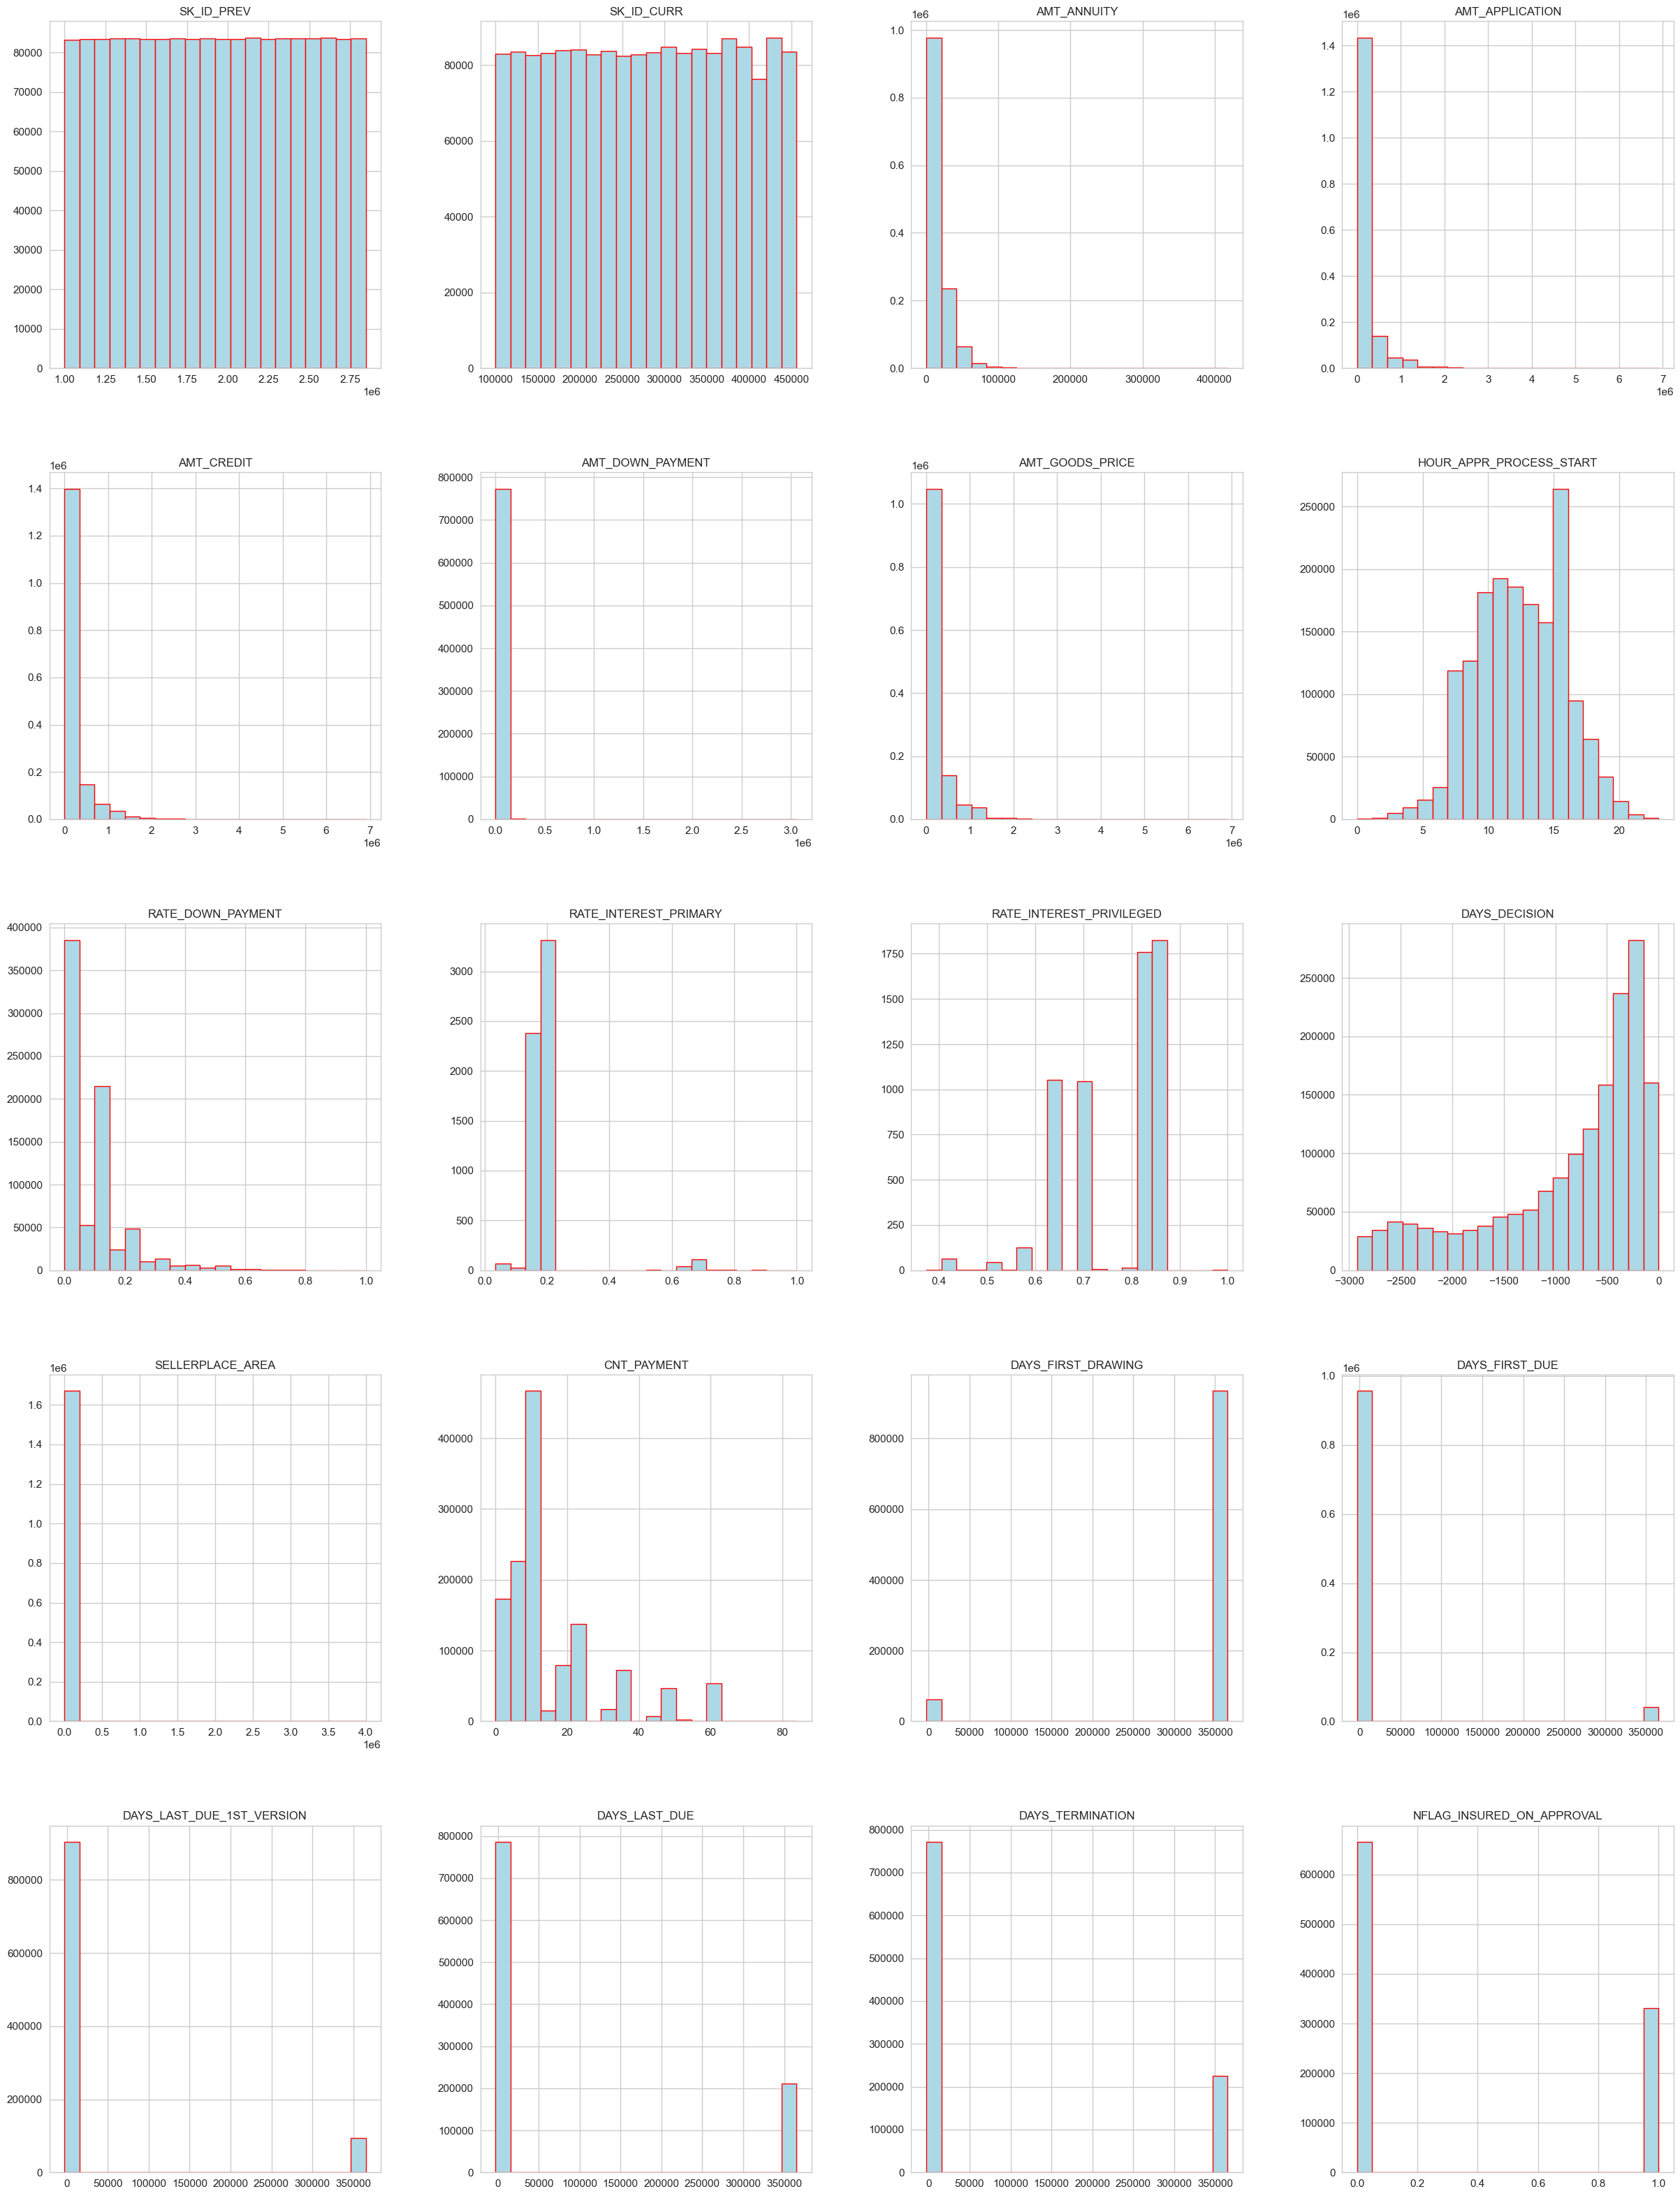

In [383]:
plt.style.use('seaborn-whitegrid')
for df in df_list[:-1]:
    print(f'DATASET: {[name for name in globals() if globals()[name] is df][0]}')
    print('')
    df_bin_num = get_binary_numeric_or_zeros(df)
    if type(df_bin_num) is None.__class__:
        df.hist(bins=20, figsize=(30,40), 
                                                     color='lightblue', edgecolor = 'red')
        plt.savefig(f"output_{[name for name in globals() if globals()[name] is df][0]}.png")
        plt.show();
        print('')
        
    else:
        df.drop(list(df_bin_num.columns), axis = 1).hist(bins=20, figsize=(30,40), 
                                                     color='lightblue', edgecolor = 'red')
        plt.savefig(f"output_{[name for name in globals() if globals()[name] is df][0]}.png")
        plt.show();
        print('')
     

It can be observed that the majority of numerical variables are not distributed normally and there are high numbers of outliers in many variables.

#### Categorical and binary variables

Functions to count values of all categorical and binary variables were created and looped over the elements of the list of dataframes. 

In [386]:
def value_counts_categorical(data):
    data_describe = data.describe()
    data_cat = data.copy()
    for i in range(len(data_describe.columns)):
        data_cat =  data_cat.drop(columns = [data_describe.columns[i]])   
    for i in range(len(data_cat.iloc[0,:])):
        print(data_cat.iloc[:,i].value_counts())
        print('')

In [387]:
def value_counts_binary_numeric(data):
    data_describe = data.describe()
    data_bin_num = get_binary_numeric_or_zeros(data)
    if type(data_bin_num) is None.__class__:
        print('There are no binary numeric variables in the dataset.')
    else:
        for i in range(len(data_bin_num.iloc[0,:])):
            print(data_bin_num.iloc[:,i].value_counts())
            print('')


In [388]:
for df in df_list:
    print(f'DATASET: {[name for name in globals() if globals()[name] is df][0]}')
    print('')
    print('CATEGORICAL:')
    value_counts_categorical(df)
    print('')
    print('BINARY NUMERIC:')
    value_counts_binary_numeric(df)
    print('')

DATASET: aptrain

CATEGORICAL:
Cash loans         278232
Revolving loans     29279
Name: NAME_CONTRACT_TYPE, dtype: int64

F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64

N    202924
Y    104587
Name: FLAG_OWN_CAR, dtype: int64

Y    213312
N     94199
Name: FLAG_OWN_REALTY, dtype: int64

Unaccompanied      248526
Family              40149
Spouse, partner     11370
Children             3267
Other_B              1770
Other_A               866
Group of people       271
Name: NAME_TYPE_SUITE, dtype: int64

Working                 158774
Commercial associate     71617
Pensioner                55362
State servant            21703
Unemployed                  22
Student                     18
Businessman                 10
Maternity leave              5
Name: NAME_INCOME_TYPE, dtype: int64

Secondary / secondary special    218391
Higher education                  74863
Incomplete higher                 10277
Lower secondary                    3816
Academic degree   

Cash loans         48305
Revolving loans      439
Name: NAME_CONTRACT_TYPE, dtype: int64

F    32678
M    16066
Name: CODE_GENDER, dtype: int64

N    32311
Y    16433
Name: FLAG_OWN_CAR, dtype: int64

Y    33658
N    15086
Name: FLAG_OWN_REALTY, dtype: int64

1    48743
0        1
Name: FLAG_MOBIL, dtype: int64

1    39469
0     9275
Name: FLAG_EMP_PHONE, dtype: int64

0    38766
1     9978
Name: FLAG_WORK_PHONE, dtype: int64

1    48666
0       78
Name: FLAG_CONT_MOBILE, dtype: int64

0    35918
1    12826
Name: FLAG_PHONE, dtype: int64

0    40816
1     7928
Name: FLAG_EMAIL, dtype: int64

0    47826
1      918
Name: REG_REGION_NOT_LIVE_REGION, dtype: int64

0    46055
1     2689
Name: REG_REGION_NOT_WORK_REGION, dtype: int64

0    46695
1     2049
Name: LIVE_REGION_NOT_WORK_REGION, dtype: int64

0    44968
1     3776
Name: REG_CITY_NOT_LIVE_CITY, dtype: int64

0    37793
1    10951
Name: REG_CITY_NOT_WORK_CITY, dtype: int64

0    40252
1     8492
Name: LIVE_CITY_NOT_WORK_CITY, dtype

Credit and cash offices       719968
Country-wide                  494690
Stone                         212083
Regional / Local              108528
Contact center                 71297
AP+ (Cash loan)                57046
Channel of corporate sales      6150
Car dealer                       452
Name: CHANNEL_TYPE, dtype: int64

XNA                     855720
Consumer electronics    398265
Connectivity            276029
Furniture                57849
Construction             29781
Clothing                 23949
Industry                 19194
Auto technology           4990
Jewelry                   2709
MLM partners              1215
Tourism                    513
Name: NAME_SELLER_INDUSTRY, dtype: int64

XNA           517215
middle        385532
high          353331
low_normal    322095
low_action     92041
Name: NAME_YIELD_GROUP, dtype: int64

Cash                              285990
POS household with interest       263622
POS mobile with interest          220670
Cash X-Sell: middle  

It can be observed that quite high numbers of values in several different features are named XNA, XAP, XC, however, the meaning of these acronyms is unclear (explanations are not provided in the data dictionnary). Thus, these values could ve considered as missing. 

#### 'TARGET' as a target variable

The 'TARGET' variable in the aptrain dataframe will be treated as the target variable for machine learning purposes, thus, the distribution of its values is presented here. It can be observed that this variable is heavily imbalanced - there are only 8 percent cases with value 1 (indicating that the person has payment difficulties).

In [21]:
target_percentage = ((pd.DataFrame(aptrain["TARGET"].value_counts()).loc[:,"TARGET"]/pd.DataFrame(aptrain["TARGET"]\
    .value_counts()).loc[:,"TARGET"].sum())*100).round(2)

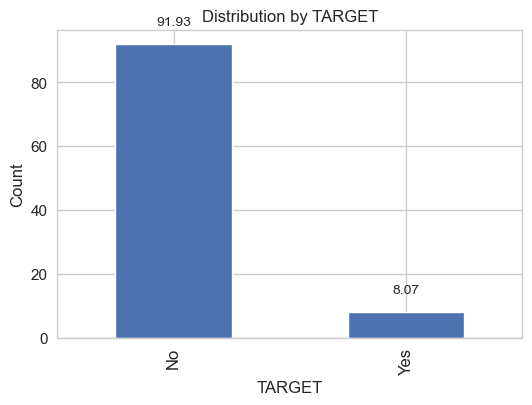

In [393]:
ax = target_percentage.plot(kind="bar", figsize=(6,4))
plt.title("Distribution by TARGET", fontsize=12)
plt.xlabel("TARGET", fontsize=12)
plt.xticks((0, 1), ('No', 'Yes'), fontsize = 12)
plt.ylabel("Count", fontsize=12)

for i, count in enumerate(target_percentage):
    ax.text(i, count + 5, str(count), ha='center', va='bottom', fontsize=10)

plt.show()

Next, each of the dataframes and their variables will be examined separately.

#### APTRAIN AND APTEST:

These dataframes contain 121 columns (aptest; the target variable 'TARGET' missing) and 122 columns (aptrain; the 'TARGET' is present). The dataframes include data on the HomeCredit club clients - their demographical characteristics (age, education, gender, family status), social conditions (income, living conditions, car, etc.), and the loans of the clients - contract type, annuity, credit amount, goods price amount, etc. Some features such as documents provided by clients or the day of the week and hour of the day when a client applied for a loan do not seem meaningful with regard to the effect on the clients' capability to pay the loan in time. These features will later be removed in one or another stage of feature engeneering.

Bellow is the full list of features in two forms: with quation marks (for the use in pandas functions) and without quation marks (for the use in sql queries).

In [394]:
elem = [f'"{item}"' for item in aptrain.columns]
print(', '.join(elem))


"SK_ID_CURR", "TARGET", "NAME_CONTRACT_TYPE", "CODE_GENDER", "FLAG_OWN_CAR", "FLAG_OWN_REALTY", "CNT_CHILDREN", "AMT_INCOME_TOTAL", "AMT_CREDIT", "AMT_ANNUITY", "AMT_GOODS_PRICE", "NAME_TYPE_SUITE", "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS", "NAME_HOUSING_TYPE", "REGION_POPULATION_RELATIVE", "DAYS_BIRTH", "DAYS_EMPLOYED", "DAYS_REGISTRATION", "DAYS_ID_PUBLISH", "OWN_CAR_AGE", "FLAG_MOBIL", "FLAG_EMP_PHONE", "FLAG_WORK_PHONE", "FLAG_CONT_MOBILE", "FLAG_PHONE", "FLAG_EMAIL", "OCCUPATION_TYPE", "CNT_FAM_MEMBERS", "REGION_RATING_CLIENT", "REGION_RATING_CLIENT_W_CITY", "WEEKDAY_APPR_PROCESS_START", "HOUR_APPR_PROCESS_START", "REG_REGION_NOT_LIVE_REGION", "REG_REGION_NOT_WORK_REGION", "LIVE_REGION_NOT_WORK_REGION", "REG_CITY_NOT_LIVE_CITY", "REG_CITY_NOT_WORK_CITY", "LIVE_CITY_NOT_WORK_CITY", "ORGANIZATION_TYPE", "EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3", "APARTMENTS_AVG", "BASEMENTAREA_AVG", "YEARS_BEGINEXPLUATATION_AVG", "YEARS_BUILD_AVG", "COMMONAREA_AVG", "ELEV

In [395]:
print(', '.join(aptrain.columns))


SK_ID_CURR, TARGET, NAME_CONTRACT_TYPE, CODE_GENDER, FLAG_OWN_CAR, FLAG_OWN_REALTY, CNT_CHILDREN, AMT_INCOME_TOTAL, AMT_CREDIT, AMT_ANNUITY, AMT_GOODS_PRICE, NAME_TYPE_SUITE, NAME_INCOME_TYPE, NAME_EDUCATION_TYPE, NAME_FAMILY_STATUS, NAME_HOUSING_TYPE, REGION_POPULATION_RELATIVE, DAYS_BIRTH, DAYS_EMPLOYED, DAYS_REGISTRATION, DAYS_ID_PUBLISH, OWN_CAR_AGE, FLAG_MOBIL, FLAG_EMP_PHONE, FLAG_WORK_PHONE, FLAG_CONT_MOBILE, FLAG_PHONE, FLAG_EMAIL, OCCUPATION_TYPE, CNT_FAM_MEMBERS, REGION_RATING_CLIENT, REGION_RATING_CLIENT_W_CITY, WEEKDAY_APPR_PROCESS_START, HOUR_APPR_PROCESS_START, REG_REGION_NOT_LIVE_REGION, REG_REGION_NOT_WORK_REGION, LIVE_REGION_NOT_WORK_REGION, REG_CITY_NOT_LIVE_CITY, REG_CITY_NOT_WORK_CITY, LIVE_CITY_NOT_WORK_CITY, ORGANIZATION_TYPE, EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3, APARTMENTS_AVG, BASEMENTAREA_AVG, YEARS_BEGINEXPLUATATION_AVG, YEARS_BUILD_AVG, COMMONAREA_AVG, ELEVATORS_AVG, ENTRANCES_AVG, FLOORSMAX_AVG, FLOORSMIN_AVG, LANDAREA_AVG, LIVINGAPARTMENTS_AVG, LIVINGA

#### living conditions features:

Quite a high number of features in these datasets are related with living conditions of clients. Some variables present just different metrics of the same metrics (averages, medians, modes). From the correlation heatmap plot it can be observed that many of these features are highly correlated between each other. Thus, it is reasonable to reduce a number of features by applying a dimension reduction procedure. 

In [396]:
def get_correlations(data):
    correlation_matrix = data.iloc[:, :-1].corr()
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, annot=True, cmap='RdYlGn', 
                vmin=-1, vmax=1, linewidths=0.2, mask=mask)

    fig = plt.gcf()
    fig.set_size_inches(20, 20)

    plt.show();

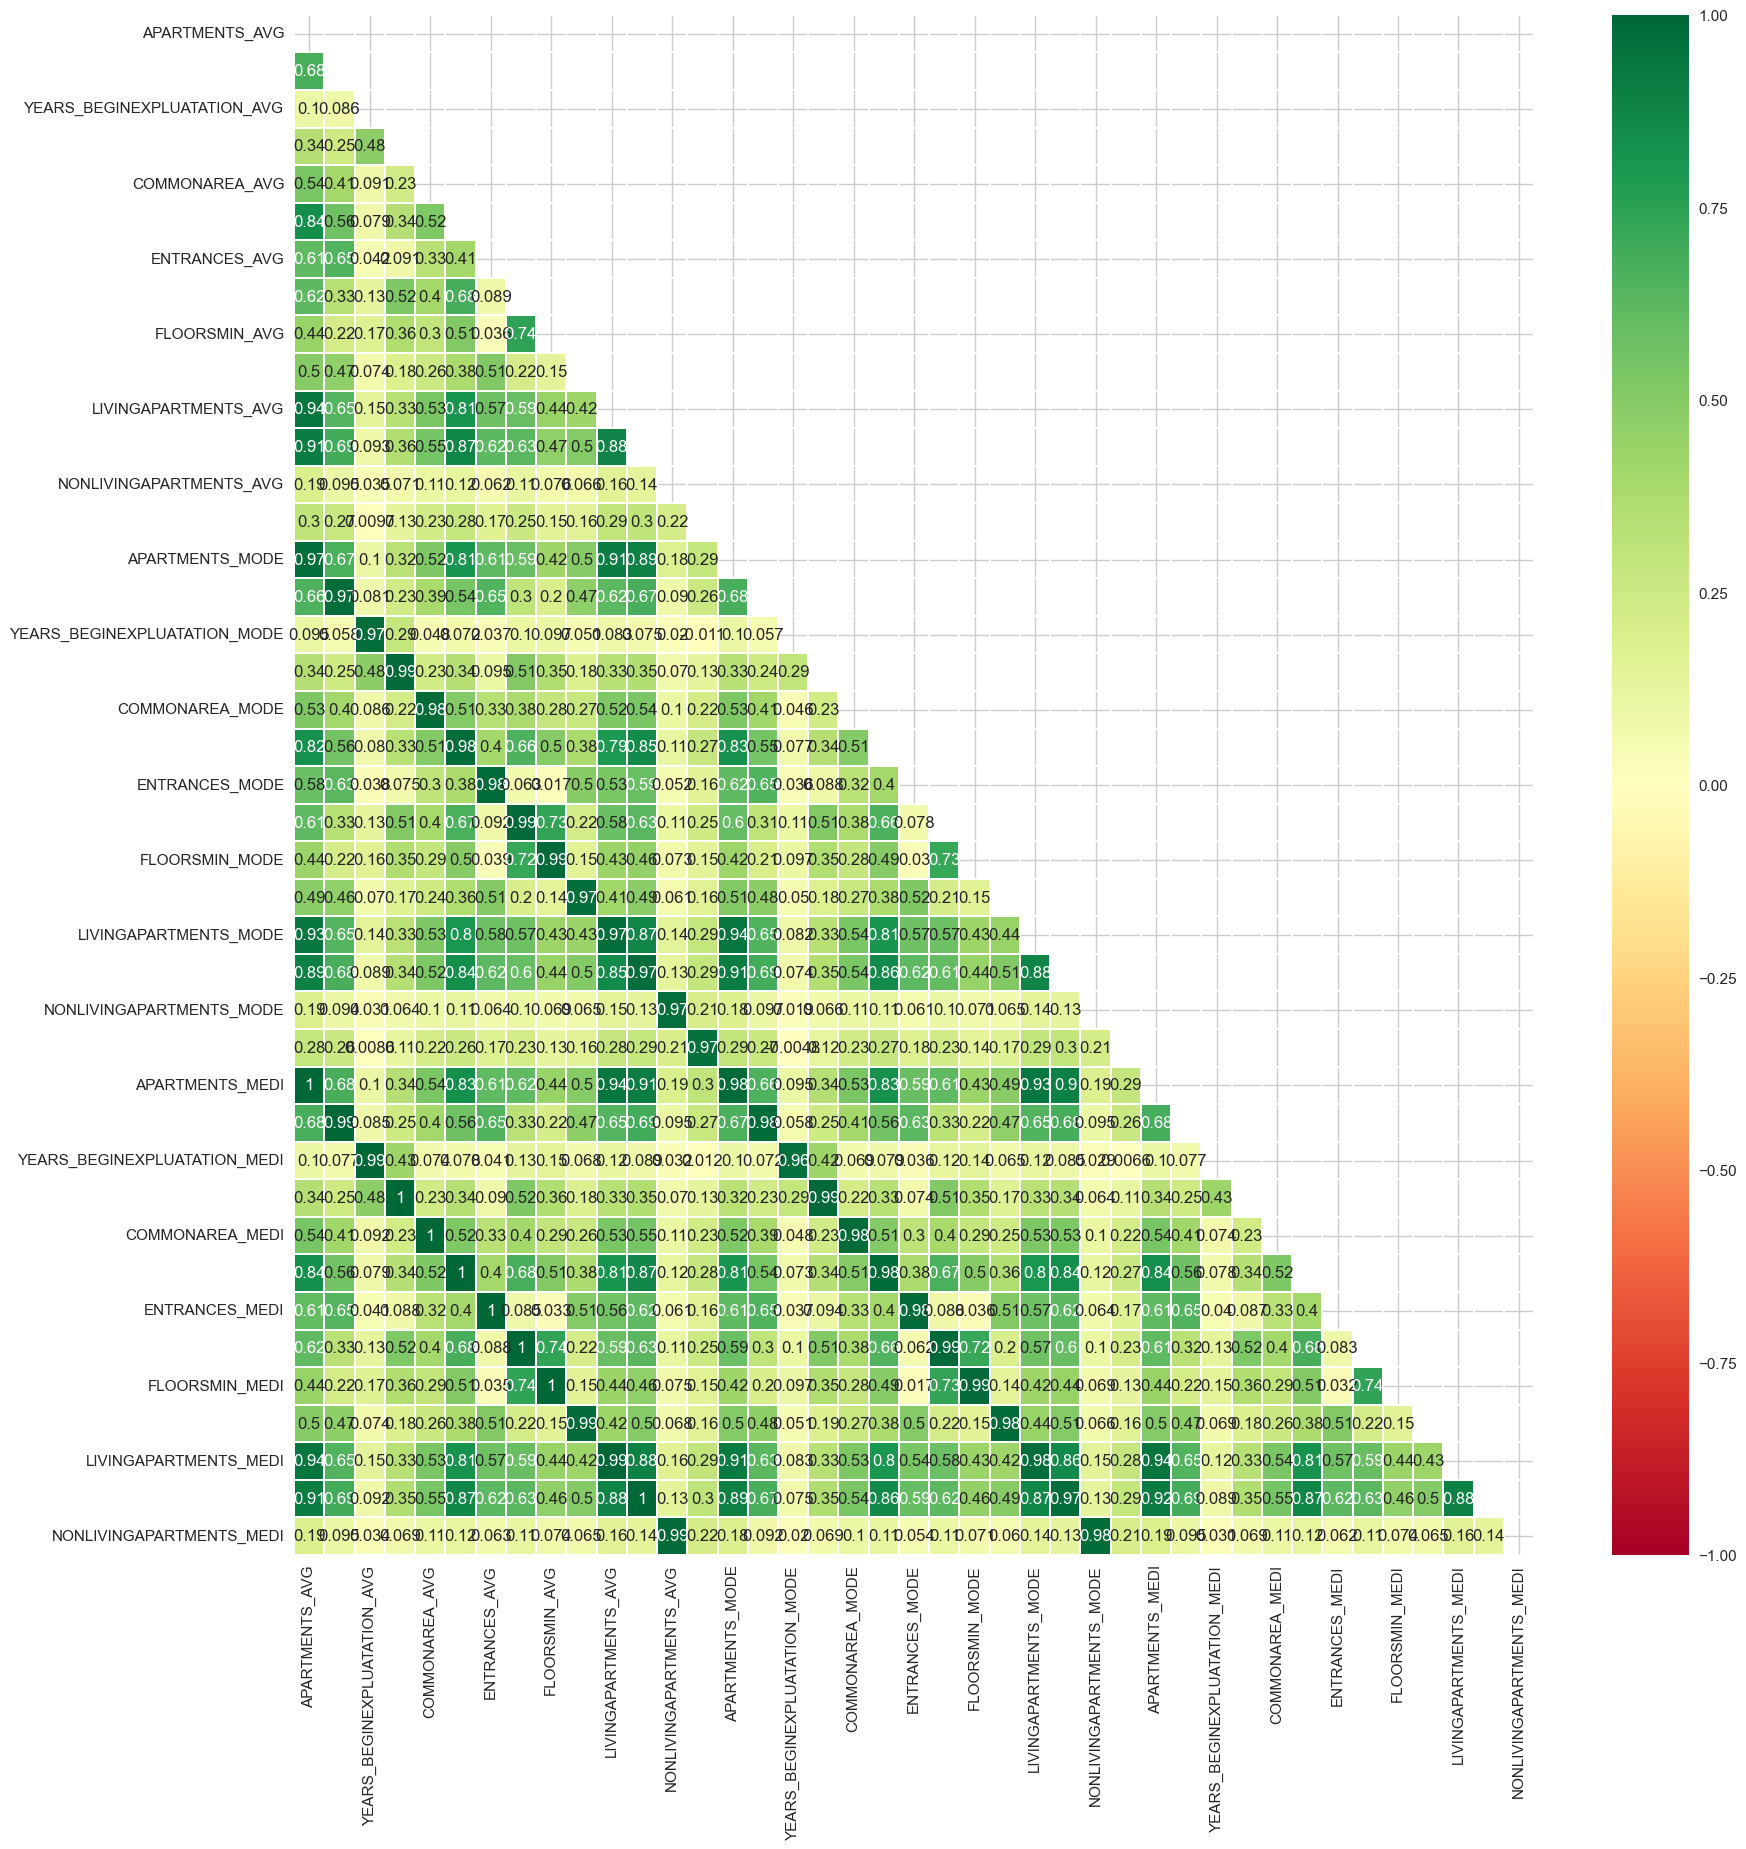

In [397]:
get_correlations(aptrain.loc[:,["APARTMENTS_AVG", "BASEMENTAREA_AVG", 
                                "YEARS_BEGINEXPLUATATION_AVG", "YEARS_BUILD_AVG", "COMMONAREA_AVG", 
 "ELEVATORS_AVG", "ENTRANCES_AVG", "FLOORSMAX_AVG", "FLOORSMIN_AVG", "LANDAREA_AVG", "LIVINGAPARTMENTS_AVG", 
 "LIVINGAREA_AVG", "NONLIVINGAPARTMENTS_AVG", "NONLIVINGAREA_AVG", "APARTMENTS_MODE", "BASEMENTAREA_MODE", 
  "YEARS_BEGINEXPLUATATION_MODE", "YEARS_BUILD_MODE", "COMMONAREA_MODE", "ELEVATORS_MODE", "ENTRANCES_MODE", 
  "FLOORSMAX_MODE", "FLOORSMIN_MODE", "LANDAREA_MODE", "LIVINGAPARTMENTS_MODE", "LIVINGAREA_MODE", 
  "NONLIVINGAPARTMENTS_MODE", "NONLIVINGAREA_MODE", "APARTMENTS_MEDI", "BASEMENTAREA_MEDI", 
  "YEARS_BEGINEXPLUATATION_MEDI", "YEARS_BUILD_MEDI", "COMMONAREA_MEDI", "ELEVATORS_MEDI", "ENTRANCES_MEDI", 
  "FLOORSMAX_MEDI", "FLOORSMIN_MEDI", "LANDAREA_MEDI", "LIVINGAPARTMENTS_MEDI", "LIVINGAREA_MEDI", 
  "NONLIVINGAPARTMENTS_MEDI", "NONLIVINGAREA_MEDI"]])

##### PCA for aptrain living conditions features:


For the purpose of dimension reduction, the function for principle componend analysis is created and run on the features presenting averages of the apartment or house characteristics (median and mode were excluded).

In [398]:
def fit_pca(data, list_of_features, number_of_components, pc_column_names):
    
    # fit data:
    pca = PCA(n_components=number_of_components)
    pca.fit(data.loc[:, list_of_features].fillna(0))
    
    # transform data:
    data_transformed = pd.DataFrame(pca.transform((data.loc[:, list_of_features].fillna(0))), 
                columns=[f'PC{i+1}' for i in range(number_of_components)], index=data.index)
    
    # print outputs:
    print(f'Explained variance ratio: {pca.explained_variance_ratio_}')
    print('')
    print(f'Singular values: {pca.singular_values_}')
    print('')
    print(f'Components: {pca.components_}')
    
    # get principal components table:
    pca_df = pd.DataFrame(pca.components_)
    pca_df.columns = list_of_features
    pca_df = pca_df.transpose().round(3)
    pca_df.columns = pc_column_names
    pca_df = pca_df.sort_values(pc_column_names[0],ascending = False)
    
    # plot explained variance ratios:
    cum_sum_eigenvalues = np.cumsum(pca.explained_variance_ratio_)
    plt.figure(figsize=(6, 3))
    plt.bar(range(0,len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_, 
            alpha=0.5, align='center', label='Individual explained variance')
    plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',
             label='Cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal component index')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show();
    
    return pca_df, data_transformed

In [399]:
list_of_features_lc = ["APARTMENTS_AVG", "BASEMENTAREA_AVG", 
 "YEARS_BEGINEXPLUATATION_AVG", "YEARS_BUILD_AVG", "COMMONAREA_AVG", 
 "ELEVATORS_AVG", "ENTRANCES_AVG", "FLOORSMAX_AVG", "FLOORSMIN_AVG", "LANDAREA_AVG", "LIVINGAPARTMENTS_AVG", 
 "LIVINGAREA_AVG", "NONLIVINGAPARTMENTS_AVG", "NONLIVINGAREA_AVG"]

pc_names_of_columns_lc = ["PC1", "PC2"]


Two principle components were identified. One of them explain 76 percent variance, another one - 12 percent. Data from 9 variables is transformed into 2 variables 'LIVING_CONDITIONS_1' and "LIVING_CONDITIONS_2'.

Explained variance ratio: [0.76303748 0.12254684]

Singular values: [332.75066999 133.35124361]

Components: [[ 0.10776881  0.06972266  0.78256887  0.5128919   0.03089267  0.07726968
   0.12553963  0.20204174  0.1616118   0.05052997  0.07139918  0.10111174
   0.00607464  0.02272648]
 [ 0.02156127  0.03084564 -0.57650737  0.75210819  0.05449739  0.05401282
  -0.03988908  0.01501277  0.27850645  0.01757961  0.11893494  0.02660957
   0.01033411 -0.00412828]]


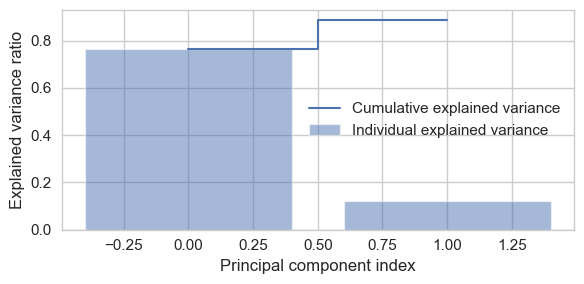

PC1    PC2
YEARS_BEGINEXPLUATATION_AVG  0.783 -0.577
YEARS_BUILD_AVG              0.513  0.752
FLOORSMAX_AVG                0.202  0.015
FLOORSMIN_AVG                0.162  0.279
ENTRANCES_AVG                0.126 -0.040
APARTMENTS_AVG               0.108  0.022
LIVINGAREA_AVG               0.101  0.027
ELEVATORS_AVG                0.077  0.054
LIVINGAPARTMENTS_AVG         0.071  0.119
BASEMENTAREA_AVG             0.070  0.031
LANDAREA_AVG                 0.051  0.018
COMMONAREA_AVG               0.031  0.054
NONLIVINGAREA_AVG            0.023 -0.004
NONLIVINGAPARTMENTS_AVG      0.006  0.010

In [400]:
pca_df_lc, aptrain_lc_pca = fit_pca(aptrain.set_index("SK_ID_CURR"), list_of_features_lc, 
                                    2, pc_names_of_columns_lc)
pca_df_lc

From the table above it can be observed that the first component is highly positively correlated with YEARS_BEGINEXPLUATATION_AVG, the second component - with YEARS_BUILD_AVG.

In [401]:
aptrain_lc_pca.columns = ["LIVING_CONDITIONS_1", "LIVING_CONDITIONS_2"]


Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor

##### PCA for aptest living conditions features:

The same transformations are done for the aptest data.

Explained variance ratio: [0.75345082 0.12475632]

Singular values: [133.01499148  54.12580998]

Components: [[ 0.11297998  0.0714217   0.77573999  0.51355282  0.03362968  0.08399889
   0.12703213  0.20931292  0.16781588  0.05114148  0.0758914   0.10651227
   0.00650168  0.02377694]
 [ 0.0254051   0.03065532 -0.58324207  0.74082172  0.05992641  0.06035285
  -0.04425825  0.01691045  0.28734686  0.01726803  0.12665822  0.03010373
   0.0112208  -0.00273198]]


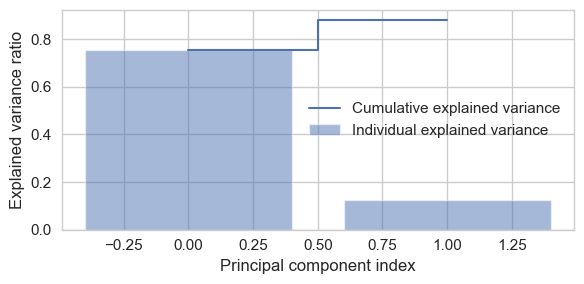

PC1    PC2
YEARS_BEGINEXPLUATATION_AVG  0.776 -0.583
YEARS_BUILD_AVG              0.514  0.741
FLOORSMAX_AVG                0.209  0.017
FLOORSMIN_AVG                0.168  0.287
ENTRANCES_AVG                0.127 -0.044
APARTMENTS_AVG               0.113  0.025
LIVINGAREA_AVG               0.107  0.030
ELEVATORS_AVG                0.084  0.060
LIVINGAPARTMENTS_AVG         0.076  0.127
BASEMENTAREA_AVG             0.071  0.031
LANDAREA_AVG                 0.051  0.017
COMMONAREA_AVG               0.034  0.060
NONLIVINGAREA_AVG            0.024 -0.003
NONLIVINGAPARTMENTS_AVG      0.007  0.011

In [402]:
pca_df_lc_test, aptest_lc_pca = fit_pca(aptest.set_index("SK_ID_CURR"), list_of_features_lc, 
                                        2, pc_names_of_columns_lc)
pca_df_lc_test

In [403]:
aptest_lc_pca.columns = ["LIVING_CONDITIONS_1", "LIVING_CONDITIONS_2"]

##### PCA for aptrain CB enquiries features:

In the same way, the principal component analysis was applied to the variables on number of enquiries to the Credit Bureau.

In [404]:
list_of_features_cb = ["AMT_REQ_CREDIT_BUREAU_HOUR", "AMT_REQ_CREDIT_BUREAU_DAY", 
                       "AMT_REQ_CREDIT_BUREAU_WEEK", "AMT_REQ_CREDIT_BUREAU_MON",
                       "AMT_REQ_CREDIT_BUREAU_QRT", "AMT_REQ_CREDIT_BUREAU_YEAR"]
pc_names_of_columns_cb = ["PC1","PC2"]

Explained variance ratio: [0.72177081 0.1532178 ]

Singular values: [1030.54178595  474.8107654 ]

Components: [[ 2.32940681e-04  2.78130079e-04  4.03347266e-03  1.91425223e-02
   5.39843927e-02  9.98350063e-01]
 [ 2.51022169e-04 -3.73754815e-04 -2.13012090e-03  9.99809746e-01
   2.06496216e-03 -1.92735189e-02]]


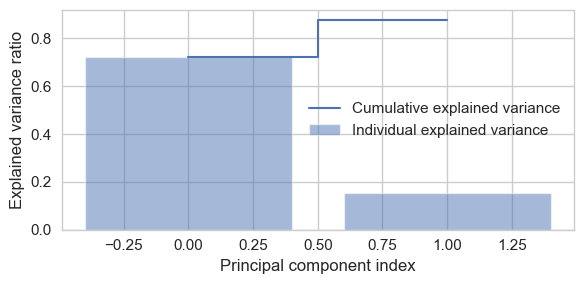

PC1    PC2
AMT_REQ_CREDIT_BUREAU_YEAR  0.998 -0.019
AMT_REQ_CREDIT_BUREAU_QRT   0.054  0.002
AMT_REQ_CREDIT_BUREAU_MON   0.019  1.000
AMT_REQ_CREDIT_BUREAU_WEEK  0.004 -0.002
AMT_REQ_CREDIT_BUREAU_HOUR  0.000  0.000
AMT_REQ_CREDIT_BUREAU_DAY   0.000 -0.000

In [405]:
pca_df_cb, aptrain_cb_pca = fit_pca(aptrain.set_index("SK_ID_CURR"), list_of_features_cb,
                                    2, pc_names_of_columns_cb)
pca_df_cb

Two principal components were identified. It can be observed that the first PC is highly positively correlated with the variable AMT_REQ_CREDIT_BUREAU_YEAR, the second component - with the AMT_REQ_CREDIT_BUREAU_MON.

In [406]:
aptrain_cb_pca.columns = ["CB_enquiries_1", "CB_enquiries_2"]


##### PCA for aptest CB enquiries features:

Explained variance ratio: [0.87902704 0.11654932]

Singular values: [406.68930366 148.08685661]

Components: [[ 3.97178551e-04  1.61484153e-04  1.81058171e-04  1.98067966e-03
   3.51267400e-02  9.99380795e-01]
 [-1.84630986e-05  6.04206103e-04  2.15536790e-03  1.56061591e-03
   9.99379017e-01 -3.51302513e-02]]


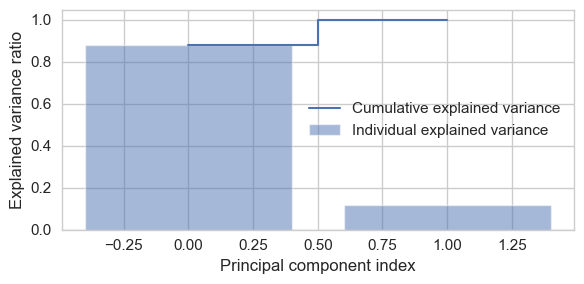

PC1    PC2
AMT_REQ_CREDIT_BUREAU_YEAR  0.999 -0.035
AMT_REQ_CREDIT_BUREAU_QRT   0.035  0.999
AMT_REQ_CREDIT_BUREAU_MON   0.002  0.002
AMT_REQ_CREDIT_BUREAU_HOUR  0.000 -0.000
AMT_REQ_CREDIT_BUREAU_DAY   0.000  0.001
AMT_REQ_CREDIT_BUREAU_WEEK  0.000  0.002

In [407]:
pca_df_cb_test, aptest_cb_pca = fit_pca(aptest.set_index("SK_ID_CURR"), list_of_features_cb, 
                                        2, pc_names_of_columns_cb)
pca_df_cb_test

for the aptest dataframe also two principal components were identified. It can be observed that the first PC is highly positively correlated with the variable AMT_REQ_CREDIT_BUREAU_YEAR, the second component - with the AMT_REQ_CREDIT_BUREAU_QRT.

In [408]:
aptest_cb_pca.columns = ["CB_enquiries_1", "CB_enquiries_2"]


#### gender and organization type:

As it was noticed that gender and organization type variables contain value XNA which has to be removed, it was decided to encode the variables manually with pandas (rather than later in the machine learning pipeline). Also, categorical variable ORGANIZATION_TYPE has too many values, thus it was decided to do dimension reduction with PCA after one-hot encoding of this variable.

In [409]:
aptrain_encoded = pd.get_dummies(aptrain, columns=['CODE_GENDER', "ORGANIZATION_TYPE"])

In [410]:
aptest_encoded = pd.get_dummies(aptest, columns=['CODE_GENDER', "ORGANIZATION_TYPE"])

Gender variables were selected, removing variable gender_XNA.

In [411]:
aptrain_gender = duckdb.sql("""SELECT
                      SK_ID_CURR,
                      CODE_GENDER_F as GENDER_F,
                      CODE_GENDER_M as GENDER_M
                      FROM aptrain_encoded     
                            """).df().set_index("SK_ID_CURR")

aptest_gender = duckdb.sql("""SELECT
                      SK_ID_CURR,
                      CODE_GENDER_F as GENDER_F,
                      CODE_GENDER_M as GENDER_M
                      FROM aptest_encoded     
                            """).df().set_index("SK_ID_CURR")

#### days employed:

It can be observed (see bellow) that there are some errors in the values of the variable 'DAYS_EMPLOYED'. These values were transformed to missing values.

In [412]:
aptrain["DAYS_EMPLOYED"].value_counts()

 365243    55374
-200         156
-224         152
-230         151
-199         151
           ...  
-13961         1
-11827         1
-10176         1
-9459          1
-8694          1
Name: DAYS_EMPLOYED, Length: 12574, dtype: int64

In [413]:
aptrain["DAYS_EMPLOYED"].replace(365243, np.nan, inplace=True)

In [414]:
aptest["DAYS_EMPLOYED"].replace(365243, np.nan, inplace=True)

#### education:

The categorical variable 'education' was transformed into an ordinal variable in the scale from 1 'lower secondary' to 5 'academic degree' which will be treated as a numerical variable (with an option to calculate the mean of education). 

Recoded values of this variable: "1": Lower secondary "2": Secondary / secondary special "3": Incomplete higher "4": Higher education "5": Academic degree

In [415]:
aptest_edu = duckdb.sql("""SELECT
                      SK_ID_CURR,
                      CASE
                      WHEN NAME_EDUCATION_TYPE = 'Lower secondary' THEN 1
                      WHEN NAME_EDUCATION_TYPE = 'Secondary / secondary special' THEN 2
                      WHEN NAME_EDUCATION_TYPE = 'Incomplete higher' THEN 3
                      WHEN NAME_EDUCATION_TYPE = 'Higher education' THEN 4
                      WHEN NAME_EDUCATION_TYPE = 'Academic degree' THEN 5
                      END AS EDUCATION
                      FROM aptest
                            """).df().set_index("SK_ID_CURR")

aptrain_edu = duckdb.sql("""SELECT
                      SK_ID_CURR,
                      CASE
                      WHEN NAME_EDUCATION_TYPE = 'Lower secondary' THEN 1
                      WHEN NAME_EDUCATION_TYPE = 'Secondary / secondary special' THEN 2
                      WHEN NAME_EDUCATION_TYPE = 'Incomplete higher' THEN 3
                      WHEN NAME_EDUCATION_TYPE = 'Higher education' THEN 4
                      WHEN NAME_EDUCATION_TYPE = 'Academic degree' THEN 5
                      END AS EDUCATION
                      FROM aptrain
                            """).df().set_index("SK_ID_CURR")


#### car ownership:

OWN_CAR_AGE and FLAG_OWN_CAR variables were transformed into a single variable CAR_OWN with values 0 indicating that a person does not own a car.

In [416]:
aptest_car = duckdb.sql("""SELECT
                      SK_ID_CURR,
                      CASE
                      WHEN FLAG_OWN_CAR = 'N' THEN 0
                      WHEN OWN_CAR_AGE THEN OWN_CAR_AGE
                      END AS CAR_OWN
                      FROM aptest
                            """).df().set_index("SK_ID_CURR")


In [417]:
aptrain_car = duckdb.sql("""SELECT
                      SK_ID_CURR,
                      CASE
                      WHEN FLAG_OWN_CAR = 'N' THEN 0
                      WHEN OWN_CAR_AGE THEN OWN_CAR_AGE
                      END AS CAR_OWN
                      FROM aptrain
                            """).df().set_index("SK_ID_CURR")


##### Getting modified aptrain and aptest datasets: 

Aptrain and aptest dataframes were modified by merging remaining variables of these dataframes with new modified variables and droping variables FLAG_DOCUMENT_2, FLAG_DOCUMENT_3, FLAG_DOCUMENT_4, FLAG_DOCUMENT_5, FLAG_DOCUMENT_6, FLAG_DOCUMENT_7, FLAG_DOCUMENT_8, FLAG_DOCUMENT_9, FLAG_DOCUMENT_10, FLAG_DOCUMENT_11, FLAG_DOCUMENT_12, FLAG_DOCUMENT_13, FLAG_DOCUMENT_14, FLAG_DOCUMENT_15, FLAG_DOCUMENT_16, FLAG_DOCUMENT_17, FLAG_DOCUMENT_18, FLAG_DOCUMENT_19, FLAG_DOCUMENT_20, FLAG_DOCUMENT_21, WEEKDAY_APPR_PROCESS_START, HOUR_APPR_PROCESS_START as they do not seem meaningful.

In [418]:
aptrain_mod = pd.concat([aptrain_encoded.loc[:,["SK_ID_CURR", "TARGET", "NAME_CONTRACT_TYPE",
 "FLAG_OWN_REALTY", "CNT_CHILDREN", "AMT_INCOME_TOTAL", "AMT_CREDIT", 
 "AMT_ANNUITY", "AMT_GOODS_PRICE", "NAME_TYPE_SUITE", "NAME_INCOME_TYPE", 
 "NAME_FAMILY_STATUS", "NAME_HOUSING_TYPE", 
 "REGION_POPULATION_RELATIVE", "DAYS_BIRTH", "DAYS_EMPLOYED", "DAYS_REGISTRATION", 
 "DAYS_ID_PUBLISH", "FLAG_MOBIL", "FLAG_EMP_PHONE", "FLAG_WORK_PHONE", 
 "FLAG_CONT_MOBILE", "FLAG_PHONE", "FLAG_EMAIL", "OCCUPATION_TYPE", "CNT_FAM_MEMBERS",
 "REGION_RATING_CLIENT", "REGION_RATING_CLIENT_W_CITY", "REG_REGION_NOT_LIVE_REGION", 
                                "REG_REGION_NOT_WORK_REGION",
 "LIVE_REGION_NOT_WORK_REGION", "REG_CITY_NOT_LIVE_CITY", "REG_CITY_NOT_WORK_CITY",
 "LIVE_CITY_NOT_WORK_CITY", "EXT_SOURCE_1", "EXT_SOURCE_2",
 "EXT_SOURCE_3", "FONDKAPREMONT_MODE", "HOUSETYPE_MODE", "TOTALAREA_MODE",
 "WALLSMATERIAL_MODE", "EMERGENCYSTATE_MODE", "OBS_60_CNT_SOCIAL_CIRCLE",
 "DAYS_LAST_PHONE_CHANGE", "ORGANIZATION_TYPE_Advertising", "ORGANIZATION_TYPE_Agriculture", 
"ORGANIZATION_TYPE_Bank", "ORGANIZATION_TYPE_Business Entity Type 1", 
"ORGANIZATION_TYPE_Business Entity Type 2",
"ORGANIZATION_TYPE_Business Entity Type 3", "ORGANIZATION_TYPE_Cleaning",
"ORGANIZATION_TYPE_Construction", "ORGANIZATION_TYPE_Culture", 
"ORGANIZATION_TYPE_Electricity", "ORGANIZATION_TYPE_Emergency", 
"ORGANIZATION_TYPE_Government", "ORGANIZATION_TYPE_Hotel", 
"ORGANIZATION_TYPE_Housing", "ORGANIZATION_TYPE_Industry: type 1", 
"ORGANIZATION_TYPE_Industry: type 10", "ORGANIZATION_TYPE_Industry: type 11",
        "ORGANIZATION_TYPE_Industry: type 12", "ORGANIZATION_TYPE_Industry: type 13", 
        "ORGANIZATION_TYPE_Industry: type 2", "ORGANIZATION_TYPE_Industry: type 3", 
    "ORGANIZATION_TYPE_Industry: type 4", "ORGANIZATION_TYPE_Industry: type 5", 
"ORGANIZATION_TYPE_Industry: type 6", "ORGANIZATION_TYPE_Industry: type 7",
"ORGANIZATION_TYPE_Industry: type 8", "ORGANIZATION_TYPE_Industry: type 9", 
"ORGANIZATION_TYPE_Insurance", "ORGANIZATION_TYPE_Kindergarten", 
"ORGANIZATION_TYPE_Legal Services", "ORGANIZATION_TYPE_Medicine",
"ORGANIZATION_TYPE_Military", "ORGANIZATION_TYPE_Mobile", 
"ORGANIZATION_TYPE_Other", "ORGANIZATION_TYPE_Police", "ORGANIZATION_TYPE_Postal", 
"ORGANIZATION_TYPE_Realtor", "ORGANIZATION_TYPE_Religion", 
"ORGANIZATION_TYPE_Restaurant", "ORGANIZATION_TYPE_School",
"ORGANIZATION_TYPE_Security", "ORGANIZATION_TYPE_Security Ministries",
"ORGANIZATION_TYPE_Self-employed", "ORGANIZATION_TYPE_Services",
"ORGANIZATION_TYPE_Telecom", "ORGANIZATION_TYPE_Trade: type 1",
"ORGANIZATION_TYPE_Trade: type 2", "ORGANIZATION_TYPE_Trade: type 3", 
"ORGANIZATION_TYPE_Trade: type 4", "ORGANIZATION_TYPE_Trade: type 5", 
"ORGANIZATION_TYPE_Trade: type 6", "ORGANIZATION_TYPE_Trade: type 7", 
"ORGANIZATION_TYPE_Transport: type 1", "ORGANIZATION_TYPE_Transport: type 2", 
"ORGANIZATION_TYPE_Transport: type 3", "ORGANIZATION_TYPE_Transport: type 4", 
                                        "ORGANIZATION_TYPE_University"]].set_index("SK_ID_CURR"), 
 aptrain_edu, aptrain_car,aptrain_lc_pca, aptrain_cb_pca, aptrain_gender], axis = 1)

In [419]:
aptest_mod = pd.concat([aptest_encoded.loc[:,["SK_ID_CURR","NAME_CONTRACT_TYPE",
 "FLAG_OWN_REALTY", "CNT_CHILDREN", "AMT_INCOME_TOTAL", "AMT_CREDIT", 
 "AMT_ANNUITY", "AMT_GOODS_PRICE", "NAME_TYPE_SUITE", "NAME_INCOME_TYPE", 
              "NAME_FAMILY_STATUS", "NAME_HOUSING_TYPE", 
 "REGION_POPULATION_RELATIVE", "DAYS_BIRTH", "DAYS_EMPLOYED", "DAYS_REGISTRATION", 
 "DAYS_ID_PUBLISH", "FLAG_MOBIL", "FLAG_EMP_PHONE", "FLAG_WORK_PHONE", 
 "FLAG_CONT_MOBILE", "FLAG_PHONE", "FLAG_EMAIL", "OCCUPATION_TYPE", "CNT_FAM_MEMBERS",
 "REGION_RATING_CLIENT", "REGION_RATING_CLIENT_W_CITY", "REG_REGION_NOT_LIVE_REGION", "REG_REGION_NOT_WORK_REGION",
 "LIVE_REGION_NOT_WORK_REGION", "REG_CITY_NOT_LIVE_CITY", "REG_CITY_NOT_WORK_CITY",
 "LIVE_CITY_NOT_WORK_CITY", "EXT_SOURCE_1", "EXT_SOURCE_2",
 "EXT_SOURCE_3", "FONDKAPREMONT_MODE", "HOUSETYPE_MODE", "TOTALAREA_MODE",
 "WALLSMATERIAL_MODE", "EMERGENCYSTATE_MODE", "OBS_60_CNT_SOCIAL_CIRCLE",
 "DAYS_LAST_PHONE_CHANGE", "ORGANIZATION_TYPE_Advertising", "ORGANIZATION_TYPE_Agriculture", 
"ORGANIZATION_TYPE_Bank", "ORGANIZATION_TYPE_Business Entity Type 1", 
"ORGANIZATION_TYPE_Business Entity Type 2",
"ORGANIZATION_TYPE_Business Entity Type 3", "ORGANIZATION_TYPE_Cleaning",
"ORGANIZATION_TYPE_Construction", "ORGANIZATION_TYPE_Culture", 
"ORGANIZATION_TYPE_Electricity", "ORGANIZATION_TYPE_Emergency", 
"ORGANIZATION_TYPE_Government", "ORGANIZATION_TYPE_Hotel", 
"ORGANIZATION_TYPE_Housing", "ORGANIZATION_TYPE_Industry: type 1", 
"ORGANIZATION_TYPE_Industry: type 10", "ORGANIZATION_TYPE_Industry: type 11",
        "ORGANIZATION_TYPE_Industry: type 12", "ORGANIZATION_TYPE_Industry: type 13", 
        "ORGANIZATION_TYPE_Industry: type 2", "ORGANIZATION_TYPE_Industry: type 3", 
    "ORGANIZATION_TYPE_Industry: type 4", "ORGANIZATION_TYPE_Industry: type 5", 
"ORGANIZATION_TYPE_Industry: type 6", "ORGANIZATION_TYPE_Industry: type 7",
"ORGANIZATION_TYPE_Industry: type 8", "ORGANIZATION_TYPE_Industry: type 9", 
"ORGANIZATION_TYPE_Insurance", "ORGANIZATION_TYPE_Kindergarten", 
"ORGANIZATION_TYPE_Legal Services", "ORGANIZATION_TYPE_Medicine",
"ORGANIZATION_TYPE_Military", "ORGANIZATION_TYPE_Mobile", 
"ORGANIZATION_TYPE_Other", "ORGANIZATION_TYPE_Police", "ORGANIZATION_TYPE_Postal", 
"ORGANIZATION_TYPE_Realtor", "ORGANIZATION_TYPE_Religion", 
"ORGANIZATION_TYPE_Restaurant", "ORGANIZATION_TYPE_School",
"ORGANIZATION_TYPE_Security", "ORGANIZATION_TYPE_Security Ministries",
"ORGANIZATION_TYPE_Self-employed", "ORGANIZATION_TYPE_Services",
"ORGANIZATION_TYPE_Telecom", "ORGANIZATION_TYPE_Trade: type 1",
"ORGANIZATION_TYPE_Trade: type 2", "ORGANIZATION_TYPE_Trade: type 3", 
"ORGANIZATION_TYPE_Trade: type 4", "ORGANIZATION_TYPE_Trade: type 5", 
"ORGANIZATION_TYPE_Trade: type 6", "ORGANIZATION_TYPE_Trade: type 7", 
"ORGANIZATION_TYPE_Transport: type 1", "ORGANIZATION_TYPE_Transport: type 2", 
"ORGANIZATION_TYPE_Transport: type 3", "ORGANIZATION_TYPE_Transport: type 4", 
                                        "ORGANIZATION_TYPE_University"
                                     ]].set_index("SK_ID_CURR"), 
 aptest_edu, aptest_car,aptest_lc_pca, aptest_cb_pca,aptest_gender], axis = 1)

#### pcbalance:

The dataframe pcbalance was examined. The dataframe contains data on monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit. The data has the time dimension (info about payment balance of previous loans of the client). It has 6 features as well as primary and foreign keys refering to a client and his or her previous loans.

In [420]:
pcbalance.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'CNT_INSTALMENT',
       'CNT_INSTALMENT_FUTURE', 'NAME_CONTRACT_STATUS', 'SK_DPD',
       'SK_DPD_DEF'],
      dtype='object')

A categorical variable NAME_CONTRACT_STATUS of this dataframe was transformed by on hot encoding this variable in pandas (creating dummy variables), grouping values of encoded variables by loan ids and getting means of these values. Numerical variables also were grouped by loan ids and their means calculated. New aggreraged variables indicate average monthly balance and contract status of of each loan.

In [421]:
pcbalance_cat_encoded = pd.get_dummies(pcbalance, columns=["NAME_CONTRACT_STATUS"])


In [422]:
pcbalance_cat_encoded.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'CNT_INSTALMENT',
       'CNT_INSTALMENT_FUTURE', 'SK_DPD', 'SK_DPD_DEF',
       'NAME_CONTRACT_STATUS_Active', 'NAME_CONTRACT_STATUS_Amortized debt',
       'NAME_CONTRACT_STATUS_Approved', 'NAME_CONTRACT_STATUS_Canceled',
       'NAME_CONTRACT_STATUS_Completed', 'NAME_CONTRACT_STATUS_Demand',
       'NAME_CONTRACT_STATUS_Returned to the store',
       'NAME_CONTRACT_STATUS_Signed', 'NAME_CONTRACT_STATUS_XNA'],
      dtype='object')

In [423]:
print(', '.join(pcbalance_cat_encoded.columns))

SK_ID_PREV, SK_ID_CURR, MONTHS_BALANCE, CNT_INSTALMENT, CNT_INSTALMENT_FUTURE, SK_DPD, SK_DPD_DEF, NAME_CONTRACT_STATUS_Active, NAME_CONTRACT_STATUS_Amortized debt, NAME_CONTRACT_STATUS_Approved, NAME_CONTRACT_STATUS_Canceled, NAME_CONTRACT_STATUS_Completed, NAME_CONTRACT_STATUS_Demand, NAME_CONTRACT_STATUS_Returned to the store, NAME_CONTRACT_STATUS_Signed, NAME_CONTRACT_STATUS_XNA


In [424]:
pcbalance_cat_grouped = pcbalance_cat_encoded.groupby(pcbalance_cat_encoded["SK_ID_PREV"])[
      'NAME_CONTRACT_STATUS_Active', 'NAME_CONTRACT_STATUS_Amortized debt',
       'NAME_CONTRACT_STATUS_Approved', 'NAME_CONTRACT_STATUS_Canceled',
       'NAME_CONTRACT_STATUS_Completed', 'NAME_CONTRACT_STATUS_Demand',
       'NAME_CONTRACT_STATUS_Returned to the store',
       'NAME_CONTRACT_STATUS_Signed', 'NAME_CONTRACT_STATUS_XNA'
              ].apply(lambda x: (x == 1).sum()/x.count())

In [425]:
pcbalance_cat_grouped.columns = ['NAME_CONTRACT_STATUS_Active', 'NAME_CONTRACT_STATUS_Amortized_debt',
       'NAME_CONTRACT_STATUS_Approved', 'NAME_CONTRACT_STATUS_Canceled',
       'NAME_CONTRACT_STATUS_Completed', 'NAME_CONTRACT_STATUS_Demand',
       'NAME_CONTRACT_STATUS_Returned_to_the_store',
       'NAME_CONTRACT_STATUS_Signed', 'NAME_CONTRACT_STATUS_XNA']

In [426]:
pcbalance_num_grouped = duckdb.sql("""WITH weighted_periods AS (
    SELECT 
        SK_ID_PREV, 
        SK_ID_CURR,
        MONTHS_BALANCE AS period,
        CASE 
            WHEN  period < -80 THEN 0.1
            WHEN period >= -80 AND period < -60 THEN 0.2
            WHEN period >= -40 AND period < -20 THEN 0.3
            WHEN period >= -20 AND period < 0 THEN 0.4
            ELSE 0.0
        END AS weight,
        CNT_INSTALMENT,
        CNT_INSTALMENT_FUTURE,
        SK_DPD,
        SK_DPD_DEF
    FROM pcbalance
)
SELECT 
    SK_ID_PREV, 
    SK_ID_CURR,
    SUM(CNT_INSTALMENT * weight) / SUM(weight) AS WAVG_CNT_INSTALMENT,
    SUM(CNT_INSTALMENT_FUTURE * weight) / SUM(weight) AS WAVG_CNT_INSTALMENT_FUTURE,
    SUM(SK_DPD * weight) / SUM(weight) AS WAVG_SK_DPD,
    SUM(SK_DPD_DEF * weight) / SUM(weight) AS WAVG_SK_DPD_DEF,
FROM weighted_periods
GROUP BY SK_ID_PREV, SK_ID_CURR;
            """).df()
pcbalance_num_grouped.head(1)

SK_ID_PREV  SK_ID_CURR  WAVG_CNT_INSTALMENT  WAVG_CNT_INSTALMENT_FUTURE  \
0     1002090      374073                 21.0                         1.5   

   WAVG_SK_DPD  WAVG_SK_DPD_DEF  
0          0.0              0.0

In [427]:
pcbalance_num_grouped = pcbalance_num_grouped.set_index('SK_ID_PREV')

Numerical and encoded categorical variables were concatenated. 

In [428]:
pcbalance_mod = pd.concat([pcbalance_cat_grouped, 
                          pcbalance_num_grouped], axis = 1)

In [429]:
pcbalance_mod.head()

NAME_CONTRACT_STATUS_Active  NAME_CONTRACT_STATUS_Amortized_debt  \
SK_ID_PREV                                                                     
1000001                        0.666667                                  0.0   
1000002                        0.800000                                  0.0   
1000003                        1.000000                                  0.0   
1000004                        0.875000                                  0.0   
1000005                        0.909091                                  0.0   

            NAME_CONTRACT_STATUS_Approved  NAME_CONTRACT_STATUS_Canceled  \
SK_ID_PREV                                                                 
1000001                               0.0                            0.0   
1000002                               0.0                            0.0   
1000003                               0.0                            0.0   
1000004                               0.0                            0.0   
1000005                               0.0                            0.0   

            NAME_CONTRACT_STATUS_Completed  NAME_CONTRACT_STATUS_Demand  \
SK_ID_PREV                                                                
1000001                           0.333333                          0.0   
1000002                           0.200000                          0.0   
1000003                           0.000000                          0.0   
1000004                           0.125000                          0.0   
1000005                           0.090909                          0.0   

            NAME_CONTRACT_STATUS_Returned_to_the_store  \
SK_ID_PREV                                               
1000001                                            0.0   
1000002                                            0.0   
1000003                                            0.0   
1000004                                            0.0   
1000005                                            0.0   

            NAME_CONTRACT_STATUS_Signed  NAME_CONTRACT_STATUS_XNA  SK_ID_CURR  \
SK_ID_PREV                                                                      
1000001                             0.0                       0.0      158271   
1000002                             0.0                       0.0      101962   
1000003                             0.0                       0.0      252457   
1000004                             0.0                       0.0      260094   
1000005                             0.0                       0.0      176456   

            WAVG_CNT_INSTALMENT  WAVG_CNT_INSTALMENT_FUTURE  WAVG_SK_DPD  \
SK_ID_PREV                                                                 
1000001                8.666667                    7.666667          0.0   
1000002                     NaN                         NaN          NaN   
1000003               12.000000                   10.500000          0.0   
1000004                9.625000                    6.125000          0.0   
1000005                     NaN                         NaN          NaN   

            WAVG_SK_DPD_DEF  
SK_ID_PREV                   
1000001                 0.0  
1000002                 NaN  
1000003                 0.0  
1000004                 0.0  
1000005                 NaN

Finally, averages of all loans for each client were calculated. A column with XNA was dropped as it was treated as a variable with only missing values. 

In [430]:
pcbalance_mod_grouped = duckdb.sql("""SELECT
            SK_ID_CURR,
            AVG(NAME_CONTRACT_STATUS_Active) AS AVG_NAME_CONTRACT_STATUS_Active, 
            AVG(NAME_CONTRACT_STATUS_Amortized_debt) AS AVG_NAME_CONTRACT_STATUS_Amortized_debt,  
            AVG(NAME_CONTRACT_STATUS_Approved) AS AVG_NAME_CONTRACT_STATUS_Approved, 
            AVG(NAME_CONTRACT_STATUS_Canceled) AS AVG_NAME_CONTRACT_STATUS_Canceled, 
            AVG(NAME_CONTRACT_STATUS_Completed) AS AVG_NAME_CONTRACT_STATUS_Completed, 
            AVG(NAME_CONTRACT_STATUS_Demand) AS AVG_NAME_CONTRACT_STATUS_Demand, 
            AVG(NAME_CONTRACT_STATUS_Returned_to_the_store) AS AVG_NAME_CONTRACT_STATUS_Returned_to_the_store, 
            AVG(NAME_CONTRACT_STATUS_Signed) AS AVG_NAME_CONTRACT_STATUS_Signed,
            AVG(WAVG_CNT_INSTALMENT)  AS CNT_INSTALMENT_WAVG,
            AVG(WAVG_CNT_INSTALMENT_FUTURE)  AS CNT_INSTALMENT_FUTURE_WAVG,
             AVG(WAVG_SK_DPD)  AS SK_DPD_WAVG,
            AVG(WAVG_SK_DPD_DEF)  AS SK_DPD_DEF_WAVG
            FROM pcbalance_mod
            GROUP BY SK_ID_CURR
            """).df().set_index("SK_ID_CURR")
pcbalance_mod_grouped.head(1)

AVG_NAME_CONTRACT_STATUS_Active  \
SK_ID_CURR                                    
193774                                  1.0   

            AVG_NAME_CONTRACT_STATUS_Amortized_debt  \
SK_ID_CURR                                            
193774                                          0.0   

            AVG_NAME_CONTRACT_STATUS_Approved  \
SK_ID_CURR                                      
193774                                    0.0   

            AVG_NAME_CONTRACT_STATUS_Canceled  \
SK_ID_CURR                                      
193774                                    0.0   

            AVG_NAME_CONTRACT_STATUS_Completed  \
SK_ID_CURR                                       
193774                                     0.0   

            AVG_NAME_CONTRACT_STATUS_Demand  \
SK_ID_CURR                                    
193774                                  0.0   

            AVG_NAME_CONTRACT_STATUS_Returned_to_the_store  \
SK_ID_CURR                                                   
193774                                                 0.0   

            AVG_NAME_CONTRACT_STATUS_Signed  CNT_INSTALMENT_WAVG  \
SK_ID_CURR                                                         
193774                                  0.0                 10.0   

            CNT_INSTALMENT_FUTURE_WAVG  SK_DPD_WAVG  SK_DPD_DEF_WAVG  
SK_ID_CURR                                                            
193774                             5.5          0.0              0.0

#### ccbalance:

Similar trasformations as for pcbalance dataframe were conducted for the ccbalance dataframe. This dataframe has data on credit card payment balance for previous periods. 

In [431]:
ccbalance.head()

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0     2562384      378907              -6       56.970   
1     2582071      363914              -1    63975.555   
2     1740877      371185              -7    31815.225   
3     1389973      337855              -4   236572.110   
4     1891521      126868              -1   453919.455   

   AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
0                   135000                       0.0                 877.5   
1                    45000                    2250.0                2250.0   
2                   450000                       0.0                   0.0   
3                   225000                    2250.0                2250.0   
4                   450000                       0.0               11547.0   

   AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
0                         0.0                     877.5   
1                         0.0                       0.0   
2                         0.0                       0.0   
3                         0.0                       0.0   
4                         0.0                   11547.0   

   AMT_INST_MIN_REGULARITY  ...  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
0                 1700.325  ...          0.000                 0.000   
1                 2250.000  ...      64875.555             64875.555   
2                 2250.000  ...      31460.085             31460.085   
3                11795.760  ...     233048.970            233048.970   
4                22924.890  ...     453919.455            453919.455   

   CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  \
0                       0.0                     1                         0.0   
1                       1.0                     1                         0.0   
2                       0.0                     0                         0.0   
3                       1.0                     1                         0.0   
4                       0.0                     1                         0.0   

   CNT_DRAWINGS_POS_CURRENT  CNT_INSTALMENT_MATURE_CUM  NAME_CONTRACT_STATUS  \
0                       1.0                       35.0                Active   
1                       0.0                       69.0                Active   
2                       0.0                       30.0                Active   
3                       0.0                       10.0                Active   
4                       1.0                      101.0                Active   

   SK_DPD  SK_DPD_DEF  
0       0           0  
1       0           0  
2       0           0  
3       0           0  
4       0           0  

[5 rows x 23 columns]

In [432]:
ccbalance.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'AMT_BALANCE',
       'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT',
       'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT',
       'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY',
       'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT',
       'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE',
       'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT',
       'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT',
       'CNT_INSTALMENT_MATURE_CUM', 'NAME_CONTRACT_STATUS', 'SK_DPD',
       'SK_DPD_DEF'],
      dtype='object')

In [433]:
ccbalance_cat_encoded = pd.get_dummies(ccbalance, columns=["NAME_CONTRACT_STATUS"])


In [434]:
ccbalance_cat_encoded.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'AMT_BALANCE',
       'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT',
       'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT',
       'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY',
       'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT',
       'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE',
       'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT',
       'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT',
       'CNT_INSTALMENT_MATURE_CUM', 'SK_DPD', 'SK_DPD_DEF',
       'NAME_CONTRACT_STATUS_Active', 'NAME_CONTRACT_STATUS_Approved',
       'NAME_CONTRACT_STATUS_Completed', 'NAME_CONTRACT_STATUS_Demand',
       'NAME_CONTRACT_STATUS_Refused', 'NAME_CONTRACT_STATUS_Sent proposal',
       'NAME_CONTRACT_STATUS_Signed'],
      dtype='object')

In [435]:
print(', '.join(ccbalance_cat_encoded.columns))

SK_ID_PREV, SK_ID_CURR, MONTHS_BALANCE, AMT_BALANCE, AMT_CREDIT_LIMIT_ACTUAL, AMT_DRAWINGS_ATM_CURRENT, AMT_DRAWINGS_CURRENT, AMT_DRAWINGS_OTHER_CURRENT, AMT_DRAWINGS_POS_CURRENT, AMT_INST_MIN_REGULARITY, AMT_PAYMENT_CURRENT, AMT_PAYMENT_TOTAL_CURRENT, AMT_RECEIVABLE_PRINCIPAL, AMT_RECIVABLE, AMT_TOTAL_RECEIVABLE, CNT_DRAWINGS_ATM_CURRENT, CNT_DRAWINGS_CURRENT, CNT_DRAWINGS_OTHER_CURRENT, CNT_DRAWINGS_POS_CURRENT, CNT_INSTALMENT_MATURE_CUM, SK_DPD, SK_DPD_DEF, NAME_CONTRACT_STATUS_Active, NAME_CONTRACT_STATUS_Approved, NAME_CONTRACT_STATUS_Completed, NAME_CONTRACT_STATUS_Demand, NAME_CONTRACT_STATUS_Refused, NAME_CONTRACT_STATUS_Sent proposal, NAME_CONTRACT_STATUS_Signed


In [436]:
ccbalance_cat_grouped = ccbalance_cat_encoded.groupby(ccbalance_cat_encoded["SK_ID_PREV"])[
     'NAME_CONTRACT_STATUS_Active', 'NAME_CONTRACT_STATUS_Approved',
       'NAME_CONTRACT_STATUS_Completed', 'NAME_CONTRACT_STATUS_Demand',
       'NAME_CONTRACT_STATUS_Refused', 'NAME_CONTRACT_STATUS_Sent proposal',
       'NAME_CONTRACT_STATUS_Signed'
              ].apply(lambda x: (x == 1).sum()/x.count())

In [437]:
ccbalance_cat_grouped.columns = ['NAME_CONTRACT_STATUS_CC_Active', 'NAME_CONTRACT_STATUS_CC_Approved',
       'NAME_CONTRACT_STATUS_CC_Completed', 'NAME_CONTRACT_STATUS_CC_Demand',
       'NAME_CONTRACT_STATUS_CC_Refused', 'NAME_CONTRACT_STATUS_CC_Sent_proposal',
       'NAME_CONTRACT_STATUS_CC_Signed']

In [438]:
ccbalance_num_grouped = duckdb.sql("""WITH weighted_periods AS (
    SELECT 
        SK_ID_PREV, 
        SK_ID_CURR,
        MONTHS_BALANCE AS period,
        CASE 
            WHEN  period < -80 THEN 0.1
            WHEN period >= -80 AND period < -60 THEN 0.2
            WHEN period >= -40 AND period < -20 THEN 0.3
            WHEN period >= -20 AND period < 0 THEN 0.4
            ELSE 0.0
        END AS weight,
        AMT_BALANCE, 
        AMT_CREDIT_LIMIT_ACTUAL, 
        AMT_DRAWINGS_ATM_CURRENT, 
        AMT_DRAWINGS_CURRENT, 
        AMT_DRAWINGS_OTHER_CURRENT, 
        AMT_DRAWINGS_POS_CURRENT, 
        AMT_INST_MIN_REGULARITY, 
        AMT_PAYMENT_CURRENT, 
        AMT_PAYMENT_TOTAL_CURRENT, 
        AMT_RECEIVABLE_PRINCIPAL, 
        AMT_RECIVABLE, 
        AMT_TOTAL_RECEIVABLE, 
        CNT_DRAWINGS_ATM_CURRENT, 
        CNT_DRAWINGS_CURRENT, 
        CNT_DRAWINGS_OTHER_CURRENT, 
        CNT_DRAWINGS_POS_CURRENT, 
        CNT_INSTALMENT_MATURE_CUM, 
        SK_DPD, 
        SK_DPD_DEF
    FROM ccbalance
)
SELECT 
    SK_ID_PREV, 
    SK_ID_CURR,
  SUM(AMT_BALANCE * weight) / SUM(weight) AS WAVG_AMT_BALANCE,
    SUM(AMT_CREDIT_LIMIT_ACTUAL * weight) / SUM(weight) AS WAVG_AMT_CREDIT_LIMIT_ACTUAL,
    SUM(AMT_DRAWINGS_ATM_CURRENT * weight) / SUM(weight) AS WAVG_AMT_DRAWINGS_ATM_CURRENT,
    SUM(AMT_DRAWINGS_CURRENT * weight) / SUM(weight) AS WAVG_AMT_DRAWINGS_CURRENT,
    SUM(AMT_DRAWINGS_OTHER_CURRENT * weight) / SUM(weight) AS WAVG_AMT_DRAWINGS_OTHER_CURRENT,
    SUM(AMT_DRAWINGS_POS_CURRENT * weight) / SUM(weight) AS WAVG_AMT_DRAWINGS_POS_CURRENT,
    SUM(AMT_INST_MIN_REGULARITY * weight) / SUM(weight) AS WAVG_AMT_INST_MIN_REGULARITY,
    SUM(AMT_PAYMENT_CURRENT * weight) / SUM(weight) AS WAVG_AMT_PAYMENT_CURRENT,
    SUM(AMT_PAYMENT_TOTAL_CURRENT * weight) / SUM(weight) AS WAVG_AMT_PAYMENT_TOTAL_CURRENT,
    SUM(AMT_RECEIVABLE_PRINCIPAL * weight) / SUM(weight) AS WAVG_AMT_RECEIVABLE_PRINCIPAL,
    SUM(AMT_RECIVABLE * weight) / SUM(weight) AS WAVG_AMT_RECIVABLE,
    SUM(AMT_TOTAL_RECEIVABLE * weight) / SUM(weight) AS WAVG_AMT_TOTAL_RECEIVABLE,
    SUM(CNT_DRAWINGS_ATM_CURRENT * weight) / SUM(weight) AS WAVG_CNT_DRAWINGS_ATM_CURRENT,
    SUM(CNT_DRAWINGS_CURRENT * weight) / SUM(weight) AS WAVG_CNT_DRAWINGS_CURRENT,
    SUM(CNT_DRAWINGS_OTHER_CURRENT * weight) / SUM(weight) AS WAVG_CNT_DRAWINGS_OTHER_CURRENT,
    SUM(CNT_DRAWINGS_POS_CURRENT * weight) / SUM(weight) AS WAVG_CNT_DRAWINGS_POS_CURRENT,
    SUM(CNT_INSTALMENT_MATURE_CUM * weight) / SUM(weight) AS WAVG_CNT_INSTALMENT_MATURE_CUM,
    SUM(SK_DPD * weight) / SUM(weight) AS WAVG_SK_DPD,
    SUM(SK_DPD_DEF * weight) / SUM(weight) AS WAVG_SK_DPD_DEF
FROM weighted_periods
GROUP BY SK_ID_PREV, SK_ID_CURR;
            """).df().set_index('SK_ID_PREV')
ccbalance_num_grouped.head(1)

SK_ID_CURR  WAVG_AMT_BALANCE  WAVG_AMT_CREDIT_LIMIT_ACTUAL  \
SK_ID_PREV                                                               
1830565         442368      227010.23426                 436568.877551   

            WAVG_AMT_DRAWINGS_ATM_CURRENT  WAVG_AMT_DRAWINGS_CURRENT  \
SK_ID_PREV                                                             
1830565                       9734.693878               14236.058342   

            WAVG_AMT_DRAWINGS_OTHER_CURRENT  WAVG_AMT_DRAWINGS_POS_CURRENT  \
SK_ID_PREV                                                                   
1830565                          234.183673                    4267.180791   

            WAVG_AMT_INST_MIN_REGULARITY  WAVG_AMT_PAYMENT_CURRENT  \
SK_ID_PREV                                                           
1830565                     11780.384694              18575.676046   

            WAVG_AMT_PAYMENT_TOTAL_CURRENT  WAVG_AMT_RECEIVABLE_PRINCIPAL  \
SK_ID_PREV                                                                  
1830565                       18575.676046                  220513.884337   

            WAVG_AMT_RECIVABLE  WAVG_AMT_TOTAL_RECEIVABLE  \
SK_ID_PREV                                                  
1830565          227056.979158              227056.979158   

            WAVG_CNT_DRAWINGS_ATM_CURRENT  WAVG_CNT_DRAWINGS_CURRENT  \
SK_ID_PREV                                                             
1830565                          0.397959                        0.5   

            WAVG_CNT_DRAWINGS_OTHER_CURRENT  WAVG_CNT_DRAWINGS_POS_CURRENT  \
SK_ID_PREV                                                                   
1830565                            0.005102                       0.096939   

            WAVG_CNT_INSTALMENT_MATURE_CUM  WAVG_SK_DPD  WAVG_SK_DPD_DEF  
SK_ID_PREV                                                                
1830565                          67.765306          0.0              0.0

In [439]:
ccbalance_mod = pd.concat([ccbalance_cat_grouped, 
                          ccbalance_num_grouped], axis = 1)

In [440]:
ccbalance_mod = ccbalance_mod.reset_index(drop=False)

In [441]:
ccbalance_mod_grouped = duckdb.sql("""SELECT   SK_ID_CURR, 
    AVG(NAME_CONTRACT_STATUS_CC_Active) AS AVG_NAME_CONTRACT_STATUS_CC_Active, 
    AVG(NAME_CONTRACT_STATUS_CC_Approved) AS  AVG_NAME_CONTRACT_STATUS_CC_Approved,
    AVG(NAME_CONTRACT_STATUS_CC_Completed) AS AVG_NAME_CONTRACT_STATUS_CC_Completed, 
    AVG(NAME_CONTRACT_STATUS_CC_Demand) AS AVG_NAME_CONTRACT_STATUS_CC_Demand,
    AVG(NAME_CONTRACT_STATUS_CC_Refused) AS AVG_NAME_CONTRACT_STATUS_CC_Refused , 
    AVG(NAME_CONTRACT_STATUS_CC_Sent_proposal) AS AVG_NAME_CONTRACT_STATUS_CC_Sent_proposal,
    AVG(NAME_CONTRACT_STATUS_CC_Signed) AS AVG_NAME_CONTRACT_STATUS_CC_Signed,
    AVG(WAVG_AMT_BALANCE) AS WWAVG_AMT_BALANCE,  
    AVG(WAVG_AMT_CREDIT_LIMIT_ACTUAL) AS WWAVG_AMT_CREDIT_LIMIT_ACTUAL, 
    AVG(WAVG_AMT_DRAWINGS_ATM_CURRENT) AS WWAVG_AMT_DRAWINGS_ATM_CURRENT,  
    AVG(WAVG_AMT_DRAWINGS_CURRENT) AS WWAVG_AMT_DRAWINGS_CURRENT,  
    AVG(WAVG_AMT_DRAWINGS_OTHER_CURRENT) AS WWAVG_AMT_DRAWINGS_OTHER_CURRENT,  
    AVG(WAVG_AMT_DRAWINGS_POS_CURRENT) AS WWAVG_AMT_DRAWINGS_POS_CURRENT,  
    AVG(WAVG_AMT_INST_MIN_REGULARITY) AS WWAVG_AMT_INST_MIN_REGULARITY,  
    AVG(WAVG_AMT_DRAWINGS_POS_CURRENT) AS   WWAVG_AMT_DRAWINGS_POS_CURRENT,  
    AVG(WAVG_AMT_PAYMENT_TOTAL_CURRENT) AS WWAVG_AMT_PAYMENT_TOTAL_CURRENT,  
    AVG(WAVG_AMT_RECEIVABLE_PRINCIPAL) AS  WWAVG_AMT_RECEIVABLE_PRINCIPAL,  
    AVG(WAVG_AMT_RECIVABLE) AS WWAVG_AMT_RECIVABLE, 
    AVG(WAVG_AMT_TOTAL_RECEIVABLE) AS WWAVG_AMT_TOTAL_RECEIVABLE,  
    AVG(WAVG_CNT_DRAWINGS_ATM_CURRENT) AS WWAVG_CNT_DRAWINGS_ATM_CURRENT,  
    AVG(WAVG_CNT_DRAWINGS_CURRENT) AS WWAVG_CNT_DRAWINGS_CURRENT,  
    AVG(WAVG_CNT_DRAWINGS_OTHER_CURRENT) AS WWAVG_CNT_DRAWINGS_OTHER_CURRENT,  
    AVG(WAVG_CNT_DRAWINGS_POS_CURRENT) AS  WWAVG_CNT_DRAWINGS_POS_CURRENT,  
    AVG(WAVG_CNT_INSTALMENT_MATURE_CUM) AS WWAVG_CNT_INSTALMENT_MATURE_CUM,  
    AVG(WAVG_SK_DPD) AS WWAVG_SK_DPD,  
    AVG(WAVG_SK_DPD_DEF) AS WWAVG_SK_DPD_DEF
    FROM ccbalance_mod
    GROUP BY SK_ID_CURR
            """).df().set_index("SK_ID_CURR")
ccbalance_mod_grouped.head(1)

AVG_NAME_CONTRACT_STATUS_CC_Active  \
SK_ID_CURR                                       
324478                                     1.0   

            AVG_NAME_CONTRACT_STATUS_CC_Approved  \
SK_ID_CURR                                         
324478                                       0.0   

            AVG_NAME_CONTRACT_STATUS_CC_Completed  \
SK_ID_CURR                                          
324478                                        0.0   

            AVG_NAME_CONTRACT_STATUS_CC_Demand  \
SK_ID_CURR                                       
324478                                     0.0   

            AVG_NAME_CONTRACT_STATUS_CC_Refused  \
SK_ID_CURR                                        
324478                                      0.0   

            AVG_NAME_CONTRACT_STATUS_CC_Sent_proposal  \
SK_ID_CURR                                              
324478                                            0.0   

            AVG_NAME_CONTRACT_STATUS_CC_Signed  WWAVG_AMT_BALANCE  \
SK_ID_CURR                                                          
324478                                     0.0      542245.440938   

            WWAVG_AMT_CREDIT_LIMIT_ACTUAL  WWAVG_AMT_DRAWINGS_ATM_CURRENT  \
SK_ID_CURR                                                                  
324478                           765000.0                        46968.75   

            ...  WWAVG_AMT_RECEIVABLE_PRINCIPAL  WWAVG_AMT_RECIVABLE  \
SK_ID_CURR  ...                                                        
324478      ...                   527561.625937          541014.1875   

            WWAVG_AMT_TOTAL_RECEIVABLE  WWAVG_CNT_DRAWINGS_ATM_CURRENT  \
SK_ID_CURR                                                               
324478                     541014.1875                          1.3125   

            WWAVG_CNT_DRAWINGS_CURRENT  WWAVG_CNT_DRAWINGS_OTHER_CURRENT  \
SK_ID_CURR                                                                 
324478                          4.0625                               0.0   

            WWAVG_CNT_DRAWINGS_POS_CURRENT  WWAVG_CNT_INSTALMENT_MATURE_CUM  \
SK_ID_CURR                                                                    
324478                                2.75                            4.875   

            WWAVG_SK_DPD  WWAVG_SK_DPD_DEF  
SK_ID_CURR                                  
324478               0.0               0.0  

[1 rows x 26 columns]

#### prevapplication:

The prevapplication dataframe contains data on previous applications for Home Credit loans of clients who have loans. It has high numbers of numerical and categorical features. Categorical variables were one hot encoded and theirs means were calculated, grouped by client ids. Numerical variables were also grouped by client ids and their weighted means by the time variable DAYES_DECISION were calculated. Other time variables 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION','DAYS_LAST_DUE', 'DAYS_TERMINATION' were removed.

In [442]:
print(prevapplication.columns)

Index(['SK_ID_PREV', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'AMT_ANNUITY',
       'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE',
       'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
       'FLAG_LAST_APPL_PER_CONTRACT', 'NFLAG_LAST_APPL_IN_DAY',
       'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY',
       'RATE_INTEREST_PRIVILEGED', 'NAME_CASH_LOAN_PURPOSE',
       'NAME_CONTRACT_STATUS', 'DAYS_DECISION', 'NAME_PAYMENT_TYPE',
       'CODE_REJECT_REASON', 'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE',
       'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE',
       'CHANNEL_TYPE', 'SELLERPLACE_AREA', 'NAME_SELLER_INDUSTRY',
       'CNT_PAYMENT', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION',
       'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION',
       'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL'],
      dtype='object')


In [443]:
prevapp_num = duckdb.sql("""WITH weighted_periods AS (
    SELECT 
        SK_ID_PREV, 
        SK_ID_CURR,
        DAYS_DECISION AS period,
        CASE 
            WHEN  period < -3000 THEN 0.1
            WHEN period >= -3000 AND period < -2000 THEN 0.2
            WHEN period >= -2000 AND period < -1000 THEN 0.3
            WHEN period >= -1000 AND period < 0 THEN 0.4
            ELSE 0.0
        END AS weight,
        AMT_ANNUITY,
       AMT_APPLICATION, AMT_CREDIT, AMT_DOWN_PAYMENT, 
       AMT_GOODS_PRICE,RATE_DOWN_PAYMENT,
        RATE_INTEREST_PRIMARY, RATE_INTEREST_PRIVILEGED
    FROM prevapplication
)
SELECT 
    SK_ID_PREV, 
    SK_ID_CURR,
    SUM(AMT_ANNUITY * weight) AS WAVG_AMT_ANNUITY,
    SUM(AMT_APPLICATION * weight) / SUM(weight) AS WAVG_AMT_APPLICATION,
    SUM(AMT_CREDIT * weight) / SUM(weight) AS WAVG_AMT_CREDIT,
    SUM(AMT_DOWN_PAYMENT * weight) / SUM(weight) AS WAVG_AMT_DOWN_PAYMENT,
    SUM(AMT_GOODS_PRICE * weight) / SUM(weight) AS WAVG_AMT_GOODS_PRICE,
    SUM(RATE_DOWN_PAYMENT * weight) / SUM(weight) AS WAVG_RATE_DOWN_PAYMENT,
    SUM(RATE_INTEREST_PRIMARY * weight) / SUM(weight) AS WAVG_RATE_INTEREST_PRIMARY,
    SUM(RATE_INTEREST_PRIVILEGED * weight) / SUM(weight) AS WAVG_RATE_INTEREST_PRIVILEGED
FROM weighted_periods
GROUP BY SK_ID_PREV, SK_ID_CURR;
            """).df().set_index('SK_ID_PREV')
prevapp_num.head(1)

SK_ID_CURR  WAVG_AMT_ANNUITY  WAVG_AMT_APPLICATION  \
SK_ID_PREV                                                       
1049286         188536               NaN                   0.0   

            WAVG_AMT_CREDIT  WAVG_AMT_DOWN_PAYMENT  WAVG_AMT_GOODS_PRICE  \
SK_ID_PREV                                                                 
1049286                 0.0                    NaN                   NaN   

            WAVG_RATE_DOWN_PAYMENT  WAVG_RATE_INTEREST_PRIMARY  \
SK_ID_PREV                                                       
1049286                        NaN                         NaN   

            WAVG_RATE_INTEREST_PRIVILEGED  
SK_ID_PREV                                 
1049286                               NaN

In [444]:
prevapp_num_grouped = duckdb.sql("""
    SELECT 
        SK_ID_CURR,
    AVG(WAVG_AMT_ANNUITY)AS WWAVG_AMT_ANNUITY,
    AVG(WAVG_AMT_APPLICATION) AS WWAVG_AMT_APPLICATION,
    AVG(WAVG_AMT_CREDIT) AS WWAVG_AMT_CREDIT,
    AVG(WAVG_AMT_DOWN_PAYMENT) AS WWAVG_AMT_DOWN_PAYMENT,
    AVG(WAVG_AMT_GOODS_PRICE) AS WWAVG_AMT_GOODS_PRICE,
    AVG(WAVG_RATE_DOWN_PAYMENT) AS WWAVG_RATE_DOWN_PAYMENT,
    AVG(WAVG_RATE_INTEREST_PRIMARY) AS WWAVG_RATE_INTEREST_PRIMARY,
    AVG(WAVG_RATE_INTEREST_PRIVILEGED) AS WWAVG_RATE_INTEREST_PRIVILEGED
FROM prevapp_num
GROUP BY SK_ID_CURR;
            """).df().set_index('SK_ID_CURR')
prevapp_num_grouped.head(1)

WWAVG_AMT_ANNUITY  WWAVG_AMT_APPLICATION  WWAVG_AMT_CREDIT  \
SK_ID_CURR                                                               
313675               5871.501               148385.7          166054.5   

            WWAVG_AMT_DOWN_PAYMENT  WWAVG_AMT_GOODS_PRICE  \
SK_ID_CURR                                                  
313675                     30328.2               296771.4   

            WWAVG_RATE_DOWN_PAYMENT  WWAVG_RATE_INTEREST_PRIMARY  \
SK_ID_CURR                                                         
313675                     0.152227                          NaN   

            WWAVG_RATE_INTEREST_PRIVILEGED  
SK_ID_CURR                                  
313675                                 NaN

In [445]:
prevapp_cat_encoded = pd.get_dummies(prevapplication, columns=['NAME_CONTRACT_TYPE',
'FLAG_LAST_APPL_PER_CONTRACT', 'NFLAG_LAST_APPL_IN_DAY','NAME_CASH_LOAN_PURPOSE',
       'NAME_CONTRACT_STATUS','NAME_PAYMENT_TYPE',
       'CODE_REJECT_REASON', 'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE',
       'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE',
       'CHANNEL_TYPE','NAME_YIELD_GROUP', 'PRODUCT_COMBINATION','NFLAG_INSURED_ON_APPROVAL'])


In [446]:
elem = [f'"{item}"' for item in prevapp_cat_encoded.columns]
print(', '.join(elem))

"SK_ID_PREV", "SK_ID_CURR", "AMT_ANNUITY", "AMT_APPLICATION", "AMT_CREDIT", "AMT_DOWN_PAYMENT", "AMT_GOODS_PRICE", "WEEKDAY_APPR_PROCESS_START", "HOUR_APPR_PROCESS_START", "RATE_DOWN_PAYMENT", "RATE_INTEREST_PRIMARY", "RATE_INTEREST_PRIVILEGED", "DAYS_DECISION", "SELLERPLACE_AREA", "NAME_SELLER_INDUSTRY", "CNT_PAYMENT", "DAYS_FIRST_DRAWING", "DAYS_FIRST_DUE", "DAYS_LAST_DUE_1ST_VERSION", "DAYS_LAST_DUE", "DAYS_TERMINATION", "NAME_CONTRACT_TYPE_Cash loans", "NAME_CONTRACT_TYPE_Consumer loans", "NAME_CONTRACT_TYPE_Revolving loans", "NAME_CONTRACT_TYPE_XNA", "FLAG_LAST_APPL_PER_CONTRACT_N", "FLAG_LAST_APPL_PER_CONTRACT_Y", "NFLAG_LAST_APPL_IN_DAY_0", "NFLAG_LAST_APPL_IN_DAY_1", "NAME_CASH_LOAN_PURPOSE_Building a house or an annex", "NAME_CASH_LOAN_PURPOSE_Business development", "NAME_CASH_LOAN_PURPOSE_Buying a garage", "NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land", "NAME_CASH_LOAN_PURPOSE_Buying a home", "NAME_CASH_LOAN_PURPOSE_Buying a new car", "NAME_CASH_LOAN_PURPOSE_Buying a u

In [447]:
prevapp_cat_grouped = prevapp_cat_encoded.groupby(prevapp_cat_encoded["SK_ID_CURR"])[
               "NAME_CONTRACT_TYPE_Cash loans", "NAME_CONTRACT_TYPE_Consumer loans", 
    "NAME_CONTRACT_TYPE_Revolving loans", "NAME_CONTRACT_TYPE_XNA", "FLAG_LAST_APPL_PER_CONTRACT_N",
    "FLAG_LAST_APPL_PER_CONTRACT_Y", "NFLAG_LAST_APPL_IN_DAY_0", "NFLAG_LAST_APPL_IN_DAY_1",
    
    "NAME_CASH_LOAN_PURPOSE_Building a house or an annex", "NAME_CASH_LOAN_PURPOSE_Business development",
    "NAME_CASH_LOAN_PURPOSE_Buying a garage", "NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land", 
    "NAME_CASH_LOAN_PURPOSE_Buying a home", "NAME_CASH_LOAN_PURPOSE_Buying a new car", 
    "NAME_CASH_LOAN_PURPOSE_Buying a used car", "NAME_CASH_LOAN_PURPOSE_Car repairs", 
    "NAME_CASH_LOAN_PURPOSE_Education", "NAME_CASH_LOAN_PURPOSE_Everyday expenses", 
    "NAME_CASH_LOAN_PURPOSE_Furniture", "NAME_CASH_LOAN_PURPOSE_Gasification / water supply", 
    "NAME_CASH_LOAN_PURPOSE_Hobby", "NAME_CASH_LOAN_PURPOSE_Journey", "NAME_CASH_LOAN_PURPOSE_Medicine", 
    "NAME_CASH_LOAN_PURPOSE_Money for a third person", "NAME_CASH_LOAN_PURPOSE_Other", 
    "NAME_CASH_LOAN_PURPOSE_Payments on other loans", "NAME_CASH_LOAN_PURPOSE_Purchase of electronic equipment", 
    "NAME_CASH_LOAN_PURPOSE_Refusal to name the goal", "NAME_CASH_LOAN_PURPOSE_Repairs", 
    "NAME_CASH_LOAN_PURPOSE_Urgent needs", "NAME_CASH_LOAN_PURPOSE_Wedding / gift / holiday", 
    "NAME_CASH_LOAN_PURPOSE_XAP", "NAME_CASH_LOAN_PURPOSE_XNA", 
    
    "NAME_CONTRACT_STATUS_Approved", 
    "NAME_CONTRACT_STATUS_Canceled", "NAME_CONTRACT_STATUS_Refused", "NAME_CONTRACT_STATUS_Unused offer", 
    "NAME_PAYMENT_TYPE_Cash through the bank", "NAME_PAYMENT_TYPE_Cashless from the account of the employer", 
    "NAME_PAYMENT_TYPE_Non-cash from your account", "NAME_PAYMENT_TYPE_XNA", 
    
    "CODE_REJECT_REASON_CLIENT", 
    "CODE_REJECT_REASON_HC", "CODE_REJECT_REASON_LIMIT", "CODE_REJECT_REASON_SCO", "CODE_REJECT_REASON_SCOFR", 
    "CODE_REJECT_REASON_SYSTEM", "CODE_REJECT_REASON_VERIF", "CODE_REJECT_REASON_XAP", "CODE_REJECT_REASON_XNA", 
    
    "NAME_TYPE_SUITE_Children", "NAME_TYPE_SUITE_Family", "NAME_TYPE_SUITE_Group of people",
    "NAME_TYPE_SUITE_Other_A", "NAME_TYPE_SUITE_Other_B", "NAME_TYPE_SUITE_Spouse, partner", 
    "NAME_TYPE_SUITE_Unaccompanied", "NAME_CLIENT_TYPE_New", "NAME_CLIENT_TYPE_Refreshed", 
    "NAME_CLIENT_TYPE_Repeater", "NAME_CLIENT_TYPE_XNA", 
    
    "NAME_GOODS_CATEGORY_Additional Service", 
    "NAME_GOODS_CATEGORY_Animals", "NAME_GOODS_CATEGORY_Audio/Video", "NAME_GOODS_CATEGORY_Auto Accessories", 
    "NAME_GOODS_CATEGORY_Clothing and Accessories", "NAME_GOODS_CATEGORY_Computers", 
    "NAME_GOODS_CATEGORY_Construction Materials", "NAME_GOODS_CATEGORY_Consumer Electronics", 
    "NAME_GOODS_CATEGORY_Direct Sales", "NAME_GOODS_CATEGORY_Education", "NAME_GOODS_CATEGORY_Fitness",
    "NAME_GOODS_CATEGORY_Furniture", "NAME_GOODS_CATEGORY_Gardening", "NAME_GOODS_CATEGORY_Homewares", 
    "NAME_GOODS_CATEGORY_House Construction", "NAME_GOODS_CATEGORY_Insurance", "NAME_GOODS_CATEGORY_Jewelry", 
    "NAME_GOODS_CATEGORY_Medical Supplies", "NAME_GOODS_CATEGORY_Medicine", "NAME_GOODS_CATEGORY_Mobile", 
    "NAME_GOODS_CATEGORY_Office Appliances", "NAME_GOODS_CATEGORY_Other", 
    "NAME_GOODS_CATEGORY_Photo / Cinema Equipment", "NAME_GOODS_CATEGORY_Sport and Leisure", 
    "NAME_GOODS_CATEGORY_Tourism", "NAME_GOODS_CATEGORY_Vehicles", "NAME_GOODS_CATEGORY_Weapon", 
    "NAME_GOODS_CATEGORY_XNA", 
    
    "NAME_PORTFOLIO_Cards", "NAME_PORTFOLIO_Cars", "NAME_PORTFOLIO_Cash", 
    "NAME_PORTFOLIO_POS", "NAME_PORTFOLIO_XNA", "NAME_PRODUCT_TYPE_XNA", "NAME_PRODUCT_TYPE_walk-in", 
    "NAME_PRODUCT_TYPE_x-sell", "CHANNEL_TYPE_AP+ (Cash loan)", "CHANNEL_TYPE_Car dealer", 
    "CHANNEL_TYPE_Channel of corporate sales", "CHANNEL_TYPE_Contact center", "CHANNEL_TYPE_Country-wide", 
    "CHANNEL_TYPE_Credit and cash offices", "CHANNEL_TYPE_Regional / Local", "CHANNEL_TYPE_Stone", 
    "NAME_YIELD_GROUP_XNA", "NAME_YIELD_GROUP_high", "NAME_YIELD_GROUP_low_action", 
    "NAME_YIELD_GROUP_low_normal", "NAME_YIELD_GROUP_middle", 
    
    "PRODUCT_COMBINATION_Card Street",
    "PRODUCT_COMBINATION_Card X-Sell", "PRODUCT_COMBINATION_Cash", "PRODUCT_COMBINATION_Cash Street: high", 
    "PRODUCT_COMBINATION_Cash Street: low", "PRODUCT_COMBINATION_Cash Street: middle", 
    "PRODUCT_COMBINATION_Cash X-Sell: high", "PRODUCT_COMBINATION_Cash X-Sell: low", 
    "PRODUCT_COMBINATION_Cash X-Sell: middle", "PRODUCT_COMBINATION_POS household with interest", 
    "PRODUCT_COMBINATION_POS household without interest", "PRODUCT_COMBINATION_POS industry with interest", 
    "PRODUCT_COMBINATION_POS industry without interest", "PRODUCT_COMBINATION_POS mobile with interest", 
    "PRODUCT_COMBINATION_POS mobile without interest", "PRODUCT_COMBINATION_POS other with interest",
    "PRODUCT_COMBINATION_POS others without interest",
    
    "NFLAG_INSURED_ON_APPROVAL_0.0", "NFLAG_INSURED_ON_APPROVAL_1.0"].apply(lambda x: (x == 1).sum()/x.count())


In [448]:
prevapp_cat_grouped.head(1)

NAME_CONTRACT_TYPE_Cash loans  NAME_CONTRACT_TYPE_Consumer loans  \
SK_ID_CURR                                                                     
100001                                0.0                                1.0   

            NAME_CONTRACT_TYPE_Revolving loans  NAME_CONTRACT_TYPE_XNA  \
SK_ID_CURR                                                               
100001                                     0.0                     0.0   

            FLAG_LAST_APPL_PER_CONTRACT_N  FLAG_LAST_APPL_PER_CONTRACT_Y  \
SK_ID_CURR                                                                 
100001                                0.0                            1.0   

            NFLAG_LAST_APPL_IN_DAY_0  NFLAG_LAST_APPL_IN_DAY_1  \
SK_ID_CURR                                                       
100001                           0.0                       1.0   

            NAME_CASH_LOAN_PURPOSE_Building a house or an annex  \
SK_ID_CURR                                                        
100001                                                    0.0     

            NAME_CASH_LOAN_PURPOSE_Business development  ...  \
SK_ID_CURR                                               ...   
100001                                              0.0  ...   

            PRODUCT_COMBINATION_POS household with interest  \
SK_ID_CURR                                                    
100001                                                  0.0   

            PRODUCT_COMBINATION_POS household without interest  \
SK_ID_CURR                                                       
100001                                                    0.0    

            PRODUCT_COMBINATION_POS industry with interest  \
SK_ID_CURR                                                   
100001                                                 0.0   

            PRODUCT_COMBINATION_POS industry without interest  \
SK_ID_CURR                                                      
100001                                                    0.0   

            PRODUCT_COMBINATION_POS mobile with interest  \
SK_ID_CURR                                                 
100001                                               1.0   

            PRODUCT_COMBINATION_POS mobile without interest  \
SK_ID_CURR                                                    
100001                                                  0.0   

            PRODUCT_COMBINATION_POS other with interest  \
SK_ID_CURR                                                
100001                                              0.0   

            PRODUCT_COMBINATION_POS others without interest  \
SK_ID_CURR                                                    
100001                                                  0.0   

            NFLAG_INSURED_ON_APPROVAL_0.0  NFLAG_INSURED_ON_APPROVAL_1.0  
SK_ID_CURR                                                                
100001                                1.0                            0.0  

[1 rows x 129 columns]

In [449]:
prevapp_mod = pd.concat([prevapp_cat_grouped.loc[:, [
    "NAME_CONTRACT_TYPE_Cash loans","NAME_CONTRACT_TYPE_Consumer loans", 
    "NAME_CONTRACT_TYPE_Revolving loans", "NAME_CONTRACT_TYPE_XNA", "FLAG_LAST_APPL_PER_CONTRACT_N",
    "FLAG_LAST_APPL_PER_CONTRACT_Y", "NFLAG_LAST_APPL_IN_DAY_0", "NFLAG_LAST_APPL_IN_DAY_1",
    "NAME_CONTRACT_STATUS_Approved", 
    "NAME_CONTRACT_STATUS_Canceled", "NAME_CONTRACT_STATUS_Refused", "NAME_CONTRACT_STATUS_Unused offer", 
    "NAME_PAYMENT_TYPE_Cash through the bank", "NAME_PAYMENT_TYPE_Cashless from the account of the employer", 
    "NAME_PAYMENT_TYPE_Non-cash from your account", "NAME_PAYMENT_TYPE_XNA", 
    "CODE_REJECT_REASON_CLIENT", 
    "CODE_REJECT_REASON_HC", "CODE_REJECT_REASON_LIMIT", "CODE_REJECT_REASON_SCO", "CODE_REJECT_REASON_SCOFR", 
    "CODE_REJECT_REASON_SYSTEM", "CODE_REJECT_REASON_VERIF", "CODE_REJECT_REASON_XNA", 
    "NAME_TYPE_SUITE_Children", "NAME_TYPE_SUITE_Family", "NAME_TYPE_SUITE_Group of people",
    "NAME_TYPE_SUITE_Other_A", "NAME_TYPE_SUITE_Other_B", "NAME_TYPE_SUITE_Spouse, partner", 
    "NAME_TYPE_SUITE_Unaccompanied", "NAME_CLIENT_TYPE_New", "NAME_CLIENT_TYPE_Refreshed", 
    "NAME_CLIENT_TYPE_Repeater", 
    "NAME_PORTFOLIO_Cards", "NAME_PORTFOLIO_Cars", "NAME_PORTFOLIO_Cash", 
    "NAME_PORTFOLIO_POS", "NAME_PORTFOLIO_XNA", "NAME_PRODUCT_TYPE_XNA", "NAME_PRODUCT_TYPE_walk-in", 
    "NAME_PRODUCT_TYPE_x-sell", "CHANNEL_TYPE_AP+ (Cash loan)", "CHANNEL_TYPE_Car dealer", 
    "CHANNEL_TYPE_Channel of corporate sales", "CHANNEL_TYPE_Contact center", "CHANNEL_TYPE_Country-wide", 
    "CHANNEL_TYPE_Credit and cash offices", "CHANNEL_TYPE_Regional / Local", "CHANNEL_TYPE_Stone",
    "NAME_YIELD_GROUP_high", "NAME_YIELD_GROUP_low_action", 
    "NAME_YIELD_GROUP_low_normal", "NAME_YIELD_GROUP_middle", 
    "NFLAG_INSURED_ON_APPROVAL_0.0", "NFLAG_INSURED_ON_APPROVAL_1.0",

"NAME_GOODS_CATEGORY_Additional Service", 
    "NAME_GOODS_CATEGORY_Animals", "NAME_GOODS_CATEGORY_Audio/Video", "NAME_GOODS_CATEGORY_Auto Accessories", 
    "NAME_GOODS_CATEGORY_Clothing and Accessories", "NAME_GOODS_CATEGORY_Computers", 
    "NAME_GOODS_CATEGORY_Construction Materials", "NAME_GOODS_CATEGORY_Consumer Electronics", 
    "NAME_GOODS_CATEGORY_Direct Sales", "NAME_GOODS_CATEGORY_Education", "NAME_GOODS_CATEGORY_Fitness",
    "NAME_GOODS_CATEGORY_Furniture", "NAME_GOODS_CATEGORY_Gardening", "NAME_GOODS_CATEGORY_Homewares", 
    "NAME_GOODS_CATEGORY_House Construction", "NAME_GOODS_CATEGORY_Insurance", "NAME_GOODS_CATEGORY_Jewelry", 
    "NAME_GOODS_CATEGORY_Medical Supplies", "NAME_GOODS_CATEGORY_Medicine", "NAME_GOODS_CATEGORY_Mobile", 
    "NAME_GOODS_CATEGORY_Office Appliances", "NAME_GOODS_CATEGORY_Other", 
    "NAME_GOODS_CATEGORY_Photo / Cinema Equipment", "NAME_GOODS_CATEGORY_Sport and Leisure", 
    "NAME_GOODS_CATEGORY_Tourism", "NAME_GOODS_CATEGORY_Vehicles", "NAME_GOODS_CATEGORY_Weapon",

"NAME_CASH_LOAN_PURPOSE_Building a house or an annex", "NAME_CASH_LOAN_PURPOSE_Business development",
    "NAME_CASH_LOAN_PURPOSE_Buying a garage", "NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land", 
    "NAME_CASH_LOAN_PURPOSE_Buying a home", "NAME_CASH_LOAN_PURPOSE_Buying a new car", 
    "NAME_CASH_LOAN_PURPOSE_Buying a used car", "NAME_CASH_LOAN_PURPOSE_Car repairs", 
    "NAME_CASH_LOAN_PURPOSE_Education", "NAME_CASH_LOAN_PURPOSE_Everyday expenses", 
    "NAME_CASH_LOAN_PURPOSE_Furniture", "NAME_CASH_LOAN_PURPOSE_Gasification / water supply", 
    "NAME_CASH_LOAN_PURPOSE_Hobby", "NAME_CASH_LOAN_PURPOSE_Journey", "NAME_CASH_LOAN_PURPOSE_Medicine", 
    "NAME_CASH_LOAN_PURPOSE_Money for a third person", "NAME_CASH_LOAN_PURPOSE_Other", 
    "NAME_CASH_LOAN_PURPOSE_Payments on other loans", "NAME_CASH_LOAN_PURPOSE_Purchase of electronic equipment", 
    "NAME_CASH_LOAN_PURPOSE_Refusal to name the goal", "NAME_CASH_LOAN_PURPOSE_Repairs", 
    "NAME_CASH_LOAN_PURPOSE_Urgent needs", "NAME_CASH_LOAN_PURPOSE_Wedding / gift / holiday",
    
    "PRODUCT_COMBINATION_Card Street",
    "PRODUCT_COMBINATION_Card X-Sell", "PRODUCT_COMBINATION_Cash", "PRODUCT_COMBINATION_Cash Street: high", 
    "PRODUCT_COMBINATION_Cash Street: low", "PRODUCT_COMBINATION_Cash Street: middle", 
    "PRODUCT_COMBINATION_Cash X-Sell: high", "PRODUCT_COMBINATION_Cash X-Sell: low", 
    "PRODUCT_COMBINATION_Cash X-Sell: middle", "PRODUCT_COMBINATION_POS household with interest", 
    "PRODUCT_COMBINATION_POS household without interest", "PRODUCT_COMBINATION_POS industry with interest", 
    "PRODUCT_COMBINATION_POS industry without interest", "PRODUCT_COMBINATION_POS mobile with interest", 
    "PRODUCT_COMBINATION_POS mobile without interest", "PRODUCT_COMBINATION_POS other with interest",
    "PRODUCT_COMBINATION_POS others without interest"

]], prevapp_num_grouped], axis = 1)

All transformed categorical and numerical variables were concatenated. 

#### instpayments:

The dataframe instpayments contains data on the repayment history for the previously disbursed credits in Home Credit related to the loans in the sample. In order to use the information from the dataframe some data transformations were needed. Ducdb queries with subqueries were performed to obtain sums of differences between days and amounts of loans when payment was supposed to occur and when it actually occured in order to indentity how many days a client was late to proceed a payment and what amount. 

In [450]:
print(', '.join(instpayments.columns))


SK_ID_PREV, SK_ID_CURR, NUM_INSTALMENT_VERSION, NUM_INSTALMENT_NUMBER, DAYS_INSTALMENT, DAYS_ENTRY_PAYMENT, AMT_INSTALMENT, AMT_PAYMENT


In [451]:
instpayments_mod = duckdb.sql("""SELECT
    p.SK_ID_CURR,
    ABS(SUM(CASE WHEN loan_days_late_sum_sum < 0 THEN loan_days_late_sum_sum ELSE 0 END)) AS sums_of_days_late,
    SUM(CASE WHEN loan_days_diff_sum_sum >= 0 THEN loan_days_diff_sum_sum ELSE 0 END) AS sums_of_days_in_time,
   
   SUM(CASE WHEN loan_amount_late_sum_sum > 0 THEN loan_amount_late_sum_sum ELSE 0 END) AS sums_of_amounts_late,
ABS(SUM(CASE WHEN loan_amount_diff_sum_sum <= 0 THEN loan_amount_diff_sum_sum ELSE 0 END)) AS sums_of_amounts_in_time
FROM (
    SELECT
        n.SK_ID_CURR,
        n.SK_ID_PREV,     
        SUM(CASE WHEN loan_days_diff_sum < 0 THEN loan_days_diff_sum ELSE 0 END) AS loan_days_late_sum_sum,
        SUM(CASE WHEN loan_days_diff_sum >= 0 THEN loan_days_diff_sum ELSE 0 END) AS loan_days_diff_sum_sum,
        SUM(CASE WHEN loan_amount_diff_sum > 0 THEN loan_amount_diff_sum ELSE 0 END) AS loan_amount_late_sum_sum,
        SUM(CASE WHEN loan_amount_diff_sum <= 0 THEN loan_amount_diff_sum ELSE 0 END) AS loan_amount_diff_sum_sum
    FROM (
        SELECT
        i.SK_ID_CURR,
        i.SK_ID_PREV,
        i.NUM_INSTALMENT_NUMBER,
       (SUM(ABS(i.DAYS_ENTRY_PAYMENT)) - SUM(ABS(i.DAYS_INSTALMENT))) AS loan_days_diff_sum,
        (SUM(i.AMT_INSTALMENT)/COUNT(i.NUM_INSTALMENT_NUMBER) - SUM(i.AMT_PAYMENT)) AS loan_amount_diff_sum
    FROM instpayments i
    GROUP BY i.SK_ID_CURR, i.SK_ID_PREV, i.NUM_INSTALMENT_NUMBER
    ) AS n 
    GROUP BY n.SK_ID_CURR, n.SK_ID_PREV
) AS p
GROUP BY p.SK_ID_CURR""").df().set_index("SK_ID_CURR")


FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

In [452]:
instpayments_mod.head(1)

sums_of_days_late  sums_of_days_in_time  sums_of_amounts_late  \
SK_ID_CURR                                                                  
180748                   92.0                 225.0          1.455192e-11   

            sums_of_amounts_in_time  
SK_ID_CURR                           
180748                          0.0

#### bcbalance:

The bcbalance dataframe contains data on monthly balances of previous credits in Credit Bureau. Transformations that were performed for this dataframe are similar to those which were performed on pcbalance and ccbalance dataframes. The variable "MONTH_BALANCE" was removed because it duplicates the variable "DAYS_DECISION" in the bureau dataset.

In [453]:
bbalance.columns

Index(['SK_ID_BUREAU', 'MONTHS_BALANCE', 'STATUS'], dtype='object')

In [454]:
bbalance_cat_encoded = pd.get_dummies(bbalance, columns=["STATUS"])


In [455]:
bbalance_cat_encoded.columns

Index(['SK_ID_BUREAU', 'MONTHS_BALANCE', 'STATUS_0', 'STATUS_1', 'STATUS_2',
       'STATUS_3', 'STATUS_4', 'STATUS_5', 'STATUS_C', 'STATUS_X'],
      dtype='object')

In [456]:
print(', '.join(bbalance_cat_encoded.columns))

SK_ID_BUREAU, MONTHS_BALANCE, STATUS_0, STATUS_1, STATUS_2, STATUS_3, STATUS_4, STATUS_5, STATUS_C, STATUS_X


In [457]:
bbalance_cat_grouped = bbalance_cat_encoded.groupby(bbalance_cat_encoded["SK_ID_BUREAU"])[
       'STATUS_0', 'STATUS_1', 'STATUS_2',
       'STATUS_3', 'STATUS_4', 'STATUS_5', 'STATUS_C', 'STATUS_X'
              ].apply(lambda x: (x == 1).sum()/x.count())

In [458]:
bbalance_mod = bbalance_cat_grouped.reset_index(drop = False)

In [459]:
bbalance_mod.head(1)

SK_ID_BUREAU  STATUS_0  STATUS_1  STATUS_2  STATUS_3  STATUS_4  STATUS_5  \
0       5001709       0.0       0.0       0.0       0.0       0.0       0.0   

   STATUS_C  STATUS_X  
0  0.886598  0.113402

In [460]:
bbalance_mod_grouped = duckdb.sql("""SELECT SK_ID_BUREAU,
            AVG(STATUS_0) AS AVG_STATUS_0, 
            AVG(STATUS_1) AS AVG_STATUS_1,  
            AVG(STATUS_2) AS AVG_STATUS_2, 
            AVG(STATUS_3) AS AVG_STATUS_3, 
            AVG(STATUS_4) AS AVG_STATUS_4, 
            AVG(STATUS_5) AS AVG_STATUS_5, 
            AVG(STATUS_C) AS AVG_STATUS_C, 
            AVG(STATUS_X) AS AVG_STATUS_X,
            FROM bbalance_mod
            GROUP BY SK_ID_BUREAU
            """).df()
bbalance_mod_grouped.head(1)

SK_ID_BUREAU  AVG_STATUS_0  AVG_STATUS_1  AVG_STATUS_2  AVG_STATUS_3  \
0       5509124           1.0           0.0           0.0           0.0   

   AVG_STATUS_4  AVG_STATUS_5  AVG_STATUS_C  AVG_STATUS_X  
0           0.0           0.0           0.0           0.0

#### bureau:

The dataframe bureau contains data on all client's previous credits provided by other financial institutions that were reported to Credit Bureau.

First, the joined dataframe was created by combining burea data with averaged bcbalance data on the foreign key SK_ID_BUREAU.

In [461]:
print(bureau.columns)

Index(['SK_ID_CURR', 'SK_ID_BUREAU', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY',
       'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE',
       'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG',
       'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT',
       'AMT_CREDIT_SUM_OVERDUE', 'CREDIT_TYPE', 'DAYS_CREDIT_UPDATE',
       'AMT_ANNUITY'],
      dtype='object')


In [462]:
bureau_joint = duckdb.sql("""SELECT b.*,
            bb.*,
            FROM bureau b
            JOIN bbalance_mod_grouped bb
            ON  bb.SK_ID_BUREAU = b.SK_ID_BUREAU
            """).df()
bureau_joint.head(1)

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      296326       5857106        Active      currency 1         -256   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0                 72.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  ...  AMT_ANNUITY  \
0                     NaN                   0  ...          NaN   

   SK_ID_BUREAU_2  AVG_STATUS_0  AVG_STATUS_1 AVG_STATUS_2  AVG_STATUS_3  \
0         5857106      0.111111           0.0          0.0           0.0   

   AVG_STATUS_4  AVG_STATUS_5  AVG_STATUS_C  AVG_STATUS_X  
0           0.0           0.0           0.0      0.888889  

[1 rows x 26 columns]

Then the avarages of differences between days when a client was supposed to pay and actually paid were obtained, grouped by current client ids. 

Averages of numerical variables of the dataframe were calculated, grouped by current client ids.

In [463]:
bureau_num_grouped = duckdb.sql("""WITH weighted_periods AS (
    SELECT 
        SK_ID_CURR,
        DAYS_CREDIT AS period,
        CASE 
            WHEN  period < -300 THEN 0.1
            WHEN period >= -300 AND period < -200 THEN 0.2
            WHEN period >= -200 AND period < -100 THEN 0.3
            WHEN period >= -100 AND period < 0 THEN 0.4
            ELSE 0.0
        END AS weight,
            CASE
            WHEN CREDIT_ACTIVE = 'Closed' 
            THEN (ABS(DAYS_ENDDATE_FACT) - ABS(DAYS_CREDIT_ENDDATE))
            ELSE 0
            END AS CREDIT_END_LATE,
       CREDIT_DAY_OVERDUE,AMT_CREDIT_MAX_OVERDUE, CNT_CREDIT_PROLONG,
       AMT_CREDIT_SUM, AMT_CREDIT_SUM_DEBT, AMT_CREDIT_SUM_LIMIT,
       AMT_CREDIT_SUM_OVERDUE, DAYS_CREDIT_UPDATE,
       AMT_ANNUITY,AVG_STATUS_0, AVG_STATUS_1,
       AVG_STATUS_2, AVG_STATUS_3, AVG_STATUS_4, AVG_STATUS_5,
       AVG_STATUS_C, AVG_STATUS_X
    FROM bureau_joint
)
SELECT 
    SK_ID_CURR,
    SUM(CREDIT_END_LATE * weight) / SUM(weight) AS WAVG_CREDIT_END_LATE,
    SUM(CREDIT_DAY_OVERDUE * weight) / SUM(weight) AS WAVG_CREDIT_DAY_OVERDUE,
    SUM(AMT_CREDIT_MAX_OVERDUE * weight) / SUM(weight) AS WAVG_AMT_CREDIT_MAX_OVERDUE,
    SUM(CNT_CREDIT_PROLONG * weight) / SUM(weight) AS WAVG_CNT_CREDIT_PROLONG,
    SUM(AMT_CREDIT_SUM * weight) / SUM(weight) AS WAVG_AMT_CREDIT_SUM,
    SUM(AMT_CREDIT_SUM_DEBT * weight) / SUM(weight) AS WAVG_AMT_CREDIT_SUM_DEBT,
    SUM(AMT_CREDIT_SUM_LIMIT * weight) / SUM(weight) AS WAVG_AMT_CREDIT_SUM_LIMIT,
    SUM(AMT_CREDIT_SUM_OVERDUE * weight) / SUM(weight) AS WAVG_AMT_CREDIT_SUM_OVERDUE,
    SUM(DAYS_CREDIT_UPDATE * weight) / SUM(weight) AS WAVG_DAYS_CREDIT_UPDATE,
    SUM(AVG_STATUS_0 * weight) / SUM(weight) AS WAVG_AVG_STATUS_0,
    SUM(AVG_STATUS_1 * weight) / SUM(weight) AS WAVG_AVG_STATUS_1,
    SUM(AVG_STATUS_2 * weight) / SUM(weight) AS WAVG_AVG_STATUS_2,
    SUM(AVG_STATUS_3 * weight) / SUM(weight) AS WAVG_AVG_STATUS_3,
    SUM(AVG_STATUS_4 * weight) / SUM(weight) AS WAVG_AVG_STATUS_4,
    SUM(AVG_STATUS_5 * weight) / SUM(weight) AS WAVG_AVG_STATUS_5,
    SUM(AVG_STATUS_C * weight) / SUM(weight) AS WAVG_AVG_STATUS_C,
    SUM(AVG_STATUS_X * weight) / SUM(weight) AS WAVG_AVG_STATUS_X
    FROM weighted_periods
    GROUP BY SK_ID_CURR;
            """).df().set_index('SK_ID_CURR')
bureau_num_grouped.head(1)

WAVG_CREDIT_END_LATE  WAVG_CREDIT_DAY_OVERDUE  \
SK_ID_CURR                                                  
411608                 37.666667                      0.0   

            WAVG_AMT_CREDIT_MAX_OVERDUE  WAVG_CNT_CREDIT_PROLONG  \
SK_ID_CURR                                                         
411608                         1039.512                      0.0   

            WAVG_AMT_CREDIT_SUM  WAVG_AMT_CREDIT_SUM_DEBT  \
SK_ID_CURR                                                  
411608               502424.058                       0.0   

            WAVG_AMT_CREDIT_SUM_LIMIT  WAVG_AMT_CREDIT_SUM_OVERDUE  \
SK_ID_CURR                                                           
411608                            0.0                          0.0   

            WAVG_DAYS_CREDIT_UPDATE  WAVG_AVG_STATUS_0  WAVG_AVG_STATUS_1  \
SK_ID_CURR                                                                  
411608                  -774.866667           0.395211           0.018194   

            WAVG_AVG_STATUS_2  WAVG_AVG_STATUS_3  WAVG_AVG_STATUS_4  \
SK_ID_CURR                                                            
411608               0.000794                0.0           0.000794   

            WAVG_AVG_STATUS_5  WAVG_AVG_STATUS_C  WAVG_AVG_STATUS_X  
SK_ID_CURR                                                           
411608               0.003175           0.500307           0.081525

Categorical variables were one hot encoded and grouped, averages calculated. 

In [464]:
bureau_cat_encoded = pd.get_dummies(bureau_joint, columns=["CREDIT_ACTIVE", "CREDIT_CURRENCY", "CREDIT_TYPE"])


In [465]:
elem = [f'"{item}"' for item in bureau_cat_encoded.columns]
print(', '.join(elem))

"SK_ID_CURR", "SK_ID_BUREAU", "DAYS_CREDIT", "CREDIT_DAY_OVERDUE", "DAYS_CREDIT_ENDDATE", "DAYS_ENDDATE_FACT", "AMT_CREDIT_MAX_OVERDUE", "CNT_CREDIT_PROLONG", "AMT_CREDIT_SUM", "AMT_CREDIT_SUM_DEBT", "AMT_CREDIT_SUM_LIMIT", "AMT_CREDIT_SUM_OVERDUE", "DAYS_CREDIT_UPDATE", "AMT_ANNUITY", "SK_ID_BUREAU_2", "AVG_STATUS_0", "AVG_STATUS_1", "AVG_STATUS_2", "AVG_STATUS_3", "AVG_STATUS_4", "AVG_STATUS_5", "AVG_STATUS_C", "AVG_STATUS_X", "CREDIT_ACTIVE_Active", "CREDIT_ACTIVE_Bad debt", "CREDIT_ACTIVE_Closed", "CREDIT_ACTIVE_Sold", "CREDIT_CURRENCY_currency 1", "CREDIT_CURRENCY_currency 2", "CREDIT_CURRENCY_currency 3", "CREDIT_CURRENCY_currency 4", "CREDIT_TYPE_Another type of loan", "CREDIT_TYPE_Car loan", "CREDIT_TYPE_Cash loan (non-earmarked)", "CREDIT_TYPE_Consumer credit", "CREDIT_TYPE_Credit card", "CREDIT_TYPE_Loan for business development", "CREDIT_TYPE_Loan for purchase of shares (margin lending)", "CREDIT_TYPE_Loan for the purchase of equipment", "CREDIT_TYPE_Loan for working capital

In [466]:
bureau_cat_grouped = bureau_cat_encoded.groupby(bureau_cat_encoded["SK_ID_CURR"])[
              "CREDIT_ACTIVE_Active", "CREDIT_ACTIVE_Bad debt", "CREDIT_ACTIVE_Closed", 
    "CREDIT_ACTIVE_Sold", "CREDIT_CURRENCY_currency 1", "CREDIT_CURRENCY_currency 2",
    "CREDIT_CURRENCY_currency 3", "CREDIT_CURRENCY_currency 4", "CREDIT_TYPE_Another type of loan",
    "CREDIT_TYPE_Car loan", "CREDIT_TYPE_Cash loan (non-earmarked)", "CREDIT_TYPE_Consumer credit", 
    "CREDIT_TYPE_Credit card", "CREDIT_TYPE_Loan for business development", 
    "CREDIT_TYPE_Loan for purchase of shares (margin lending)", "CREDIT_TYPE_Loan for the purchase of equipment", 
    "CREDIT_TYPE_Loan for working capital replenishment", "CREDIT_TYPE_Microloan", 
    "CREDIT_TYPE_Mobile operator loan", "CREDIT_TYPE_Mortgage", 
    "CREDIT_TYPE_Real estate loan", "CREDIT_TYPE_Unknown type of loan"].apply(lambda x: (x == 1).sum()/x.count())

Finally, modified variables were concatenated. 

In [467]:
bureau_mod = pd.concat([bureau_cat_grouped.loc[:,["CREDIT_ACTIVE_Active", 
            "CREDIT_ACTIVE_Bad debt", "CREDIT_ACTIVE_Closed", 
    "CREDIT_ACTIVE_Sold", "CREDIT_CURRENCY_currency 1", "CREDIT_CURRENCY_currency 2", 
    "CREDIT_CURRENCY_currency 3", "CREDIT_CURRENCY_currency 4", 
                                                 
    "CREDIT_TYPE_Another type of loan",
    "CREDIT_TYPE_Car loan", "CREDIT_TYPE_Cash loan (non-earmarked)", "CREDIT_TYPE_Consumer credit", 
    "CREDIT_TYPE_Credit card", "CREDIT_TYPE_Loan for business development", 
    "CREDIT_TYPE_Loan for purchase of shares (margin lending)", "CREDIT_TYPE_Loan for the purchase of equipment", 
    "CREDIT_TYPE_Loan for working capital replenishment", "CREDIT_TYPE_Microloan", 
    "CREDIT_TYPE_Mobile operator loan", "CREDIT_TYPE_Mortgage", 
    "CREDIT_TYPE_Real estate loan", "CREDIT_TYPE_Unknown type of loan"                ]], 

                        bureau_num_grouped], axis=1)

#### Merging transformed datasets

In this step, after renaming columns in order to avoid repetitive names data from aptrain_mod dataframe were merged with other modified dataframes except aptest_mod). In the same way aptest_mod dataframe was merged with other dataframes (except aptrain_mod). Full datasets which could be used for machine learnining were obtained.

In [468]:
bureau_mod.rename(columns={'AMT_ANNUITY': 'BUREAU_AMT_ANNUITY'}, inplace=True)
prevapp_mod.rename(columns={'AMT_ANNUITY': 'PREV_AMT_ANNUITY'}, inplace=True)
bureau_mod.rename(columns={'AMT_CREDIT': 'BUREAU_AMT_CREDIT'}, inplace=True)
prevapp_mod.rename(columns={'AMT_CREDIT': 'PREV_AMT_CREDIT'}, inplace=True)
bureau_mod.rename(columns={'AMT_GOODS_PRICE': 'BUREAU_AMT_GOODS_PRICE'}, inplace=True)
prevapp_mod.rename(columns={'AMT_GOODS_PRICE': 'PREV_AMT_GOODS_PRICE'}, inplace=True)



In [469]:
df_mod_list = [prevapp_mod,
            bureau_mod, instpayments_mod, 
            pcbalance_mod_grouped, ccbalance_mod_grouped]

In [470]:
fulldata_train = aptrain_mod.copy()
for df in df_mod_list:
    fulldata_train = fulldata_train.join(df)

In [471]:
fulldata_test = aptest_mod.copy()
for df in df_mod_list:
    fulldata_test = fulldata_test.join(df)

In [472]:
for df in df_mod_list:
    print(df.columns)

Index(['NAME_CONTRACT_TYPE_Cash loans', 'NAME_CONTRACT_TYPE_Consumer loans',
       'NAME_CONTRACT_TYPE_Revolving loans', 'NAME_CONTRACT_TYPE_XNA',
       'FLAG_LAST_APPL_PER_CONTRACT_N', 'FLAG_LAST_APPL_PER_CONTRACT_Y',
       'NFLAG_LAST_APPL_IN_DAY_0', 'NFLAG_LAST_APPL_IN_DAY_1',
       'NAME_CONTRACT_STATUS_Approved', 'NAME_CONTRACT_STATUS_Canceled',
       ...
       'PRODUCT_COMBINATION_POS other with interest',
       'PRODUCT_COMBINATION_POS others without interest', 'WWAVG_AMT_ANNUITY',
       'WWAVG_AMT_APPLICATION', 'WWAVG_AMT_CREDIT', 'WWAVG_AMT_DOWN_PAYMENT',
       'WWAVG_AMT_GOODS_PRICE', 'WWAVG_RATE_DOWN_PAYMENT',
       'WWAVG_RATE_INTEREST_PRIMARY', 'WWAVG_RATE_INTEREST_PRIVILEGED'],
      dtype='object', length=131)
Index(['CREDIT_ACTIVE_Active', 'CREDIT_ACTIVE_Bad debt',
       'CREDIT_ACTIVE_Closed', 'CREDIT_ACTIVE_Sold',
       'CREDIT_CURRENCY_currency 1', 'CREDIT_CURRENCY_currency 2',
       'CREDIT_CURRENCY_currency 3', 'CREDIT_CURRENCY_currency 4',
       'CRE

In [473]:
fulldata_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 100002 to 456255
Columns: 320 entries, TARGET to WWAVG_SK_DPD_DEF
dtypes: float64(230), int32(1), int64(19), object(11), uint8(59)
memory usage: 638.9+ MB


In [477]:
fulldata_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48744 entries, 100001 to 456250
Columns: 319 entries, NAME_CONTRACT_TYPE to WWAVG_SK_DPD_DEF
dtypes: float64(230), int32(1), int64(18), object(11), uint8(59)
memory usage: 100.6+ MB


#### Checking for missing values

In [478]:
fulldata_train.isnull().sum()

TARGET                                   0
NAME_CONTRACT_TYPE                       0
FLAG_OWN_REALTY                          0
CNT_CHILDREN                             0
AMT_INCOME_TOTAL                         0
                                     ...  
WWAVG_CNT_DRAWINGS_OTHER_CURRENT    246371
WWAVG_CNT_DRAWINGS_POS_CURRENT      246371
WWAVG_CNT_INSTALMENT_MATURE_CUM     220606
WWAVG_SK_DPD                        220606
WWAVG_SK_DPD_DEF                    220606
Length: 320, dtype: int64

In [479]:
fulldata_test.isnull().sum()

NAME_CONTRACT_TYPE                      0
FLAG_OWN_REALTY                         0
CNT_CHILDREN                            0
AMT_INCOME_TOTAL                        0
AMT_CREDIT                              0
                                    ...  
WWAVG_CNT_DRAWINGS_OTHER_CURRENT    37690
WWAVG_CNT_DRAWINGS_POS_CURRENT      37690
WWAVG_CNT_INSTALMENT_MATURE_CUM     32091
WWAVG_SK_DPD                        32091
WWAVG_SK_DPD_DEF                    32091
Length: 319, dtype: int64

For the training of machine learning models the fulldata_train dataframe will be used. The aptest dataframe will be used solely for testing the models.

### Cleaning up the data

In order to prepare the dataset which could be used for machine learning, data have to be cleaned. Bellow, several approaches to cleaning data were applied for different variables. 

##### Dropping rows with certain values

Rows with small numbers of values for some of the variables were dropped from the dataset in order to avoid the data not being present in either training or test datasets. 

In [657]:
col_xna = [col for col in fulldata_train.columns if 'XNA' in col]
col_xap = [col for col in fulldata_train.columns if 'XAP' in col]
fulldata_train_mod1 = fulldata_train.drop(col_xna, axis=1)
fulldata_train_mod2 = fulldata_train_mod1.drop(col_xap, axis=1)
fulldata_train_mod2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 100002 to 456255
Columns: 315 entries, TARGET to WWAVG_SK_DPD_DEF
dtypes: float64(225), int32(1), int64(19), object(11), uint8(59)
memory usage: 627.1+ MB


In [658]:
col_xna = [col for col in fulldata_test.columns if 'XNA' in col]
col_xap = [col for col in fulldata_test.columns if 'XAP' in col]
fulldata_test_mod1 = fulldata_test.drop(col_xna, axis=1)
fulldata_test_mod2 = fulldata_test_mod1.drop(col_xap, axis=1)
fulldata_test_mod2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48744 entries, 100001 to 456250
Columns: 314 entries, NAME_CONTRACT_TYPE to WWAVG_SK_DPD_DEF
dtypes: float64(225), int32(1), int64(18), object(11), uint8(59)
memory usage: 98.8+ MB


The final transformed datasets contain 307511 cases and 315 features (with the 'TARGET" variable) in the train dataset and 48744 cases and 314 features (without the "TARGET" variable) in the test dataset.

The transformed datasets were saved to a local computer in order to use them for the machine learning (see the "homecredit_machine_learning.ipynb" file).

In [659]:
fulldata_train_mod2.to_csv("fulldata_train.csv")

In [660]:
fulldata_test_mod2.to_csv("fulldata_test.csv")

### Examining relationships between features and the target variable

The last part of the exploratory analysis contains examining relationships between different types of features (numerical, binary and categorical) and the target variable.

#### Examining relationships between numerical variables and the target variable -  on-parametric test for statistical significance of mean rank differences (Mann Whitney U test)

Relationships between the target variable and numerical variables were examined by testing statistical significance of differences between means of numerical variables in two groups - persons with payment difficulties and persons who do not have payment difficulties. 

As only few numerical variables are normally distributed, it was decided to use the non-parametric Mann Whitney U test for testing statistical significance of differences between mean ranks in groups of clients who experience loan payment difficulties and those who do not. Results of the analysis for the confidence level 0.95 are presented at the end of the output bellow. The output also provides info for for which features mean ranks in one group are higher than in the other group.

First, numerical variables are distinguished from binary variables with values 0 and 1. These variables will be examined as categorical variables later.

In [482]:
df_bin_num = get_binary_numeric_or_zeros(fulldata_train)
if type(df_bin_num) is None.__class__:
    pass
else:
    numeric = fulldata_train_mod.drop(get_binary_numeric_or_zeros(fulldata_train_mod).columns, axis=1).describe()


In [490]:
df_bin_num.columns

Index(['TARGET', 'NAME_CONTRACT_TYPE', 'FLAG_OWN_REALTY', 'FLAG_MOBIL',
       'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE_Advertising',
       'ORGANIZATION_TYPE_Agriculture', 'ORGANIZATION_TYPE_Bank',
       'ORGANIZATION_TYPE_Business Entity Type 1',
       'ORGANIZATION_TYPE_Business Entity Type 2',
       'ORGANIZATION_TYPE_Business Entity Type 3',
       'ORGANIZATION_TYPE_Cleaning', 'ORGANIZATION_TYPE_Construction',
       'ORGANIZATION_TYPE_Culture', 'ORGANIZATION_TYPE_Electricity',
       'ORGANIZATION_TYPE_Emergency', 'ORGANIZATION_TYPE_Government',
       'ORGANIZATION_TYPE_Hotel', 'ORGANIZATION_TYPE_Housing',
       'ORGANIZATION_TYPE_Industry: type 1',
       'ORGANIZATION_TYPE_Industry: type 10',
       'ORGANIZATION_T

In [491]:
fulldata_train.describe().columns

Index(['TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION',
       ...
       'WWAVG_AMT_RECEIVABLE_PRINCIPAL', 'WWAVG_AMT_RECIVABLE',
       'WWAVG_AMT_TOTAL_RECEIVABLE', 'WWAVG_CNT_DRAWINGS_ATM_CURRENT',
       'WWAVG_CNT_DRAWINGS_CURRENT', 'WWAVG_CNT_DRAWINGS_OTHER_CURRENT',
       'WWAVG_CNT_DRAWINGS_POS_CURRENT', 'WWAVG_CNT_INSTALMENT_MATURE_CUM',
       'WWAVG_SK_DPD', 'WWAVG_SK_DPD_DEF'],
      dtype='object', length=309)

In [497]:
numeric = [element for element in fulldata_train.describe().columns if element not in df_bin_num.columns]

In [493]:
group1= fulldata_train["CNT_CHILDREN"][fulldata_train['TARGET'] == 0].to_list()
group2 = fulldata_train["CNT_CHILDREN"][fulldata_train['TARGET']== 1].to_list()

statistic, p_value = stats.mannwhitneyu(group1, group2,
                                      alternative="two-sided")

In [501]:
conf_levels = [0.95]
for conf_level in conf_levels:
    yes_list = []
    no_list = []
    significant = []
    insignificant = []
    for feature in fulldata_train.loc[:,numeric]:
        group1= fulldata_train[feature][fulldata_train['TARGET'] == 0].to_list()
        group2 = fulldata_train[feature][fulldata_train['TARGET']== 1].to_list()
        statistic, p_value = stats.mannwhitneyu(group1, group2,
                                      alternative="two-sided")
        if p_value < 0.05:
            print(f'For confidence level {conf_level}, there is the statistically significant difference \n\
between means of {feature} in groups of clients with payment difficulties <Yes> and those\n\
who do not have payment difficulties <No>.')
            print('')
            significant.append(feature)
        else:
            print(f'For confidence level {conf_level}, there is no statistically significant difference \n\
between means of {feature} in groups of clients with payment difficulties <Yes> and those\n\
who do not have payment difficulties <No>.')
            print('')
            unsignificant.append(feature)
        if (sum(group1)/len(group1) - sum(group2)/len(group2)) > 0:
            print(f'The mean of the feature {feature} is higher in the group of clients\n\
who do not have payment difficulties <No>.')
            no_list.append(feature)
            print('')
            print('')
        else:
            print(f'The mean of the feature {feature} is higher in the group of clients\n\
with payment difficulties <Yes>.')
            yes_list.append(feature)
            print('')
            print('')
    print('')
    print('')
    print(f'For confidence level {conf_level} significant statistical differences in groups of\
\nclients with payment difficulties <Yes> and those\nwho do not have payment difficulties <No> are \
for these features:\n{significant})')
    print('')
    print('')
    print(f'Significantly higher means in the group of clients with payment difficulties <Yes> are \
for these features: \n{[element for element in yes_list if element in significant]}')
    print('')
    print(f'Significantly higher means in the group of clients who do not have payment \
difficulties <No> \nare for these features: \n{[element for element in no_list if element in significant]}')
    print('')                                    

For confidence level 0.95, there is the statistically significant difference 
between means of CNT_CHILDREN in groups of clients with payment difficulties <Yes> and those
who do not have payment difficulties <No>.

The mean of the feature CNT_CHILDREN is higher in the group of clients
with payment difficulties <Yes>.


For confidence level 0.95, there is the statistically significant difference 
between means of AMT_INCOME_TOTAL in groups of clients with payment difficulties <Yes> and those
who do not have payment difficulties <No>.

The mean of the feature AMT_INCOME_TOTAL is higher in the group of clients
who do not have payment difficulties <No>.


For confidence level 0.95, there is the statistically significant difference 
between means of AMT_CREDIT in groups of clients with payment difficulties <Yes> and those
who do not have payment difficulties <No>.

The mean of the feature AMT_CREDIT is higher in the group of clients
who do not have payment difficulties <No>.


For confidenc

For confidence level 0.95, there is no statistically significant difference 
between means of NAME_PAYMENT_TYPE_Cashless from the account of the employer in groups of clients with payment difficulties <Yes> and those
who do not have payment difficulties <No>.

The mean of the feature NAME_PAYMENT_TYPE_Cashless from the account of the employer is higher in the group of clients
with payment difficulties <Yes>.


For confidence level 0.95, there is no statistically significant difference 
between means of NAME_PAYMENT_TYPE_Non-cash from your account in groups of clients with payment difficulties <Yes> and those
who do not have payment difficulties <No>.

The mean of the feature NAME_PAYMENT_TYPE_Non-cash from your account is higher in the group of clients
with payment difficulties <Yes>.


For confidence level 0.95, there is no statistically significant difference 
between means of NAME_PAYMENT_TYPE_XNA in groups of clients with payment difficulties <Yes> and those
who do not have payment

For confidence level 0.95, there is no statistically significant difference 
between means of NAME_PRODUCT_TYPE_x-sell in groups of clients with payment difficulties <Yes> and those
who do not have payment difficulties <No>.

The mean of the feature NAME_PRODUCT_TYPE_x-sell is higher in the group of clients
with payment difficulties <Yes>.


For confidence level 0.95, there is no statistically significant difference 
between means of CHANNEL_TYPE_AP+ (Cash loan) in groups of clients with payment difficulties <Yes> and those
who do not have payment difficulties <No>.

The mean of the feature CHANNEL_TYPE_AP+ (Cash loan) is higher in the group of clients
with payment difficulties <Yes>.


For confidence level 0.95, there is no statistically significant difference 
between means of CHANNEL_TYPE_Car dealer in groups of clients with payment difficulties <Yes> and those
who do not have payment difficulties <No>.

The mean of the feature CHANNEL_TYPE_Car dealer is higher in the group of clien

For confidence level 0.95, there is no statistically significant difference 
between means of NAME_GOODS_CATEGORY_Homewares in groups of clients with payment difficulties <Yes> and those
who do not have payment difficulties <No>.

The mean of the feature NAME_GOODS_CATEGORY_Homewares is higher in the group of clients
with payment difficulties <Yes>.


For confidence level 0.95, there is no statistically significant difference 
between means of NAME_GOODS_CATEGORY_Insurance in groups of clients with payment difficulties <Yes> and those
who do not have payment difficulties <No>.

The mean of the feature NAME_GOODS_CATEGORY_Insurance is higher in the group of clients
with payment difficulties <Yes>.


For confidence level 0.95, there is no statistically significant difference 
between means of NAME_GOODS_CATEGORY_Jewelry in groups of clients with payment difficulties <Yes> and those
who do not have payment difficulties <No>.

The mean of the feature NAME_GOODS_CATEGORY_Jewelry is higher i

For confidence level 0.95, there is no statistically significant difference 
between means of NAME_CASH_LOAN_PURPOSE_Money for a third person in groups of clients with payment difficulties <Yes> and those
who do not have payment difficulties <No>.

The mean of the feature NAME_CASH_LOAN_PURPOSE_Money for a third person is higher in the group of clients
with payment difficulties <Yes>.


For confidence level 0.95, there is no statistically significant difference 
between means of NAME_CASH_LOAN_PURPOSE_Other in groups of clients with payment difficulties <Yes> and those
who do not have payment difficulties <No>.

The mean of the feature NAME_CASH_LOAN_PURPOSE_Other is higher in the group of clients
with payment difficulties <Yes>.


For confidence level 0.95, there is no statistically significant difference 
between means of NAME_CASH_LOAN_PURPOSE_Payments on other loans in groups of clients with payment difficulties <Yes> and those
who do not have payment difficulties <No>.

The mean o

For confidence level 0.95, there is no statistically significant difference 
between means of WWAVG_AMT_DOWN_PAYMENT in groups of clients with payment difficulties <Yes> and those
who do not have payment difficulties <No>.

The mean of the feature WWAVG_AMT_DOWN_PAYMENT is higher in the group of clients
with payment difficulties <Yes>.


For confidence level 0.95, there is no statistically significant difference 
between means of WWAVG_AMT_GOODS_PRICE in groups of clients with payment difficulties <Yes> and those
who do not have payment difficulties <No>.

The mean of the feature WWAVG_AMT_GOODS_PRICE is higher in the group of clients
with payment difficulties <Yes>.


For confidence level 0.95, there is no statistically significant difference 
between means of WWAVG_RATE_DOWN_PAYMENT in groups of clients with payment difficulties <Yes> and those
who do not have payment difficulties <No>.

The mean of the feature WWAVG_RATE_DOWN_PAYMENT is higher in the group of clients
with payment di

For confidence level 0.95, there is no statistically significant difference 
between means of WAVG_CREDIT_DAY_OVERDUE in groups of clients with payment difficulties <Yes> and those
who do not have payment difficulties <No>.

The mean of the feature WAVG_CREDIT_DAY_OVERDUE is higher in the group of clients
with payment difficulties <Yes>.


For confidence level 0.95, there is no statistically significant difference 
between means of WAVG_AMT_CREDIT_MAX_OVERDUE in groups of clients with payment difficulties <Yes> and those
who do not have payment difficulties <No>.

The mean of the feature WAVG_AMT_CREDIT_MAX_OVERDUE is higher in the group of clients
with payment difficulties <Yes>.


For confidence level 0.95, there is no statistically significant difference 
between means of WAVG_CNT_CREDIT_PROLONG in groups of clients with payment difficulties <Yes> and those
who do not have payment difficulties <No>.

The mean of the feature WAVG_CNT_CREDIT_PROLONG is higher in the group of clients
w

For confidence level 0.95, there is no statistically significant difference 
between means of CNT_INSTALMENT_WAVG in groups of clients with payment difficulties <Yes> and those
who do not have payment difficulties <No>.

The mean of the feature CNT_INSTALMENT_WAVG is higher in the group of clients
with payment difficulties <Yes>.


For confidence level 0.95, there is no statistically significant difference 
between means of CNT_INSTALMENT_FUTURE_WAVG in groups of clients with payment difficulties <Yes> and those
who do not have payment difficulties <No>.

The mean of the feature CNT_INSTALMENT_FUTURE_WAVG is higher in the group of clients
with payment difficulties <Yes>.


For confidence level 0.95, there is no statistically significant difference 
between means of SK_DPD_WAVG in groups of clients with payment difficulties <Yes> and those
who do not have payment difficulties <No>.

The mean of the feature SK_DPD_WAVG is higher in the group of clients
with payment difficulties <Yes>.




For confidence level 0.95, there is no statistically significant difference 
between means of WWAVG_CNT_INSTALMENT_MATURE_CUM in groups of clients with payment difficulties <Yes> and those
who do not have payment difficulties <No>.

The mean of the feature WWAVG_CNT_INSTALMENT_MATURE_CUM is higher in the group of clients
with payment difficulties <Yes>.


For confidence level 0.95, there is no statistically significant difference 
between means of WWAVG_SK_DPD in groups of clients with payment difficulties <Yes> and those
who do not have payment difficulties <No>.

The mean of the feature WWAVG_SK_DPD is higher in the group of clients
with payment difficulties <Yes>.


For confidence level 0.95, there is no statistically significant difference 
between means of WWAVG_SK_DPD_DEF in groups of clients with payment difficulties <Yes> and those
who do not have payment difficulties <No>.

The mean of the feature WWAVG_SK_DPD_DEF is higher in the group of clients
with payment difficulties <Ye

#### Examining relationships between categorical feature variables and a target variable (chi square tests)

In order to examine which of the categorical feature variables has a effect on the target variable, chi square tests were performed.

First, dictionaries for appending contingency tables were created, contingency tables for binary and categorical variables were presented in the output.

In [570]:
data_describe = fulldata_train.describe()
data_cat = fulldata_train.copy()
for i in range(1,len(data_describe.columns)):
    data_cat =  data_cat.drop(columns = [data_describe.columns[i]])   


In [627]:
frames1 = {}
for i in range(0, (len(df_bin_num.columns)-1)):
    table = pd.crosstab(df_bin_num.loc[:,"TARGET"],df_bin_num.iloc[:,i], dropna=False)
    frames1[i]=pd.DataFrame(table).transpose()
    

for i in range(1,len(frames1)):
    if len(frames1[i].columns) > 0:
       # row_sums = frames1[i].sum(axis=1)
      #  col_sums = frames1[i].sum()
       # total_sum = row_sums.sum()
        frames1[i].columns = ["No", "Yes"]
        print(((frames1[i].transpose()/frames1[i].transpose().sum())*100).round(2).transpose())
        print('')
    else:
        pass

                       No   Yes
NAME_CONTRACT_TYPE             
Cash loans          91.65  8.35
Revolving loans     94.52  5.48

                    No   Yes
FLAG_OWN_REALTY             
N                91.68  8.32
Y                92.04  7.96

                No   Yes
FLAG_MOBIL              
0           100.00  0.00
1            91.93  8.07

                   No   Yes
FLAG_EMP_PHONE             
0               94.60  5.40
1               91.34  8.66

                    No   Yes
FLAG_WORK_PHONE             
0                92.31  7.69
1                90.37  9.63

                     No   Yes
FLAG_CONT_MOBILE             
0                 92.16  7.84
1                 91.93  8.07

               No   Yes
FLAG_PHONE             
0           91.52  8.48
1           92.96  7.04

               No   Yes
FLAG_EMAIL             
0           91.92  8.08
1           92.12  7.88

                               No   Yes
REG_REGION_NOT_LIVE_REGION             
0                           

In [619]:
frames2 = {}
for i in range(0, (len(data_cat.columns)-1)):
    table = pd.crosstab(data_cat.loc[:,"TARGET"],data_cat.iloc[:,i], dropna=False)
    frames2[i]=pd.DataFrame(table).transpose()

for i in range(1,len(frames2)):
    frames2[i].columns = ["No", "Yes"]
    print(((frames2[i].transpose()/frames2[i].transpose().sum())*100).round(2).transpose())
    print('')

                       No   Yes
NAME_CONTRACT_TYPE             
Cash loans          91.65  8.35
Revolving loans     94.52  5.48

                    No   Yes
FLAG_OWN_REALTY             
N                91.68  8.32
Y                92.04  7.96

                    No   Yes
NAME_TYPE_SUITE             
Children         92.62  7.38
Family           92.51  7.49
Group of people  91.51  8.49
Other_A          91.22  8.78
Other_B          90.17  9.83
Spouse, partner  92.13  7.87
Unaccompanied    91.82  8.18

                          No    Yes
NAME_INCOME_TYPE                   
Businessman           100.00   0.00
Commercial associate   92.52   7.48
Maternity leave        60.00  40.00
Pensioner              94.61   5.39
State servant          94.25   5.75
Student               100.00   0.00
Unemployed             63.64  36.36
Working                90.41   9.59

                          No   Yes
NAME_FAMILY_STATUS                
Civil marriage         90.06  9.94
Married                92.

The function for chi sqare test calculation was created and run for contingency tables in the dictionaries. 

p-values indicating if the differences between proportions in the two groups are significant were calculated and assesed by the condition that values lower than 0.05 indicate significant differences. Names of variables were saved in lists of significant or insignificant and printed in the end.

In [587]:
def chi_square_test(data, confidence, variable):
    stat, p, dof, expected = stats.chi2_contingency(data)
    alpha = 1 - confidence
    print(f'Pearson chi square test:{stat.round(3)}')
    print(f'P_value: {p.round(3)}')
    return p

In [648]:
conf_levels = [0.99]
for conf_level in conf_levels:
    significant_bin = []
    unsignificant_bin = [] 
    print(f'Confidence level - {conf_level}:')
    print('')
    for i in range(1,len(frames1)):
        if len(frames1[i].columns) > 0:
            p = chi_square_test(frames1[i], conf_level, df_bin_num.columns[i])
            if p <= 1 - conf_level:
                print('')
                print(f'With regard to the variable {df_bin_num.columns[i]},\
there are statistically signifficant differences among \ngroups of persons \
with payment difficulties and those who do not have payment difficulties (the H0 hypothesis is rejected).')
                print('')
                significant_bin.append(df_bin_num.columns[i])
            else:
                print('')
                print(f'With regard to the variable {df_bin_num.columns[i]},\
there are no statistically signifficant differences among \ngroups of persons \
with payment difficulties and those who do not have payment difficulties (the H0 hypothesis is not rejected).')
                print('')
                unsignificant_bin.append(df_bin_num.columns[i])  
    else:
        pass
    print('')
    print('')
    print(f'Significant statistical differences in groups of persons \
with payment difficulties and those who do not have payment difficulties are for these variables:\n\
    {significant_bin})')
    print(f'Unsignificant statistical differences in groups of of persons \
with payment difficulties and those who do not have payment difficulties are for these variables:\n\
    {unsignificant_bin})')
    print('')
    print('')
  

Confidence level - 0.99:

Pearson chi square test:293.151
P_value: 0.0

With regard to the variable NAME_CONTRACT_TYPE,there are statistically signifficant differences among 
groups of persons with payment difficulties and those who do not have payment difficulties (the H0 hypothesis is rejected).

Pearson chi square test:11.576
P_value: 0.001

With regard to the variable FLAG_OWN_REALTY,there are statistically signifficant differences among 
groups of persons with payment difficulties and those who do not have payment difficulties (the H0 hypothesis is rejected).

Pearson chi square test:0.0
P_value: 1.0

With regard to the variable FLAG_MOBIL,there are no statistically signifficant differences among 
groups of persons with payment difficulties and those who do not have payment difficulties (the H0 hypothesis is not rejected).

Pearson chi square test:649.751
P_value: 0.0

With regard to the variable FLAG_EMP_PHONE,there are statistically signifficant differences among 
groups of pers

In [649]:
conf_levels = [0.99]
for conf_level in conf_levels:
    significant_cat = []
    unsignificant_cat = [] 
    print(f'Confidence level - {conf_level}:')
    print('')
    for i in range(1,len(frames2)):
        p = chi_square_test(frames2[i], conf_level, data_cat.columns[i])
        if p <= 1 - conf_level:
            print('')
            print(f'With regard to the variable {data_cat.columns[i]},\
there are statistically signifficant differences among \ngroups of persons \
with payment difficulties and those who do not have payment difficulties (the H0 hypothesis is rejected).')
            print('')
            significant_cat.append(data_cat.columns[i])
        else:
            print('')
            print(f'With regard to the variable {data_cat.columns[i]},\
there are no statistically signifficant differences among \ngroups of persons \
with payment difficulties and those who do not have payment difficulties​ (the H0 hypothesis is not rejected).')
            print('')
            unsignificant_cat.append(data_cat.columns[i])
    print('')
    print('')
    print(f'Significant statistical differences in groups of persons \
with payment difficulties and those who do not have payment difficulties are for these variables:\n\
    {significant_cat})')
    print(f'Unsignificant statistical differences in groups of of persons \
with payment difficulties and those who do not have payment difficulties are for these variables:\n\
    {unsignificant_cat})')
    print('')
    print('')

Confidence level - 0.99:

Pearson chi square test:293.151
P_value: 0.0

With regard to the variable NAME_CONTRACT_TYPE,there are statistically signifficant differences among 
groups of persons with payment difficulties and those who do not have payment difficulties (the H0 hypothesis is rejected).

Pearson chi square test:11.576
P_value: 0.001

With regard to the variable FLAG_OWN_REALTY,there are statistically signifficant differences among 
groups of persons with payment difficulties and those who do not have payment difficulties (the H0 hypothesis is rejected).

Pearson chi square test:32.825
P_value: 0.0

With regard to the variable NAME_TYPE_SUITE,there are statistically signifficant differences among 
groups of persons with payment difficulties and those who do not have payment difficulties (the H0 hypothesis is rejected).

Pearson chi square test:1253.471
P_value: 0.0

With regard to the variable NAME_INCOME_TYPE,there are statistically signifficant differences among 
groups of 

It was checked which proportion is higher for each variable (the one in the "yes" group or the one in the "no" group), and variable names were appended to separate lists "yes_list" and "no_list". Those variable names were selected which were also present in the list "significant" in order to find out which variables have statistically significant higher proportions in "yes" and "no" groups (clients who have and do not have laon payment difficulties).

In [650]:
frames1_mod ={}
yes_list = []
no_list = []
for i in range(1,len(frames1)):
    frames1_mod[i] = ((frames1[i].transpose()/frames1[i].transpose().sum())*100).round(2).transpose()
    if frames1_mod[i].iloc[1,1] > frames1_mod[1].iloc[0,1]:
        yes_list.append(frames1_mod[i].index.name)
    else:
        no_list.append(frames1_mod[i].index.name)

sign_yes_list = [element for element in yes_list if element in significant_bin]
sign_no_list = [element for element in no_list if element in significant_bin]
print(f'For these variables there are statistically significant \n\
higher proportions in the <yes> group (persons having loan payment difficulties): \n\n {sign_yes_list}')
print('')
print(f'For these variables there are statistically significant \n\
higher proportions in the <no> group (persons not having loan payment difficulties): \n\n {sign_no_list}')

For these variables there are statistically significant 
higher proportions in the <yes> group (persons having loan payment difficulties): 

 ['FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE_Agriculture', 'ORGANIZATION_TYPE_Business Entity Type 3', 'ORGANIZATION_TYPE_Construction', 'ORGANIZATION_TYPE_Industry: type 1', 'ORGANIZATION_TYPE_Industry: type 3', 'ORGANIZATION_TYPE_Restaurant', 'ORGANIZATION_TYPE_Security', 'ORGANIZATION_TYPE_Self-employed', 'ORGANIZATION_TYPE_Trade: type 3', 'ORGANIZATION_TYPE_Trade: type 7', 'ORGANIZATION_TYPE_Transport: type 3', 'ORGANIZATION_TYPE_Transport: type 4', 'GENDER_M']

For these variables there are statistically significant 
higher proportions in the <no> group (persons not having loan payment difficulties): 

 ['NAME_CONTRACT_TYPE', 'FLAG_OWN_REALTY', 'FLAG_PHONE', 'ORGANIZATION_TYPE_Bank', 'ORGANIZA

### Conclusions for the exploratory analysis part

From this analysis of numerical variables (Mann Whitney U test) it can be concluded that clients that likely will experience loan payment difficulties are those who:
 - have higher numbers of children;
 - are of older age;
-  have been living longer in the same area;
- have not changed their id document for a longer time;
- live in a region with a rating of higher number (rather the region 3 than the region 1);
- live in a region with a rating of higher number (rather the region 3 than the region 1) taking city into account;
- the living conditions of the factor 2 of the clients have higher scores (e.g. have older houses);

It is more likely that clients will be paying loans in time it:
- The have higher income;
- they took credits of higher amount;
- live in more populated regions;
- have better education;
- the living conditions of the factor 2 of the clients have higher scores (e.g have houses of with longer periods ofexploitation);
- numbers of the Credit Bureau enquiries about the person of teh factor 2 are higher (i.e., more enquiries during the last quartier).

It can be observed from the analysis of binary and categorical variables (chi-square tests) that, for the confidence level 0.95, persons that will more likely have loan payment difficulties are those who:
- take cash loans;
- own real estate;
- are on maternity leave or unemployed;
- provided home and work phone numbers;
- their permanent adress does not match contact or work adresses in region or city levels;
- work in agriculture, business entity (type 3), industry (type 1,11, 13, 3, 4, 8), construction, cleaning, mobile, postal, realtor, restaurant, security, trade (type 1, 3, 7), transport (type 3, 4);
- are self_employed;
- are in civil mariage or single/ not married;
- were unaccompanied or accompanied by a group of people when applying for a loan;
- live in rented apartment or with parents; 
- work as low-skill laborers, laborers, drivers, security staff, waiters/ barmen staff, cooking staff (percentages higher than 10 percent in the "No" group);
- live in specific housing, walls are wooden (percentages higher than 9 percent in the "Yes" group);
- are men.

for the confidence level 0.95, persons that will more likely not have loan payment difficulties are those who:
- take revolving loans;
- own real estate;
- provided their mobile phone number;
- work for a bank, the government, industry (type 12, 9), kindergarden, medicine, military, police, school, security ministries, trade (type 6), university;
- are married or widows;
- work as core staff, accountants, medicine staff, managers, private service staff, high skill tech staff, hr staff (percentages less than 7 percent in the "Yes" group;
- live in monolithic housing (percentages lower than 5 in the "Yes" group);
- are women.